# Imports

In [1]:
#  !pip install tsai
# !pip install optuna
# !pip install joblib


In [1]:
import time
import json
import os



import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np


import torch
print(torch.__version__)  # Should print a compatible version
print(torch.cuda.is_available())

import tsai
from tsai.basics import*
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

import optuna
import joblib



import matplotlib.pyplot as plt
%matplotlib inline



2.2.2+cu121
True


In [2]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("PyTorch version:", torch.__version__)
print("TSAI version:", tsai.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
PyTorch version: 2.2.2+cu121
TSAI version: 0.3.9


In [3]:
import tsai
print(tsai.__version__)


0.3.9


In [4]:
my_setup

<function tsai.imports.my_setup(*pkgs)>

In [5]:
os.getcwd()

'/scratch/us2055/Oil_Price/Notebooks'

In [6]:
master_df = pd.read_csv("../Data/time_series_data.csv")

# Data Cleaning and Preprocessing

In [4]:
master_df

Date  S&P 500  Interest Rate    VIX    OVX    USO     DXY  Crude Oil
0     01/01/21      NaN           0.09    NaN    NaN    NaN   89.94        NaN
1     02/01/21      NaN           0.09    NaN    NaN    NaN     NaN        NaN
2     03/01/21      NaN           0.09    NaN    NaN    NaN     NaN        NaN
3     04/01/21  3700.65           0.09  26.97  42.12  32.38   89.87      47.47
4     05/01/21  3726.86           0.09  25.34  40.39  33.94   89.44      49.78
...        ...      ...            ...    ...    ...    ...     ...        ...
1396  28/10/24  5823.52            NaN    NaN  42.96  70.43  104.32      67.65
1397  29/10/24  5832.92            NaN    NaN  42.47  69.66  104.32        NaN
1398  30/10/24  5813.67            NaN    NaN  41.13  71.36  103.99        NaN
1399  31/10/24  5705.45            NaN    NaN  48.79  73.08  103.98        NaN
1400  01/11/24  5728.80            NaN    NaN  44.14  72.02  104.28        NaN

[1401 rows x 8 columns]

In [5]:
master_df.columns = ['date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude']

In [6]:
df_crude = master_df[['date','crude']]

In [7]:
df_crude

date  crude
0     01/01/21    NaN
1     02/01/21    NaN
2     03/01/21    NaN
3     04/01/21  47.47
4     05/01/21  49.78
...        ...    ...
1396  28/10/24  67.65
1397  29/10/24    NaN
1398  30/10/24    NaN
1399  31/10/24    NaN
1400  01/11/24    NaN

[1401 rows x 2 columns]

In [8]:
df_crude['crude_fixed'] = df_crude['crude'].fillna(method='ffill')


SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [9]:
df_crude = df_crude.iloc[3:]
df_crude.reset_index(drop = True, inplace = True)

In [10]:
df_crude

date  crude  crude_fixed
0     04/01/21  47.47        47.47
1     05/01/21  49.78        49.78
2     06/01/21  50.45        50.45
3     07/01/21  50.63        50.63
4     08/01/21  52.14        52.14
...        ...    ...          ...
1393  28/10/24  67.65        67.65
1394  29/10/24    NaN        67.65
1395  30/10/24    NaN        67.65
1396  31/10/24    NaN        67.65
1397  01/11/24    NaN        67.65

[1398 rows x 3 columns]

In [11]:
zero_counts = (df_crude['crude_fixed'] == 0).sum()
print(zero_counts)


34


In [12]:
df_crude['crude_fixed'] = df_crude['crude_fixed'].replace(0).fillna(method='ffill')


SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [13]:
zero_counts = (df_crude['crude_fixed'] == 0).sum()
print(zero_counts)


0


In [14]:
df_crude['date'] = pd.to_datetime(df_crude['date'], format='%d/%m/%y') #important as not doing this will lead to issues with tsai splits

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [15]:
crude_modeling_df = df_crude[['date', 'crude_fixed']]
crude_modeling_df.columns = ['date', 'crude']

crude_modeling_df

date  crude
0    2021-01-04  47.47
1    2021-01-05  49.78
2    2021-01-06  50.45
3    2021-01-07  50.63
4    2021-01-08  52.14
...         ...    ...
1393 2024-10-28  67.65
1394 2024-10-29  67.65
1395 2024-10-30  67.65
1396 2024-10-31  67.65
1397 2024-11-01  67.65

[1398 rows x 2 columns]

# Data Loading

In [5]:
master_df = pd.read_csv("../Outputs/Data_Master.csv")

In [6]:
crude_modeling_df = master_df[['Date', 'crude']]

In [7]:

# Convert the 'Date' column to datetime
crude_modeling_df['Date'] = pd.to_datetime(crude_modeling_df['Date'])


SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

# EDA

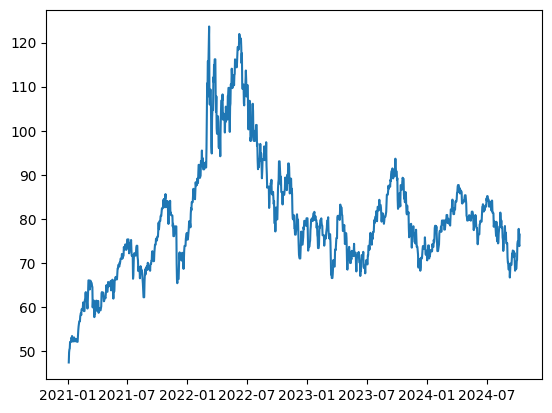

In [8]:
plt.plot(crude_modeling_df['Date'], crude_modeling_df['crude'])

# Modeling

## Splits

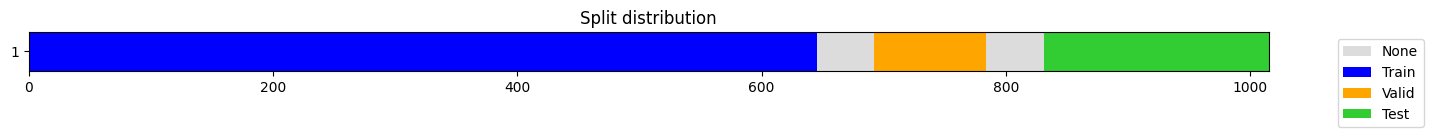

((#645) [0,1,2,3,4,5,6,7,8,9...],
 (#92) [692,693,694,695,696,697,698,699,700,701...],
 (#184) [831,832,833,834,835,836,837,838,839,840...])

In [17]:
datetime_col = 'date'
fcst_history = 336 # # steps in the past
fcst_horizon = 48  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits


In [24]:
train_data = crude_modeling_df.iloc[splits[0]]
test_data = crude_modeling_df.iloc[splits[2]]
val_data = crude_modeling_df.iloc[splits[1]]

In [25]:
train_data

date  crude
0   2021-01-04  47.47
1   2021-01-05  49.78
2   2021-01-06  50.45
3   2021-01-07  50.63
4   2021-01-08  52.14
..         ...    ...
640 2022-10-06  88.90
641 2022-10-07  93.07
642 2022-10-08  93.07
643 2022-10-09  93.07
644 2022-10-10  91.60

[645 rows x 2 columns]

## Standardization

In [26]:
scaler = StandardScaler()

In [27]:
scaled_crude_modeling_df = crude_modeling_df.copy()

In [28]:
scaler.fit(train_data[['crude']])
scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

In [29]:
scaled_crude_modeling_df

date     crude
0    2021-01-04 -1.887099
1    2021-01-05 -1.759268
2    2021-01-06 -1.722191
3    2021-01-07 -1.712230
4    2021-01-08 -1.628669
...         ...       ...
1393 2024-10-28 -0.770372
1394 2024-10-29 -0.770372
1395 2024-10-30 -0.770372
1396 2024-10-31 -0.770372
1397 2024-11-01 -0.770372

[1398 rows x 2 columns]

In [30]:
scaled_train_data = scaled_crude_modeling_df.iloc[splits[0]]
scaled_test_data = scaled_crude_modeling_df.iloc[splits[2]]
scaled_val_data = scaled_crude_modeling_df.iloc[splits[1]]

## Sliding Window

In [31]:
x_vars = 'crude'
y_vars = 'crude'


In [32]:
x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
x.shape, y.shape

((1015, 1, 336), (1015, 1, 48))

In [33]:
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # or dtype=torch.int64 for classi


In [34]:
x_tensor.dtype

torch.float32

In [402]:
# Convert each fastcore foundation list to a standard Python list
splits = [list(split) for split in splits]
splits = [np.array(split, dtype=np.int32) for split in splits]

## Model Building

In [35]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.1, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=10,  # length of the patch applied to the time series to create patches
    stride=1,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)


In [36]:
learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size=64,
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

In [37]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 64 x 1 x 336)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 1 x 48         
RevIN                                     2          True      
____________________________________________________________________________
                     64 x 1 x 337        
ReplicationPad1d                                               
____________________________________________________________________________
                     64 x 10 x 328       
Unfold                                                         
____________________________________________________________________________
                     64 x 1 x 328 x 16   
Linear                                    176        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

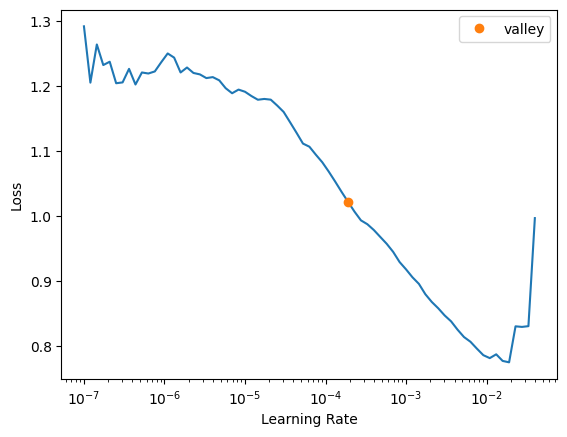

In [38]:
lr_max = learn.lr_find().valley

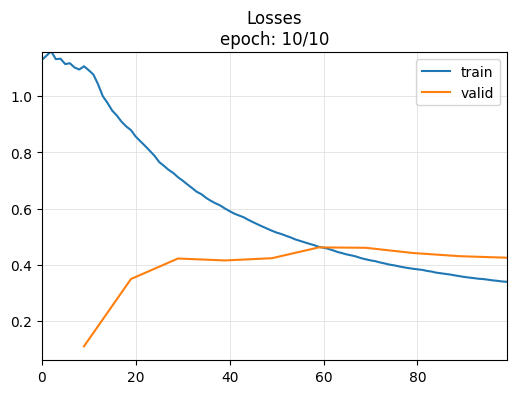

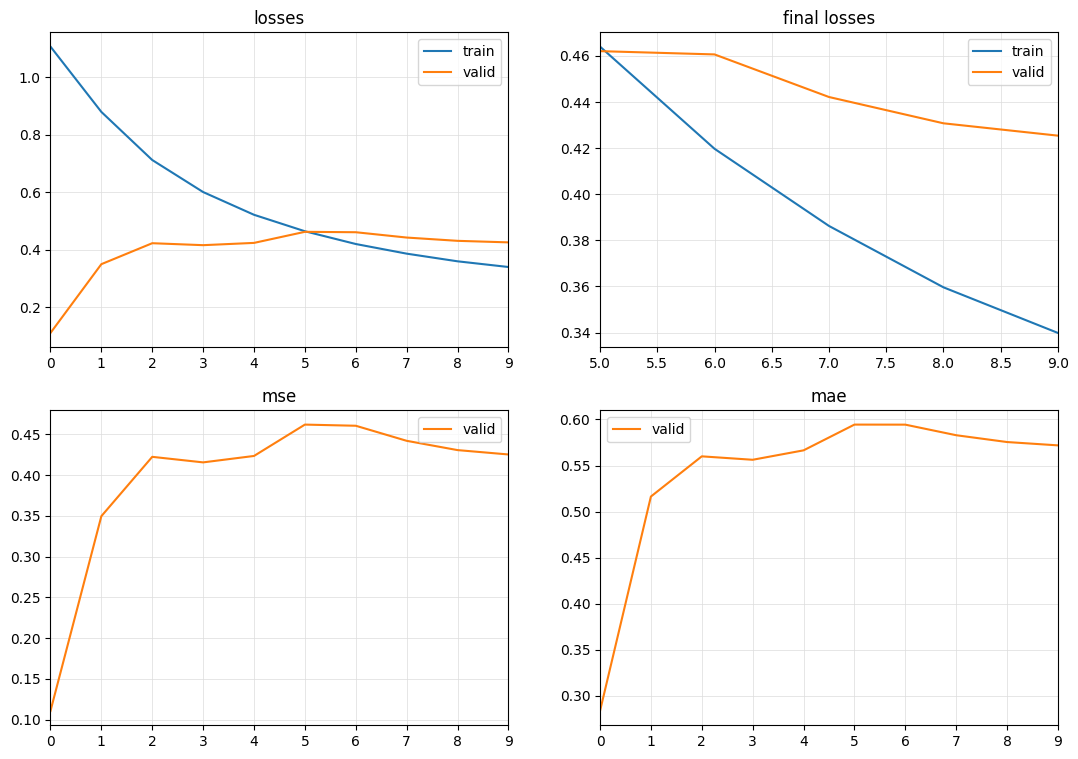

In [39]:
n_epochs = 10
learn.fit_one_cycle(n_epochs, lr_max =lr_max)
learn.export('patchTST.pt')

In [40]:
learn.export('patchTST.pt')

# Model Validation

In [42]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(x[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df


scaled_preds.shape: (92, 1, 48)


mse       mae
valid  0.425394  0.571866

In [43]:
learn = load_learner('patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(x[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (184, 1, 48)


mse       mae
test  0.153932  0.298572

In [44]:
    x_test = x[splits[2]]
    y_test = y[splits[2]]

    inverse_scale_y_preds = scaler.inverse_transform(y_test_preds.reshape(-1, 1)).flatten().reshape(184, 1, 48)
    inverse_scale_y_true = (scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()).reshape(184, 1, 48)
    inverse_scale_x_test = scaler.inverse_transform(x_test.reshape(-1, 1)).flatten().reshape(184, 1, 336)

array([84.86245 , 86.488106, 87.27215 , ..., 66.930115, 67.97325 ,
       63.96171 ], dtype=float32)

In [485]:
y_test_preds.shape

(184, 1, 48)

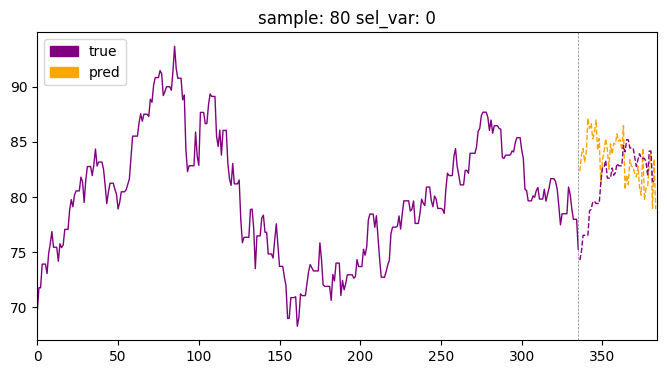

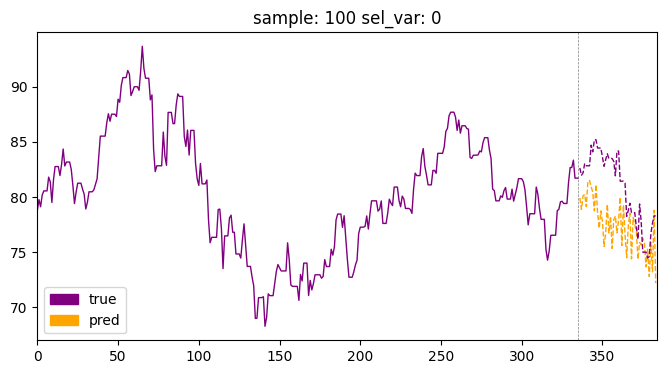

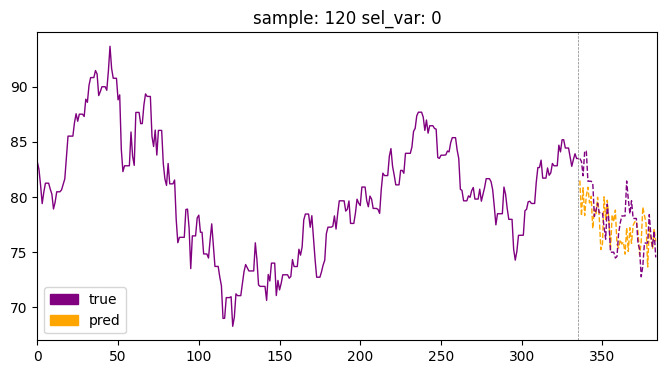

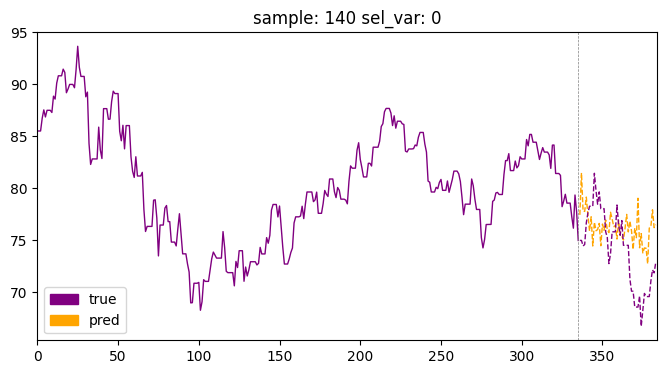

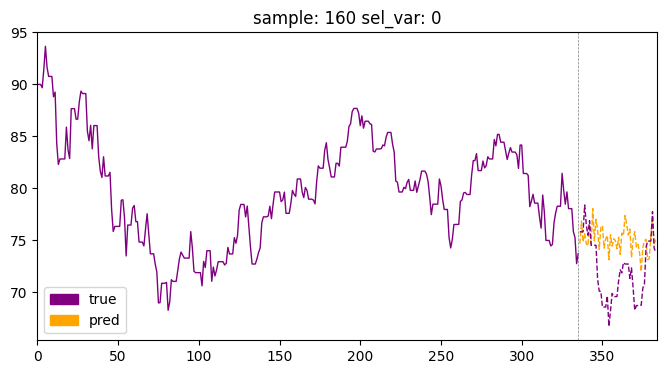

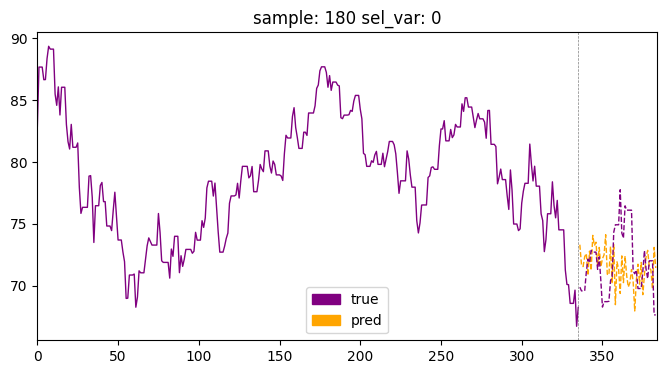

In [45]:


for id in range (80,200, 20):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


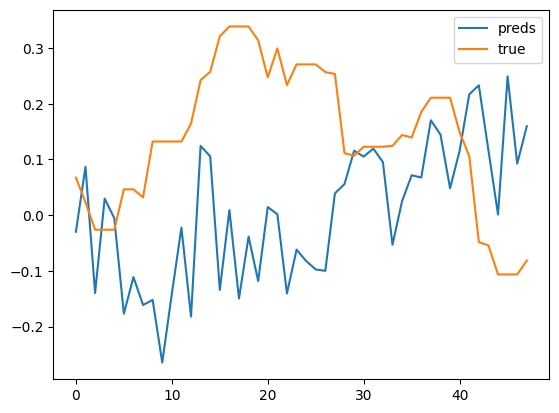

In [46]:
plt.plot(y_test_preds[4][0], label = 'preds')
plt.plot(y_test[4][0], label = 'true')
plt.legend()

In [413]:
y_preds_tensor = torch.tensor(y_test_preds)


y_test = y[splits[2]]
y_test_tensor = torch.tensor(y_test)

In [414]:
y_test_tensor.shape


torch.Size([184, 1, 48])

In [415]:
append_preds = y_preds_tensor[-1, 0, 1:]
append_preds

append_true = y_test_tensor[-1, 0, 1:]


In [416]:
first_preds = y_preds_tensor[:, 0, 0]

first_true = y_test_tensor[:, 0, 0]

first_preds_with_final = torch.cat((first_preds, append_preds))

first_true_with_final = torch.cat((first_true, append_true))


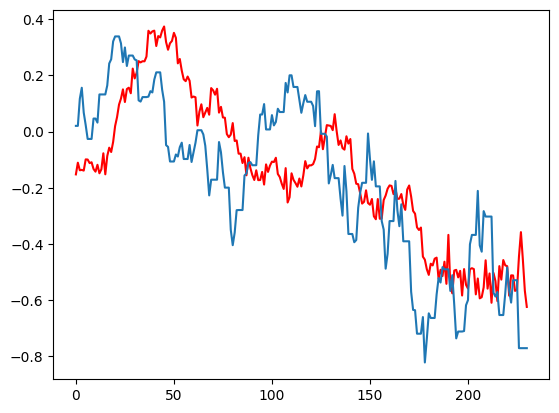

In [417]:
plt.plot(first_preds_with_final, c = 'r')
plt.plot(first_true_with_final)

In [418]:
splits[0][-1]

644

In [419]:
splits[1][0]

692

In [420]:
splits[1][-1]

783

In [421]:
splits[2][0]

831

In [422]:
#all sample predictions are valid and independent. Give 250 it gives the next 50.

#can access these to see how the model is doing over the next horizon

#however if you take the first from each, there will be a lag. if you input 250 the model outputs the next 50 you take first

#but when you input the next 250, it contains the true value for what you predicted, the model hence, predicts from
#true value and hence, if i take the first from each, it does not make any sense.



# Optuna

In [56]:
def objective(trial):

    HPs = {   'fcst_history': trial.suggest_int("fcst_history", 50, 400, step=50), # 'step' defines the granularity of the exploration
              'fcst_horizon': trial.suggest_int("fcst_horizon", 16, 128, step= 16),
              'batch_size': trial.suggest_int("batch_size", 8, 128, step=8),
              'epochs': trial.suggest_int("epochs", 5, 20, step = 1),
              'n_layers': trial.suggest_int("n_layers", 2, 6, step = 2),
              'n_heads': trial.suggest_int("n_heads", 2, 6, step = 2),
              'd_model': trial.suggest_int("d_model", 16, 128, step = 8),
              'd_ff': trial.suggest_int("d_ff", 16, 256, step = 8),
              'attn_dropout': trial.suggest_float("attn_dropout", 0, 0.5, step=0.1),
              'dropout': trial.suggest_float("dropout", 0, 0.5, step=0.1),
              'patch_len': trial.suggest_int("patch_len", 1, 20, step=10),
              'stride': trial.suggest_int("stride", 1, 5, step=1)

           
              }

    try: 
        loss = train_model(HPs)
        return loss
    except Exception as e: 
        print(f'Study failed because {e}.')
        return None
      
  


In [33]:
def data_preparation(HPs):



  #setting basic params
  datetime_col = 'date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = HPs['fcst_horizon']
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)

  return splits, x_tensor, y_tensor, x, y









In [48]:
def train_model(HPs):

    splits, x_tensor, y_tensor, x, y = data_preparation(HPs)

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae])

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'], lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
    learn = load_learner('patchTST.pt')
    scaled_preds, *_ = learn.get_X_preds(x[splits[1]])
    scaled_preds = to_np(scaled_preds)
    print(f"scaled_preds.shape: {scaled_preds.shape}")

    scaled_y_true = y[splits[1]]
    loss = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df = pd.DataFrame(columns=["mse", "mae"])
    results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())




  





    return loss











[I 2024-11-05 01:15:21,026] Using an existing study with name 'oil_price_patch' instead of creating a new one.


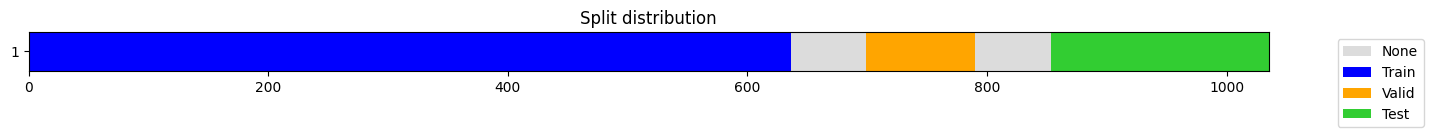

[I 2024-11-05 01:15:26,799] Trial 829 finished with value: 0.5038946553790145 and parameters: {'fcst_history': 300, 'fcst_horizon': 64, 'batch_size': 128, 'epochs': 5, 'n_layers': 6, 'n_heads': 4, 'd_model': 128, 'd_ff': 176, 'attn_dropout': 0.30000000000000004, 'dropout': 0.4, 'patch_len': 1, 'stride': 2}. Best is trial 15 with value: 0.07396565575092504.


scaled_preds.shape: (91, 1, 64)


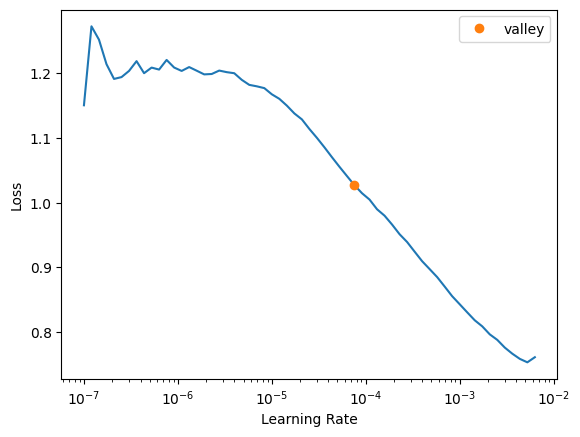

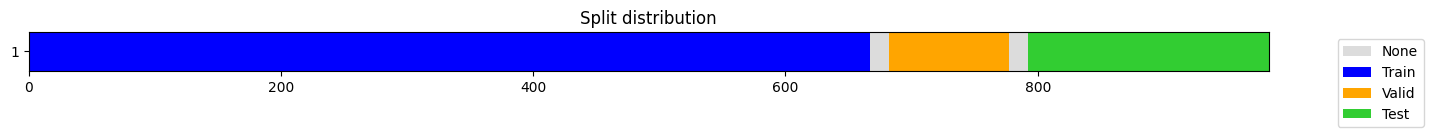

[W 2024-11-05 01:15:27,368] Trial 830 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:27,369] Trial 830 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


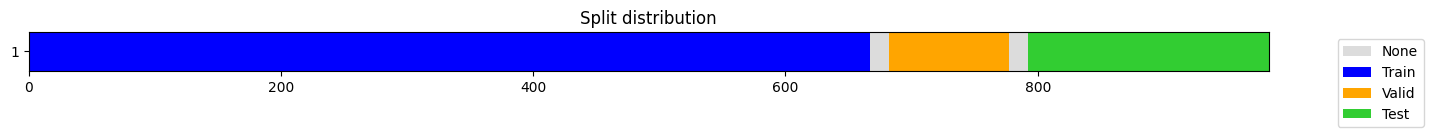

[W 2024-11-05 01:15:27,775] Trial 831 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:27,775] Trial 831 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


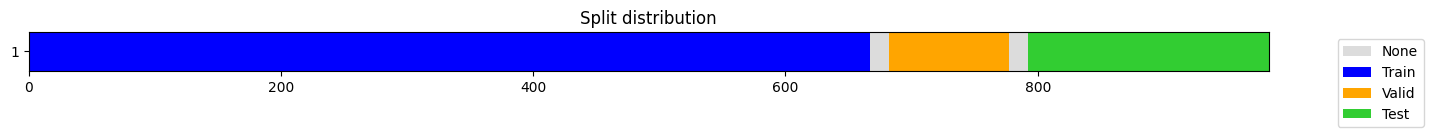

[W 2024-11-05 01:15:28,150] Trial 832 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:28,151] Trial 832 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


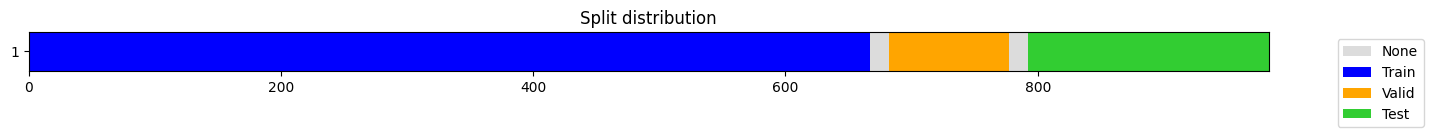

[W 2024-11-05 01:15:28,530] Trial 833 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:28,531] Trial 833 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


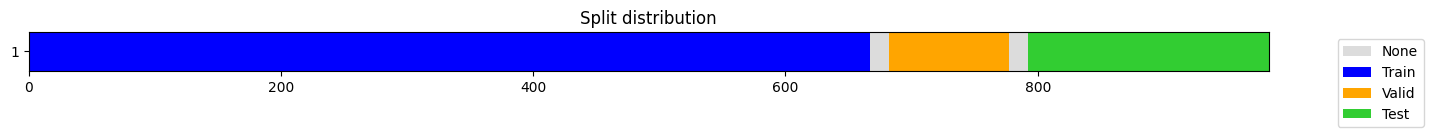

[W 2024-11-05 01:15:28,899] Trial 834 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:28,900] Trial 834 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


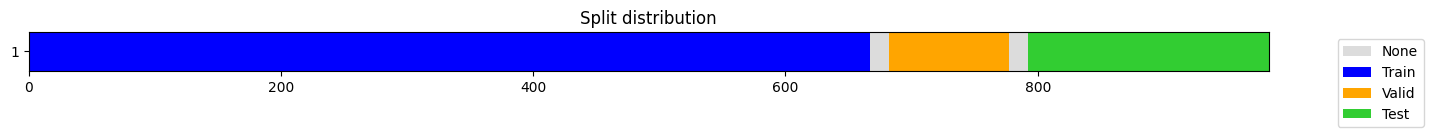

[W 2024-11-05 01:15:29,271] Trial 835 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:29,272] Trial 835 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


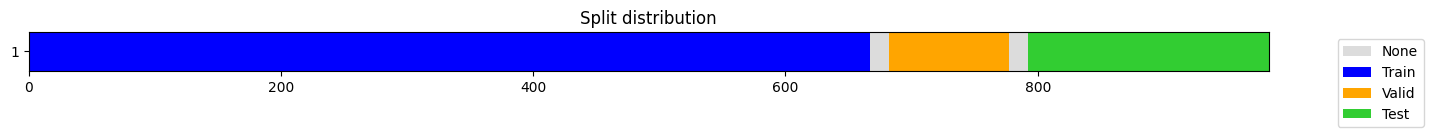

[W 2024-11-05 01:15:29,632] Trial 836 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:29,633] Trial 836 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


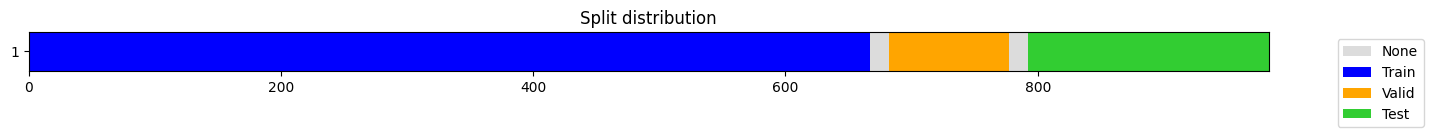

[W 2024-11-05 01:15:30,011] Trial 837 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:30,012] Trial 837 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


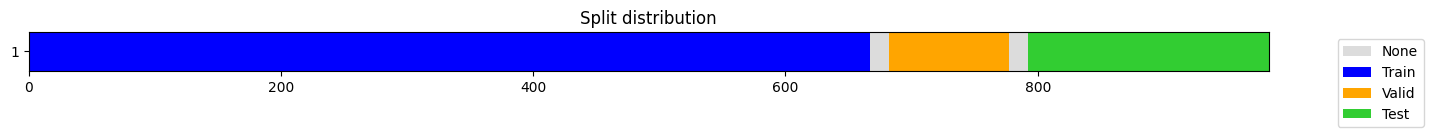

[W 2024-11-05 01:15:30,395] Trial 838 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:30,395] Trial 838 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


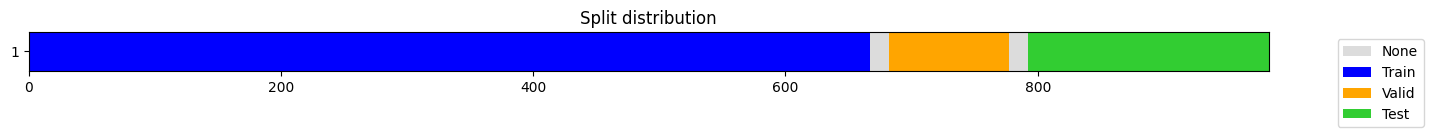

[W 2024-11-05 01:15:30,767] Trial 839 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:30,768] Trial 839 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


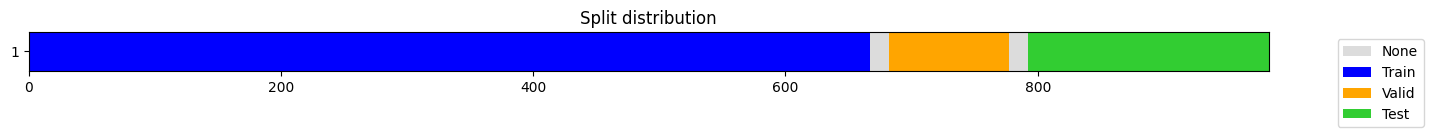

[W 2024-11-05 01:15:31,125] Trial 840 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:31,125] Trial 840 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


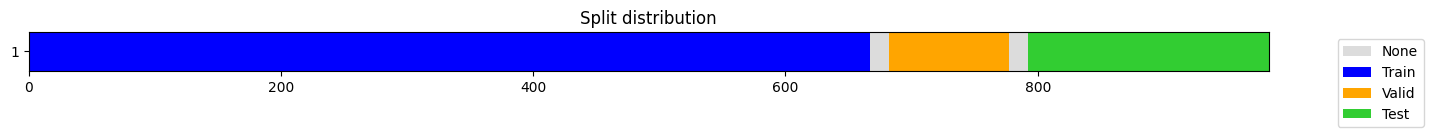

[W 2024-11-05 01:15:31,505] Trial 841 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 12, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:31,505] Trial 841 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


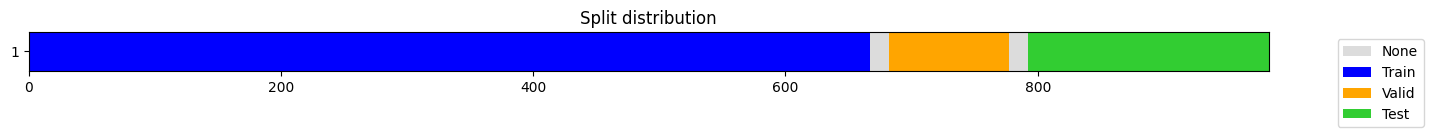

[W 2024-11-05 01:15:31,858] Trial 842 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:31,859] Trial 842 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


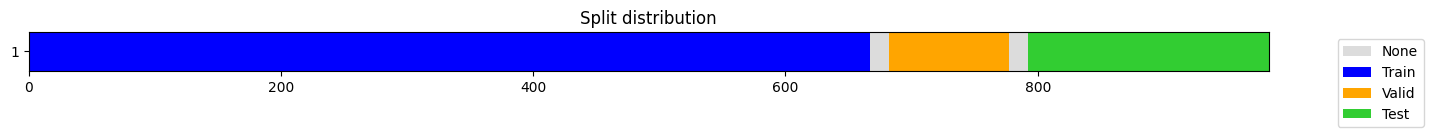

[W 2024-11-05 01:15:32,233] Trial 843 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:32,233] Trial 843 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


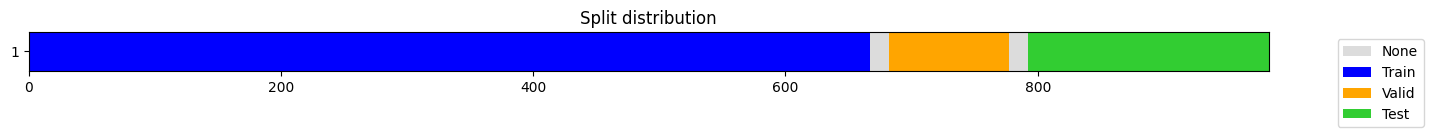

[W 2024-11-05 01:15:32,592] Trial 844 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:32,592] Trial 844 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


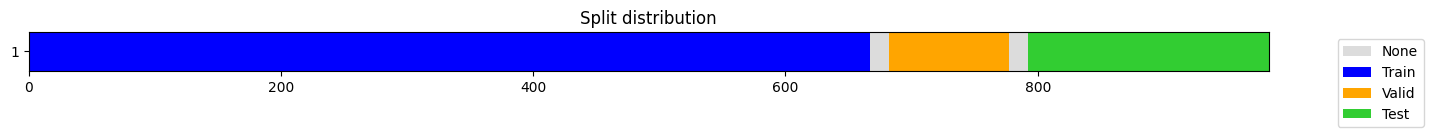

[W 2024-11-05 01:15:32,957] Trial 845 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:32,957] Trial 845 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


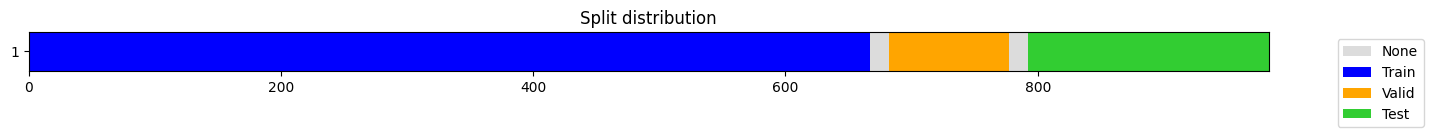

[W 2024-11-05 01:15:33,334] Trial 846 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 168, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:33,335] Trial 846 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


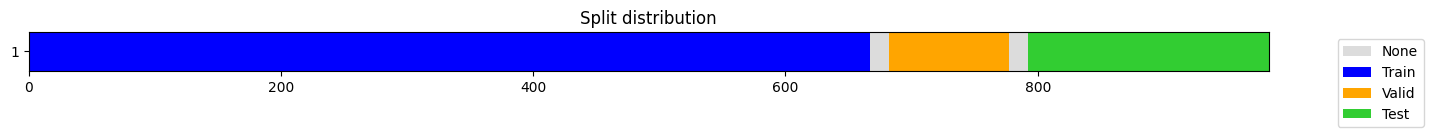

[W 2024-11-05 01:15:33,737] Trial 847 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:33,738] Trial 847 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


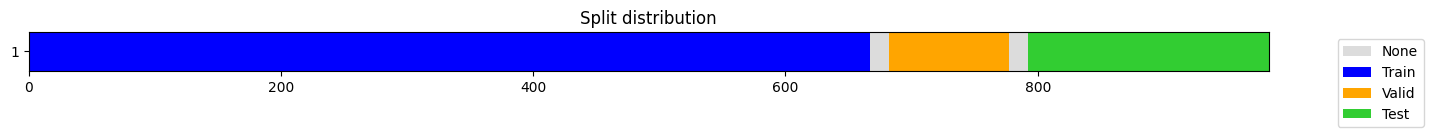

[W 2024-11-05 01:15:34,098] Trial 848 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:34,098] Trial 848 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


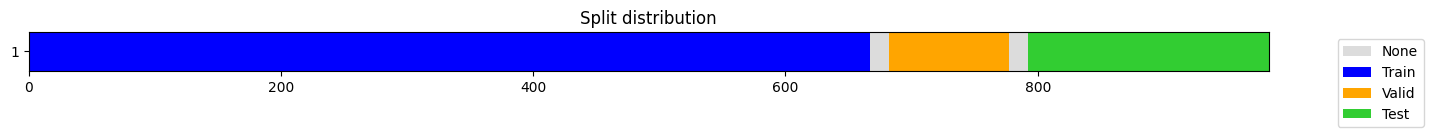

[W 2024-11-05 01:15:34,454] Trial 849 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:34,455] Trial 849 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


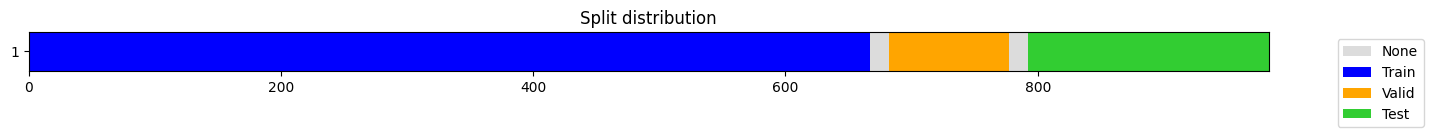

[W 2024-11-05 01:15:34,803] Trial 850 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:34,803] Trial 850 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


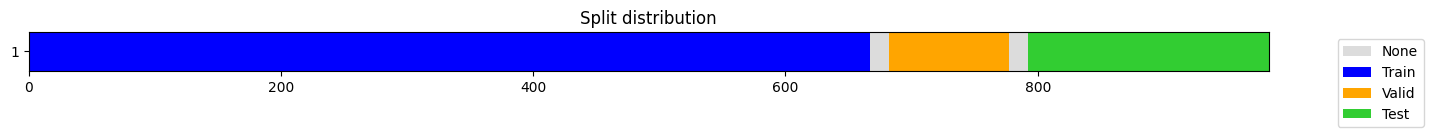

[W 2024-11-05 01:15:35,164] Trial 851 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:35,165] Trial 851 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


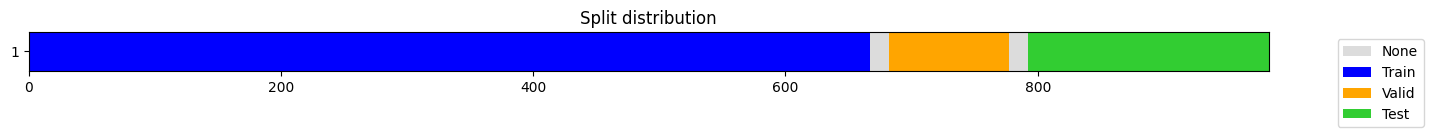

[W 2024-11-05 01:15:35,539] Trial 852 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:35,539] Trial 852 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


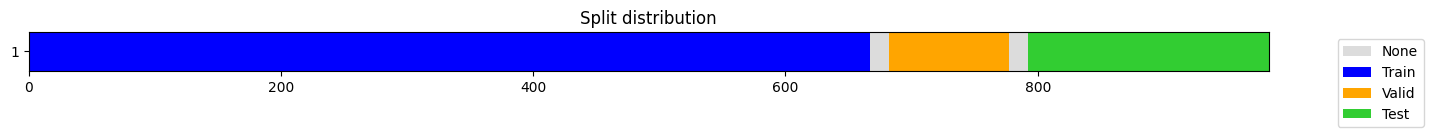

[W 2024-11-05 01:15:35,929] Trial 853 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:35,929] Trial 853 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


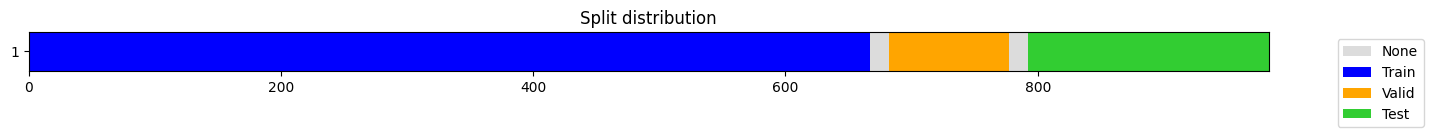

[W 2024-11-05 01:15:36,297] Trial 854 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:36,297] Trial 854 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


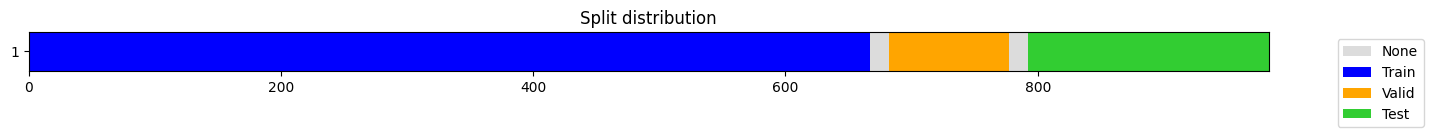

[W 2024-11-05 01:15:36,676] Trial 855 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:36,676] Trial 855 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


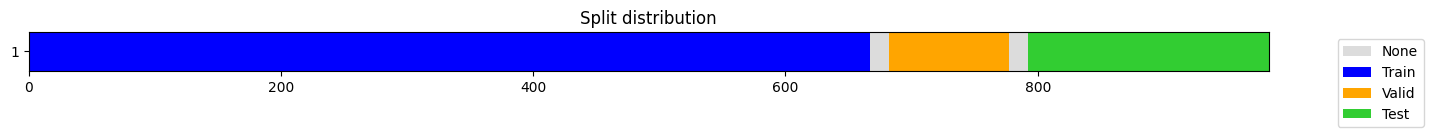

[W 2024-11-05 01:15:37,050] Trial 856 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:37,050] Trial 856 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


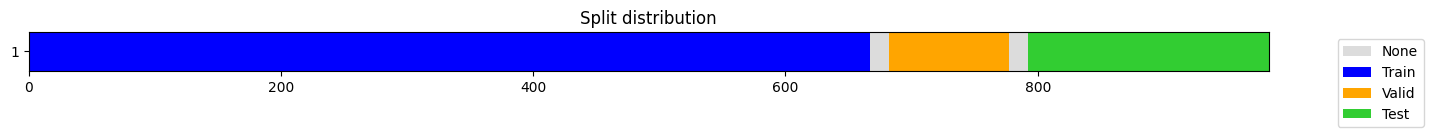

[W 2024-11-05 01:15:37,423] Trial 857 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:37,424] Trial 857 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


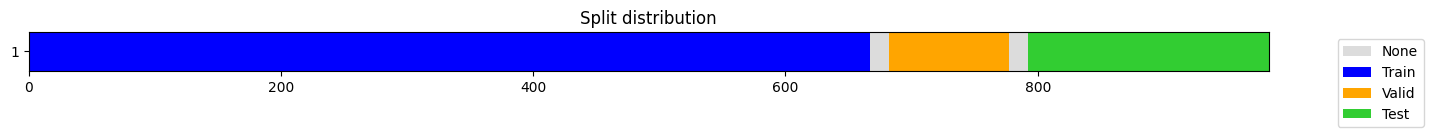

[W 2024-11-05 01:15:37,779] Trial 858 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:37,780] Trial 858 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


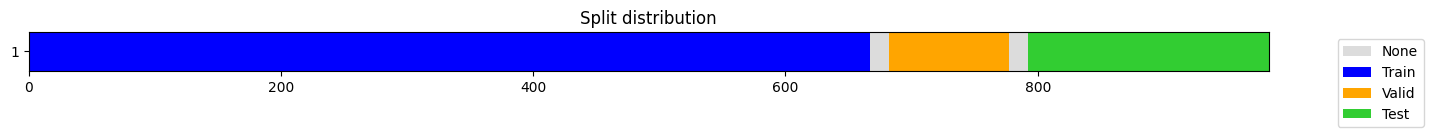

[W 2024-11-05 01:15:38,132] Trial 859 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:38,133] Trial 859 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


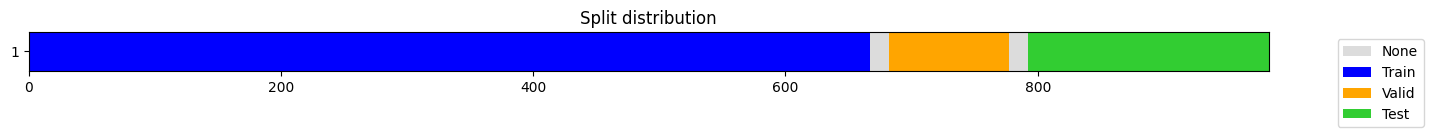

[W 2024-11-05 01:15:38,867] Trial 860 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:38,868] Trial 860 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


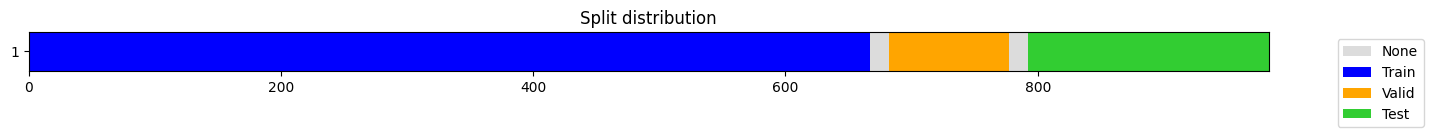

[W 2024-11-05 01:15:39,217] Trial 861 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:39,218] Trial 861 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


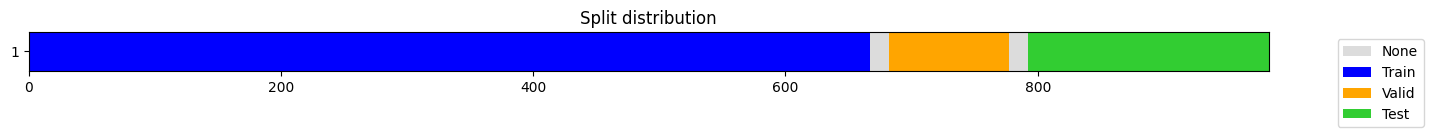

[W 2024-11-05 01:15:39,597] Trial 862 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:39,597] Trial 862 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


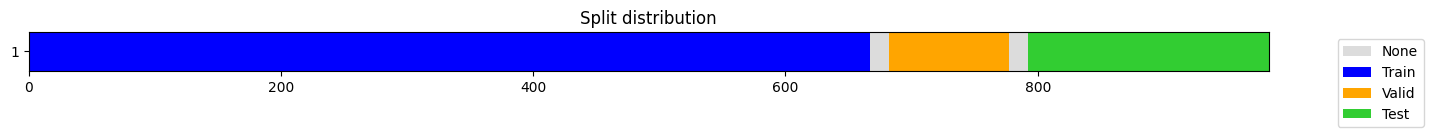

[W 2024-11-05 01:15:39,966] Trial 863 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:39,967] Trial 863 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


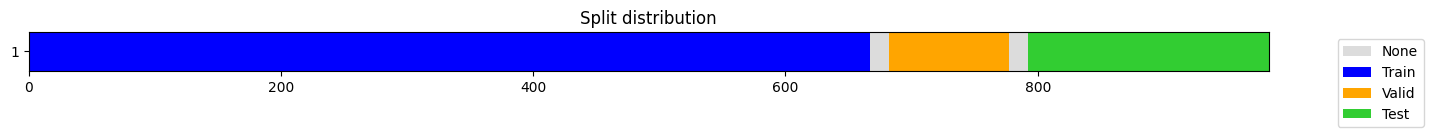

[W 2024-11-05 01:15:40,325] Trial 864 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:40,325] Trial 864 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


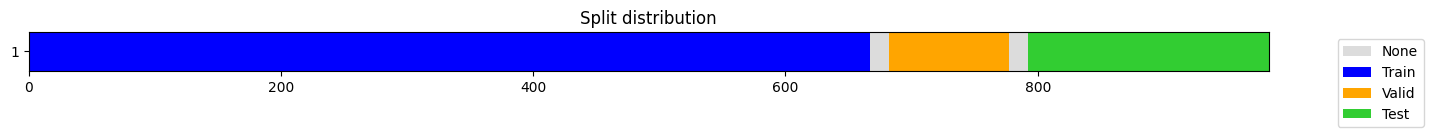

[W 2024-11-05 01:15:40,681] Trial 865 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:40,681] Trial 865 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


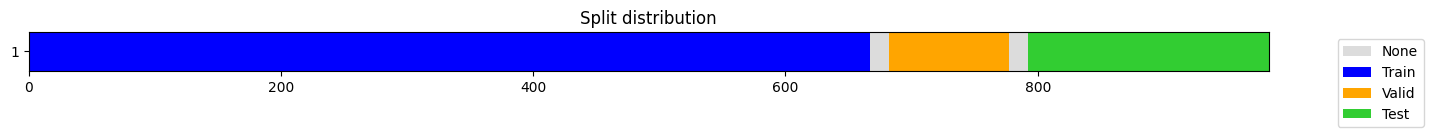

[W 2024-11-05 01:15:41,031] Trial 866 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:41,031] Trial 866 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


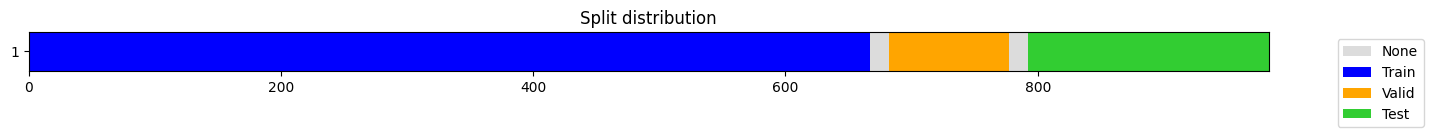

[W 2024-11-05 01:15:41,388] Trial 867 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:41,388] Trial 867 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


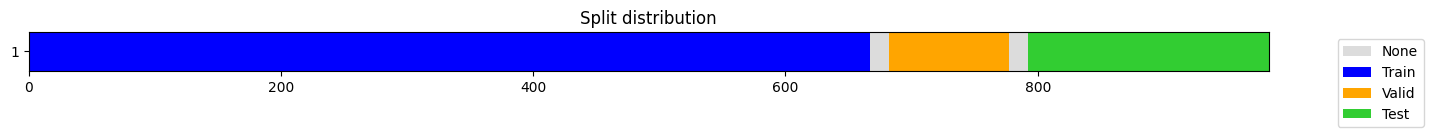

[W 2024-11-05 01:15:41,756] Trial 868 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:41,756] Trial 868 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


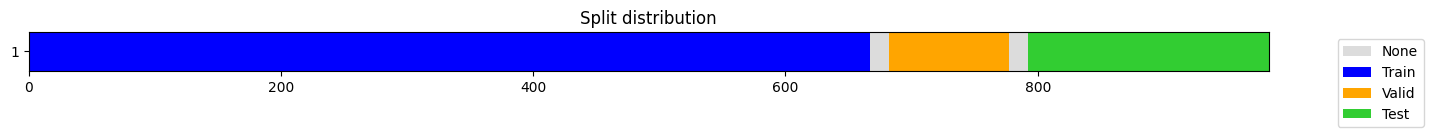

[W 2024-11-05 01:15:42,121] Trial 869 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:42,122] Trial 869 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


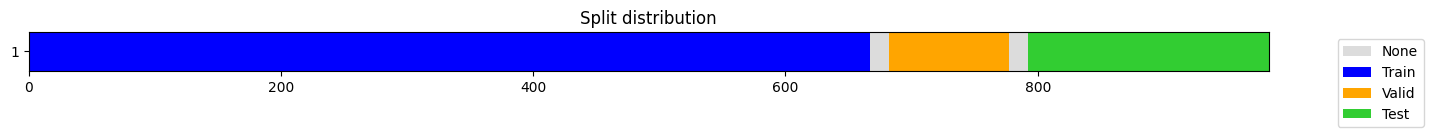

[W 2024-11-05 01:15:42,476] Trial 870 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:42,476] Trial 870 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


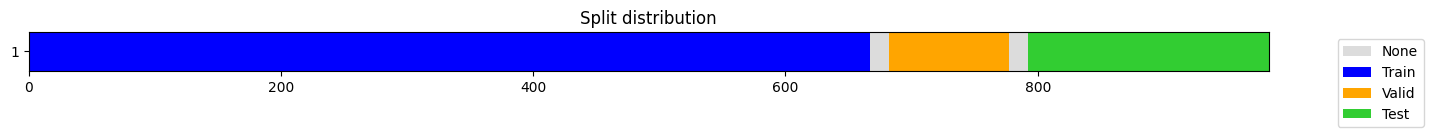

[W 2024-11-05 01:15:42,830] Trial 871 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:42,830] Trial 871 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


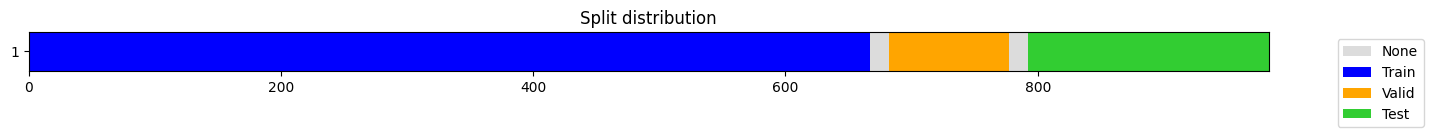

[W 2024-11-05 01:15:43,204] Trial 872 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 200, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:43,205] Trial 872 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


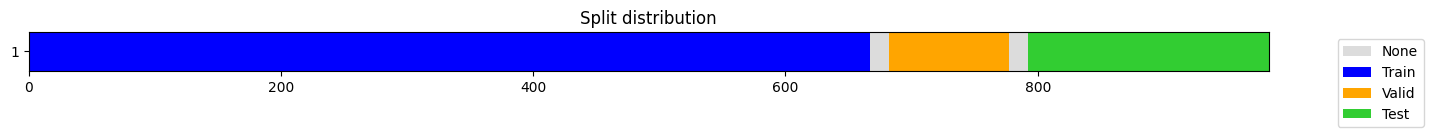

[W 2024-11-05 01:15:43,567] Trial 873 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:43,568] Trial 873 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


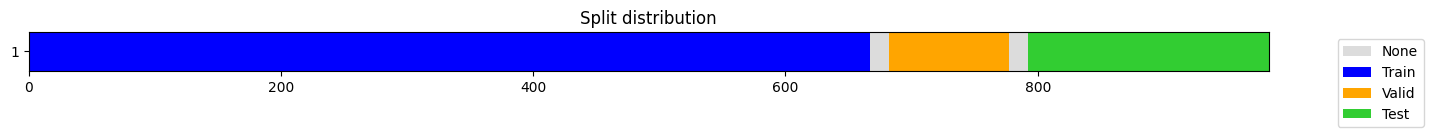

[W 2024-11-05 01:15:43,913] Trial 874 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:43,914] Trial 874 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


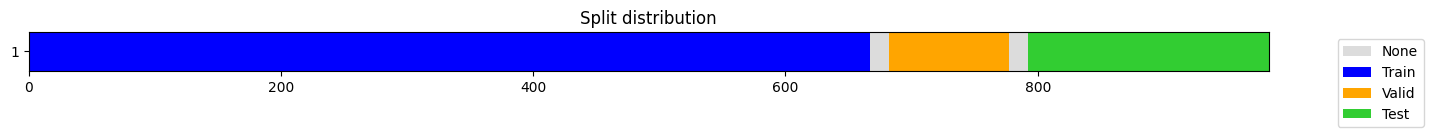

[W 2024-11-05 01:15:44,261] Trial 875 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:44,261] Trial 875 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


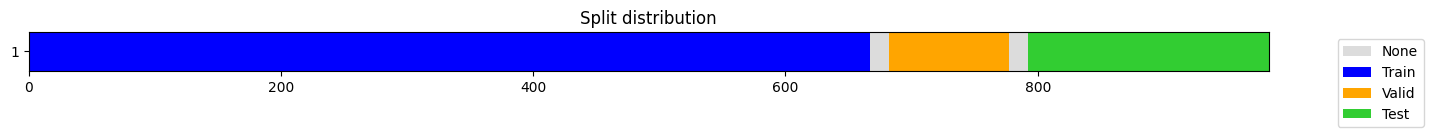

[W 2024-11-05 01:15:44,624] Trial 876 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:44,624] Trial 876 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


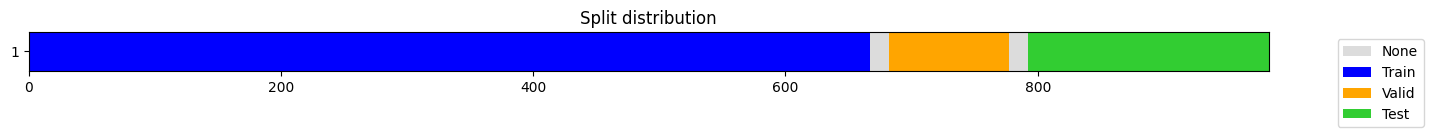

[W 2024-11-05 01:15:44,986] Trial 877 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:44,987] Trial 877 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


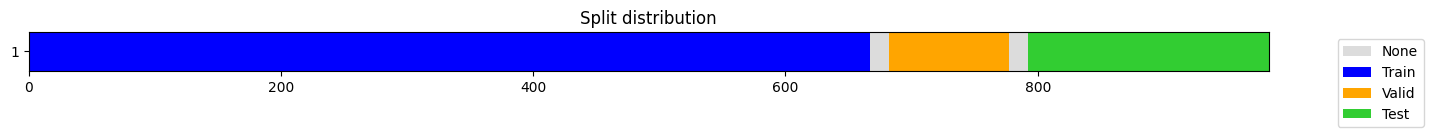

[W 2024-11-05 01:15:45,355] Trial 878 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:45,355] Trial 878 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


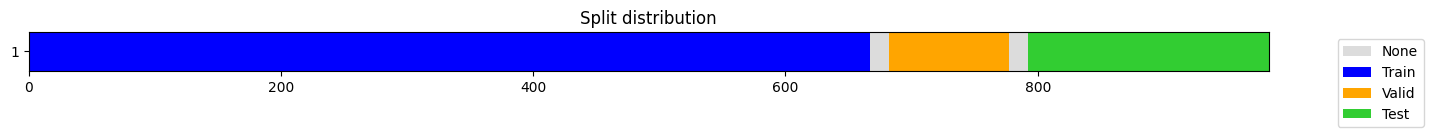

[W 2024-11-05 01:15:45,723] Trial 879 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:45,724] Trial 879 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


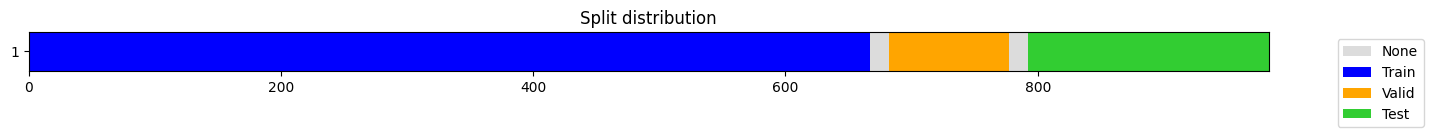

[W 2024-11-05 01:15:46,082] Trial 880 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:46,082] Trial 880 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


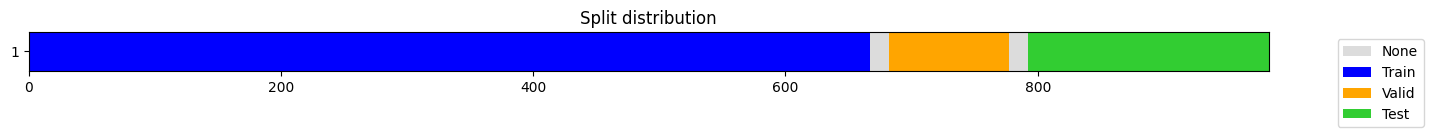

[W 2024-11-05 01:15:46,441] Trial 881 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:46,441] Trial 881 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


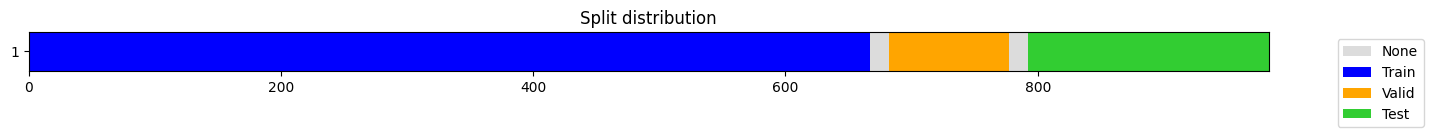

[W 2024-11-05 01:15:46,794] Trial 882 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:46,795] Trial 882 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


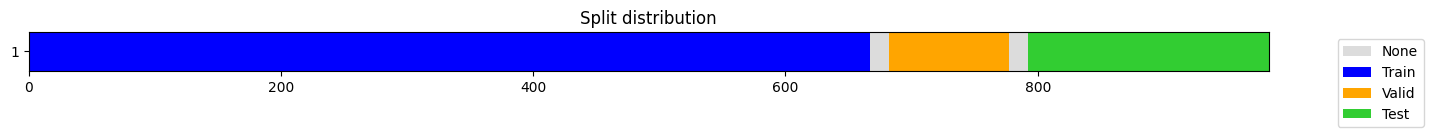

[W 2024-11-05 01:15:47,153] Trial 883 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:47,154] Trial 883 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


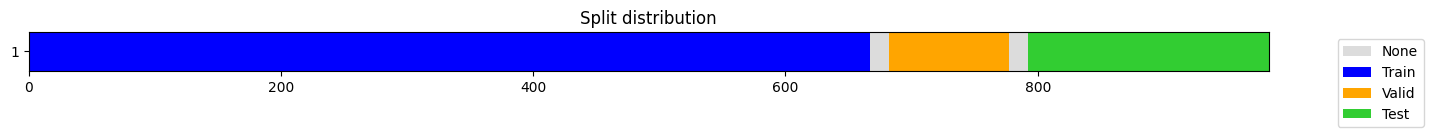

[W 2024-11-05 01:15:47,506] Trial 884 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:47,506] Trial 884 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


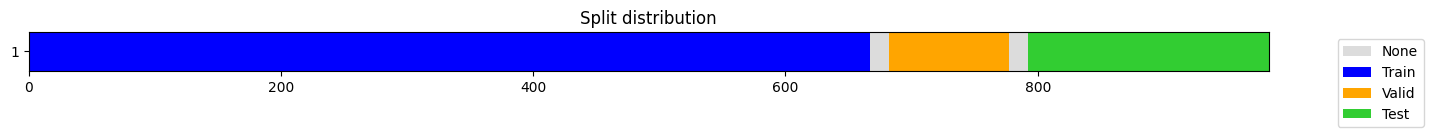

[W 2024-11-05 01:15:47,860] Trial 885 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:47,861] Trial 885 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


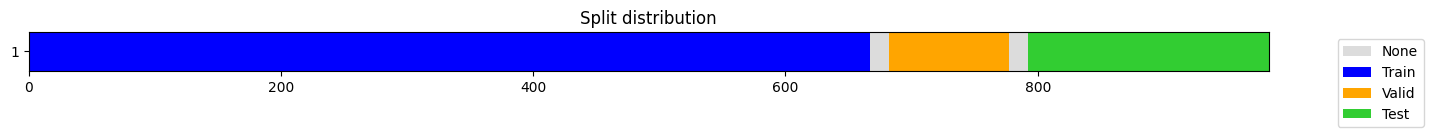

[W 2024-11-05 01:15:48,214] Trial 886 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:48,214] Trial 886 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


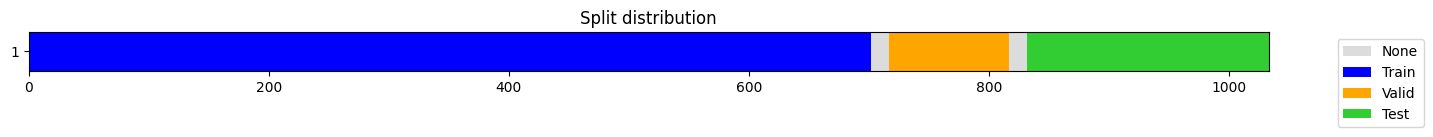

[W 2024-11-05 01:15:48,563] Trial 887 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:48,564] Trial 887 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


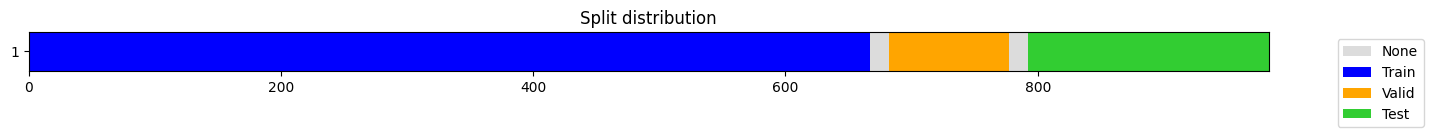

[W 2024-11-05 01:15:48,919] Trial 888 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:48,920] Trial 888 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


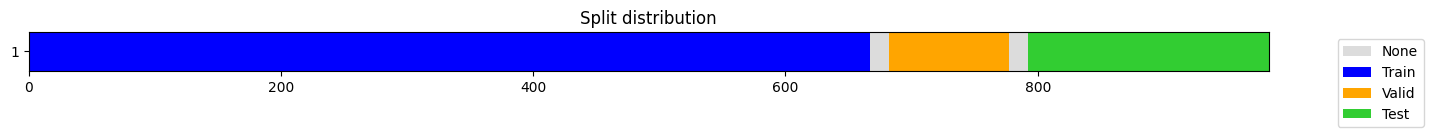

[W 2024-11-05 01:15:49,268] Trial 889 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:49,269] Trial 889 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


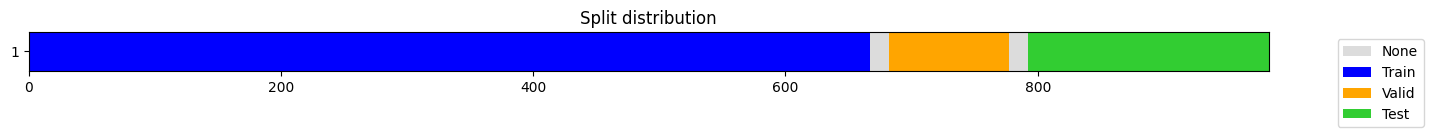

[W 2024-11-05 01:15:49,625] Trial 890 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:49,626] Trial 890 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


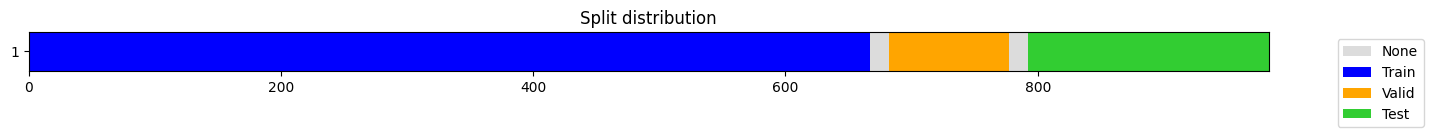

[W 2024-11-05 01:15:49,977] Trial 891 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 168, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:49,978] Trial 891 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


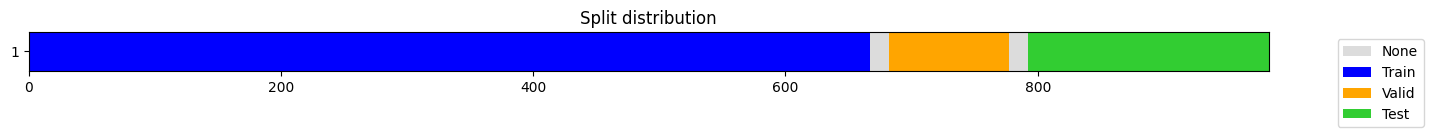

[W 2024-11-05 01:15:50,342] Trial 892 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:50,342] Trial 892 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


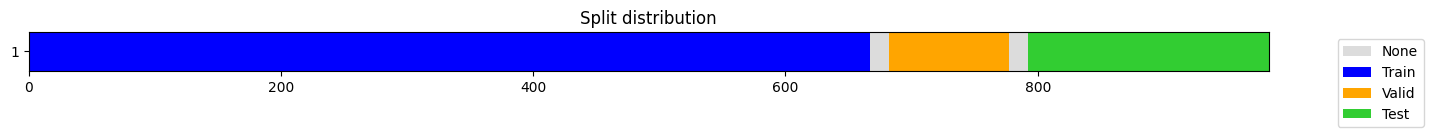

[W 2024-11-05 01:15:50,697] Trial 893 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:50,697] Trial 893 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


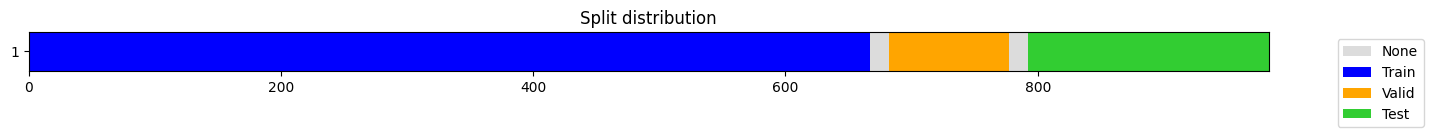

[W 2024-11-05 01:15:51,062] Trial 894 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:51,062] Trial 894 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


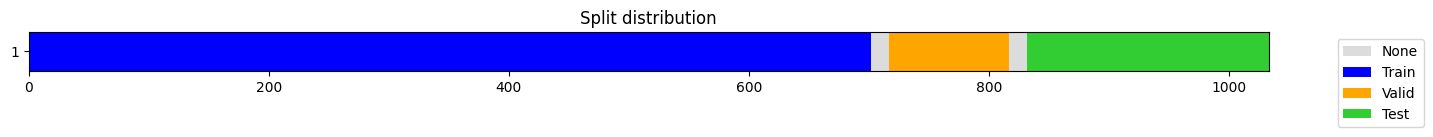

[W 2024-11-05 01:15:51,427] Trial 895 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:51,427] Trial 895 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


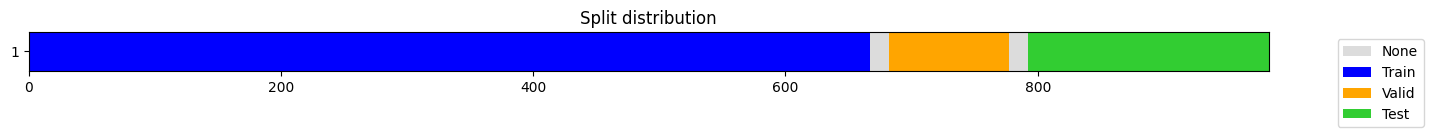

[W 2024-11-05 01:15:51,792] Trial 896 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:51,792] Trial 896 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


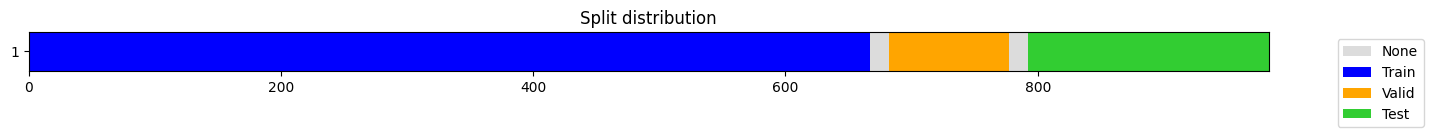

[W 2024-11-05 01:15:52,219] Trial 897 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:52,219] Trial 897 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


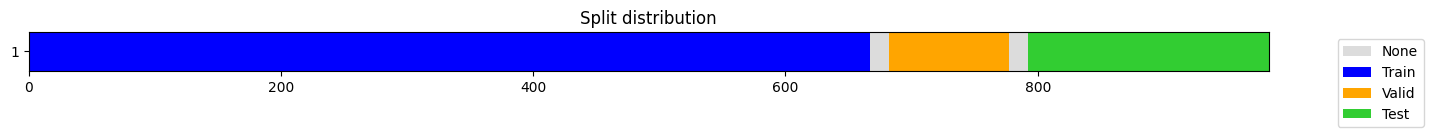

[W 2024-11-05 01:15:52,605] Trial 898 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:52,606] Trial 898 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


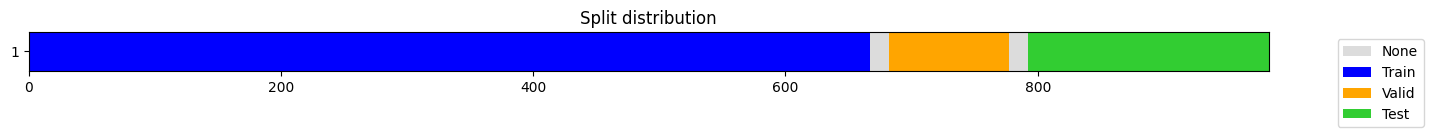

[W 2024-11-05 01:15:52,971] Trial 899 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:52,971] Trial 899 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


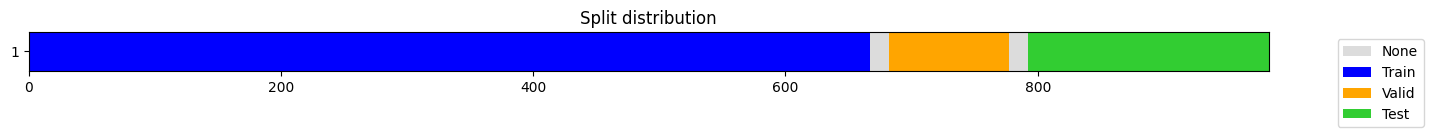

[W 2024-11-05 01:15:53,344] Trial 900 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:53,345] Trial 900 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


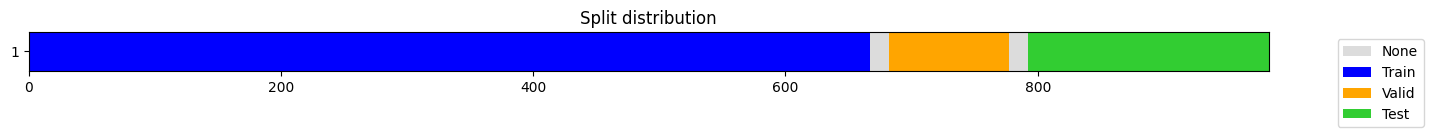

[W 2024-11-05 01:15:53,730] Trial 901 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:53,731] Trial 901 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


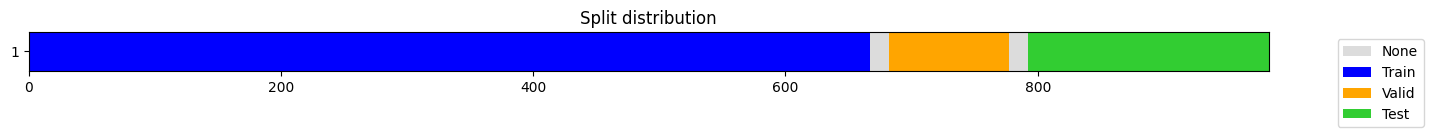

[W 2024-11-05 01:15:54,174] Trial 902 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:54,175] Trial 902 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


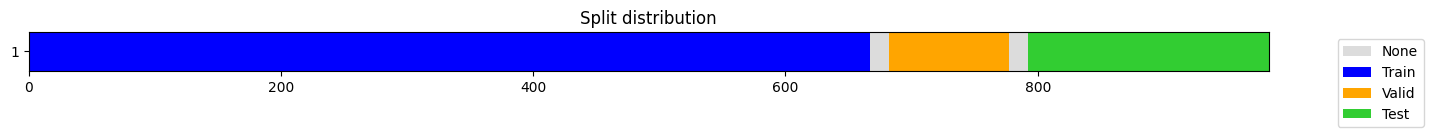

[W 2024-11-05 01:15:54,529] Trial 903 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.30000000000000004, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:54,529] Trial 903 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


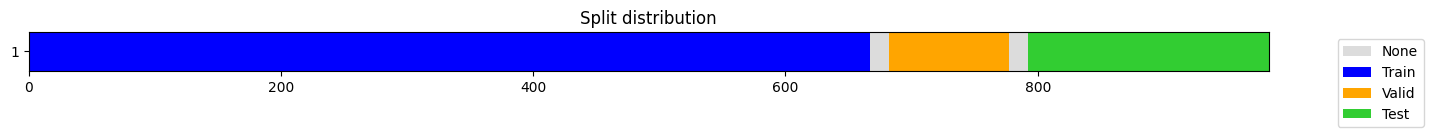

[W 2024-11-05 01:15:54,904] Trial 904 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 168, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:54,905] Trial 904 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


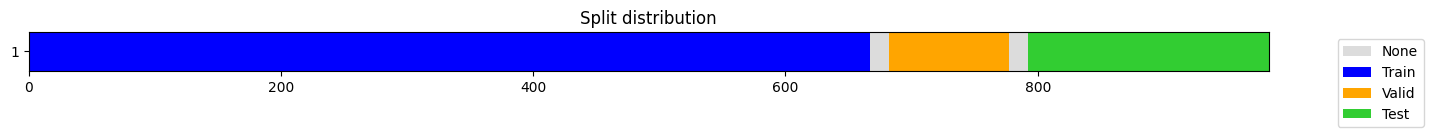

[W 2024-11-05 01:15:55,283] Trial 905 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:55,284] Trial 905 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


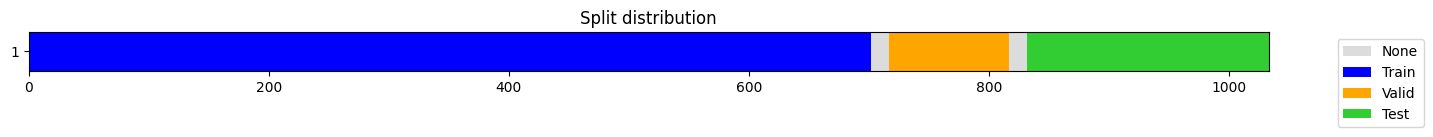

[W 2024-11-05 01:15:55,637] Trial 906 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:55,637] Trial 906 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


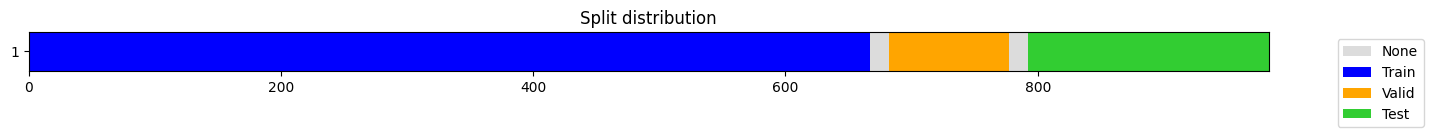

[W 2024-11-05 01:15:55,998] Trial 907 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:55,999] Trial 907 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


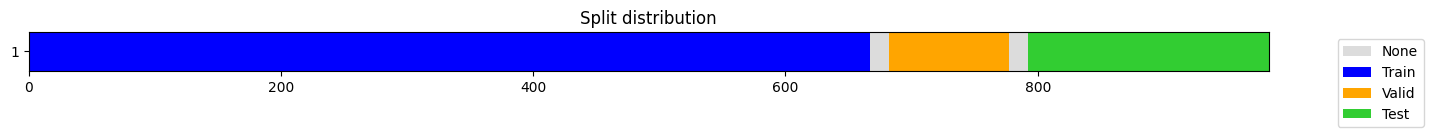

[W 2024-11-05 01:15:56,364] Trial 908 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:56,364] Trial 908 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


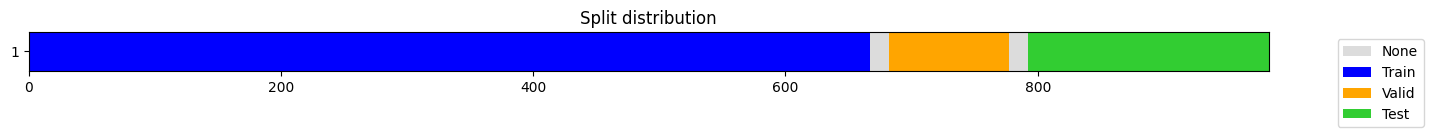

[W 2024-11-05 01:15:56,731] Trial 909 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 9, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:56,732] Trial 909 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


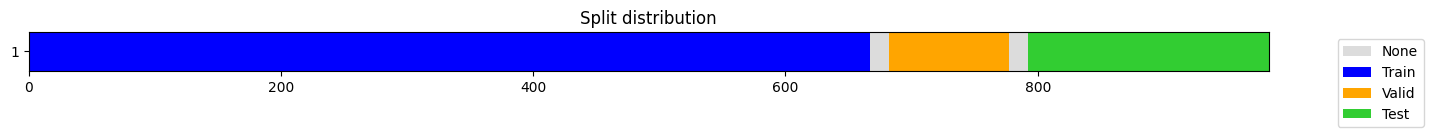

[W 2024-11-05 01:15:57,114] Trial 910 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:57,115] Trial 910 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


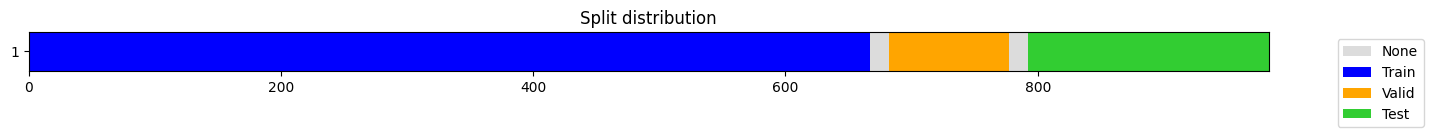

[W 2024-11-05 01:15:57,477] Trial 911 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:57,478] Trial 911 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


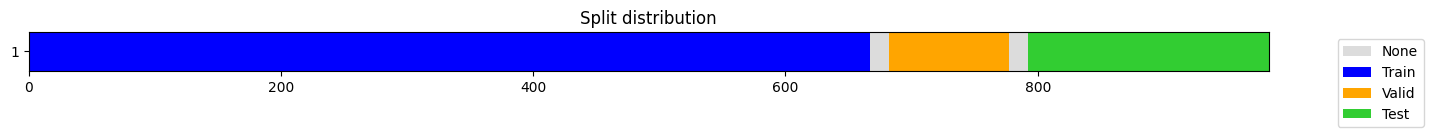

[W 2024-11-05 01:15:57,872] Trial 912 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:57,873] Trial 912 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


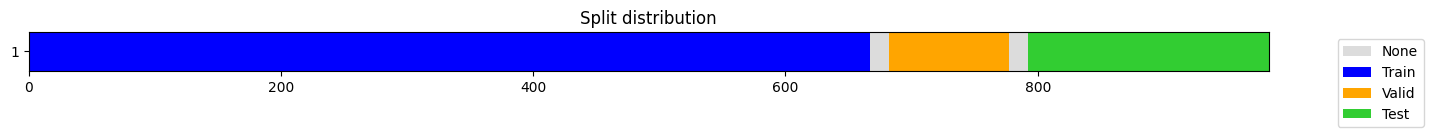

[W 2024-11-05 01:15:58,263] Trial 913 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:58,263] Trial 913 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


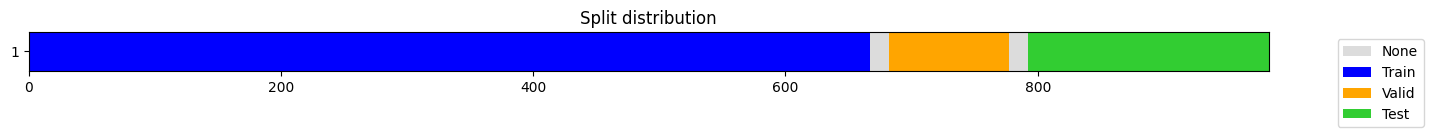

[W 2024-11-05 01:15:58,649] Trial 914 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:58,649] Trial 914 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


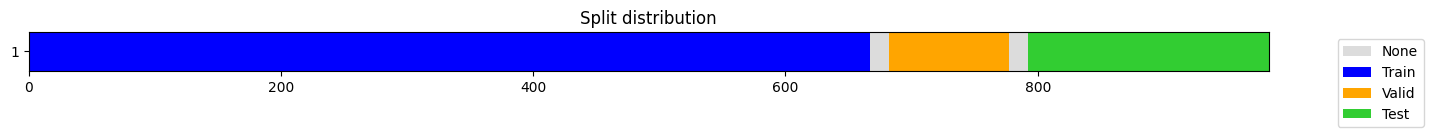

[W 2024-11-05 01:15:59,069] Trial 915 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:59,069] Trial 915 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


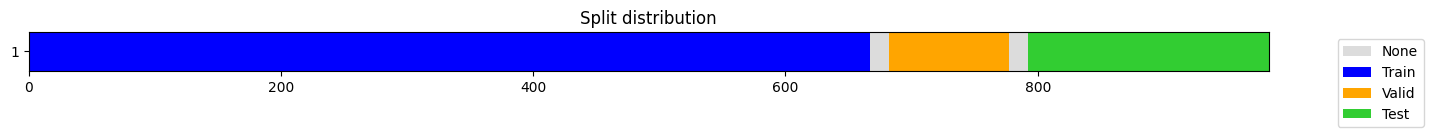

[W 2024-11-05 01:15:59,445] Trial 916 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 168, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:59,446] Trial 916 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


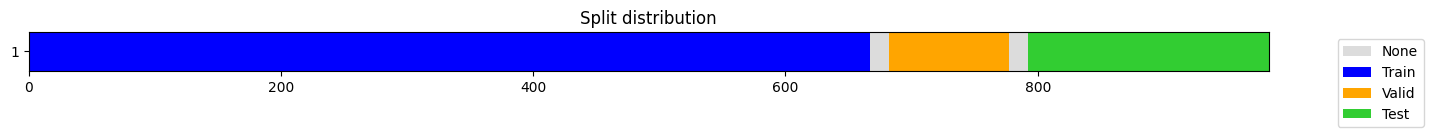

[W 2024-11-05 01:15:59,816] Trial 917 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 48, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:15:59,817] Trial 917 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


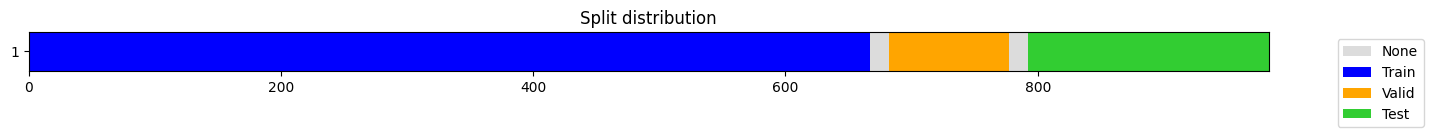

[W 2024-11-05 01:16:00,176] Trial 918 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:00,177] Trial 918 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


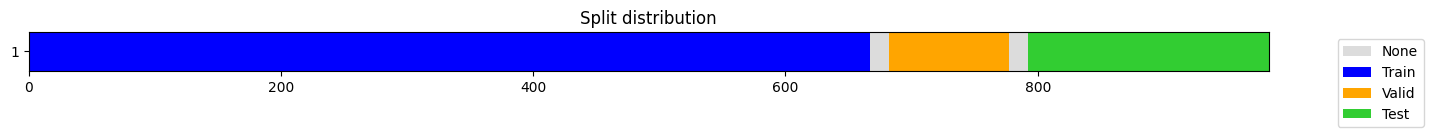

[W 2024-11-05 01:16:00,568] Trial 919 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:00,568] Trial 919 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


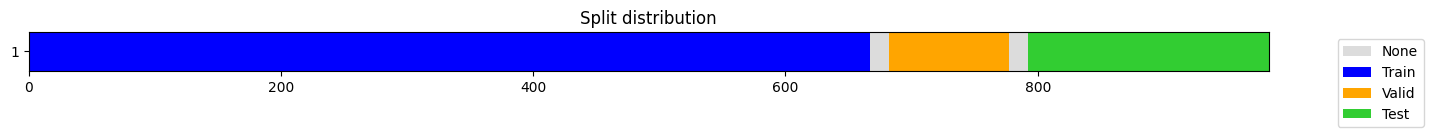

[W 2024-11-05 01:16:00,924] Trial 920 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:00,924] Trial 920 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


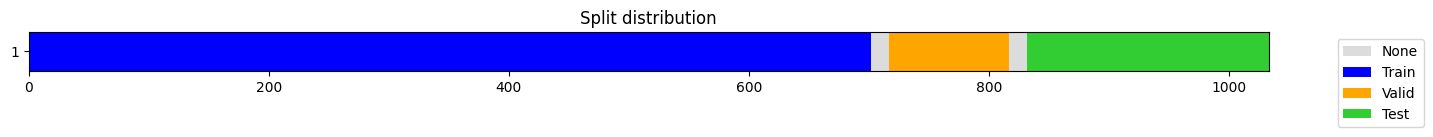

[W 2024-11-05 01:16:01,277] Trial 921 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:01,278] Trial 921 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


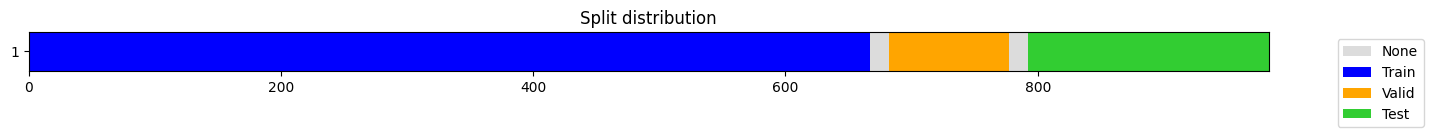

[W 2024-11-05 01:16:01,634] Trial 922 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:01,635] Trial 922 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


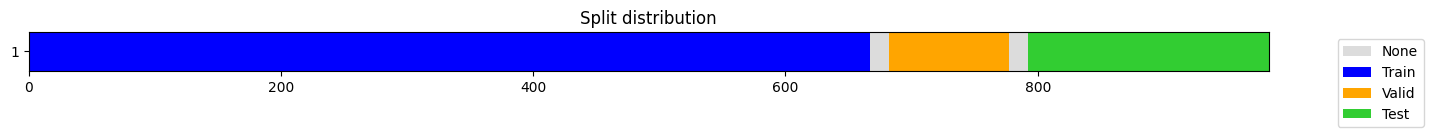

[W 2024-11-05 01:16:02,001] Trial 923 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:02,002] Trial 923 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


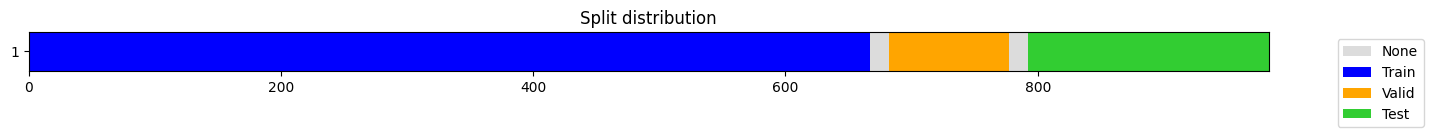

[W 2024-11-05 01:16:02,363] Trial 924 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:02,364] Trial 924 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


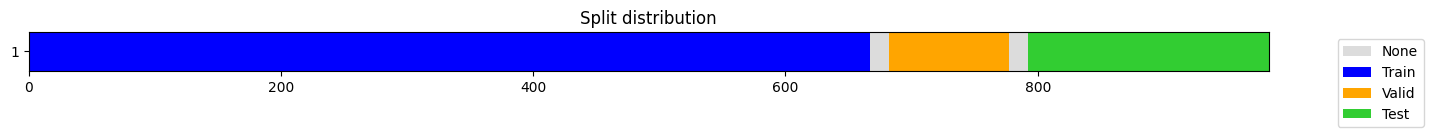

[W 2024-11-05 01:16:02,736] Trial 925 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:02,737] Trial 925 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


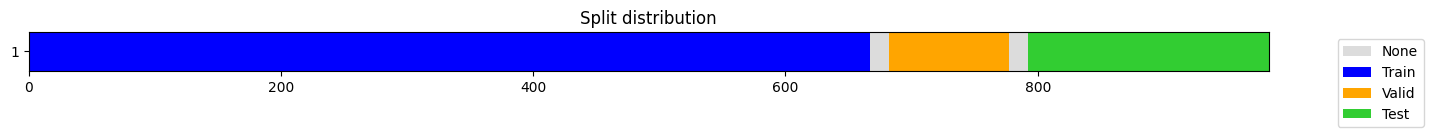

[W 2024-11-05 01:16:03,110] Trial 926 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:03,111] Trial 926 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


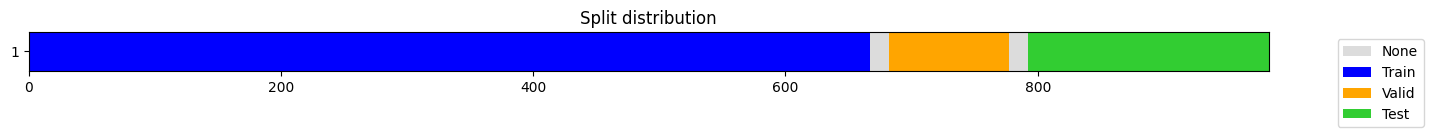

[W 2024-11-05 01:16:03,471] Trial 927 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:03,471] Trial 927 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


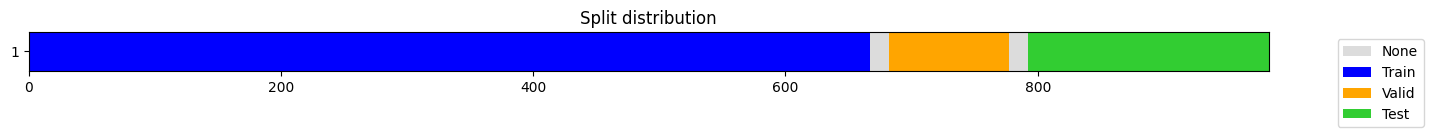

[W 2024-11-05 01:16:03,832] Trial 928 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:03,833] Trial 928 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


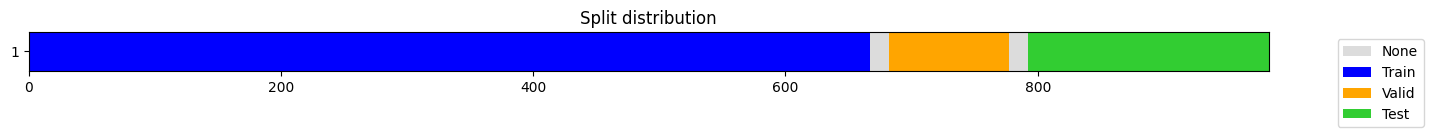

[W 2024-11-05 01:16:04,201] Trial 929 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:04,201] Trial 929 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


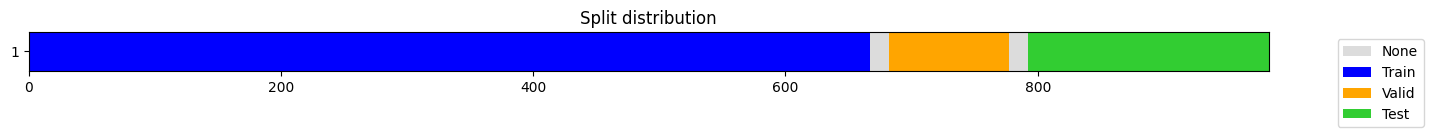

[W 2024-11-05 01:16:04,571] Trial 930 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:04,572] Trial 930 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


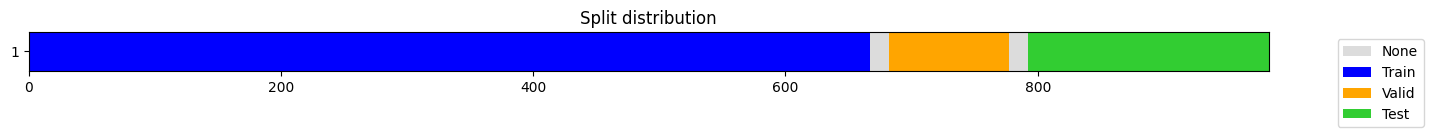

[W 2024-11-05 01:16:04,943] Trial 931 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:04,943] Trial 931 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


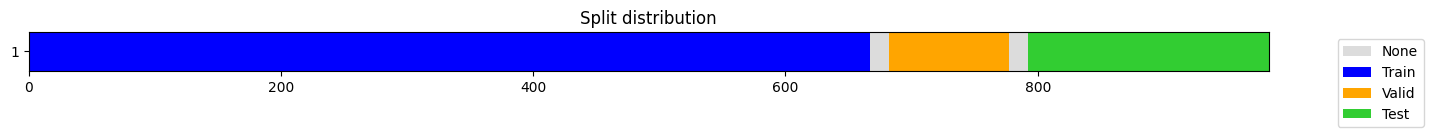

[W 2024-11-05 01:16:05,313] Trial 932 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:05,313] Trial 932 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


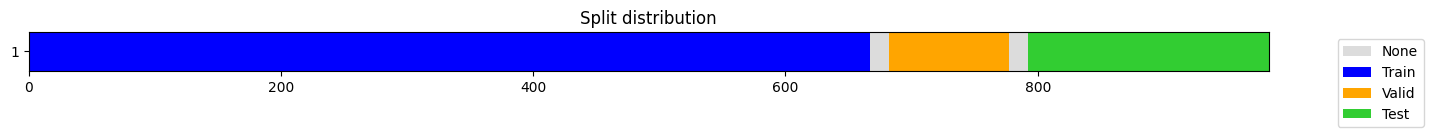

[W 2024-11-05 01:16:05,687] Trial 933 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:05,688] Trial 933 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


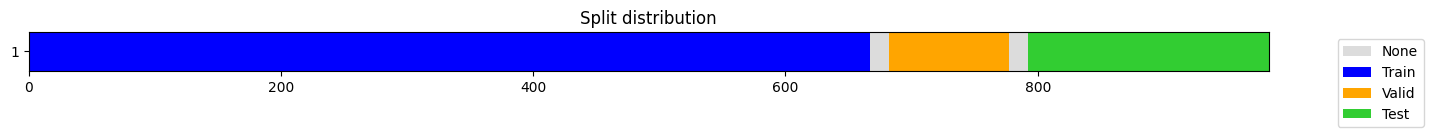

[W 2024-11-05 01:16:06,066] Trial 934 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:06,066] Trial 934 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


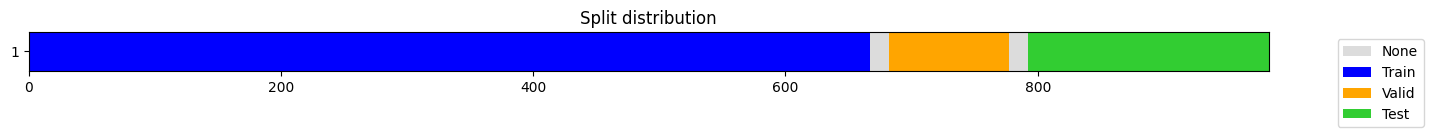

[W 2024-11-05 01:16:06,423] Trial 935 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:06,423] Trial 935 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


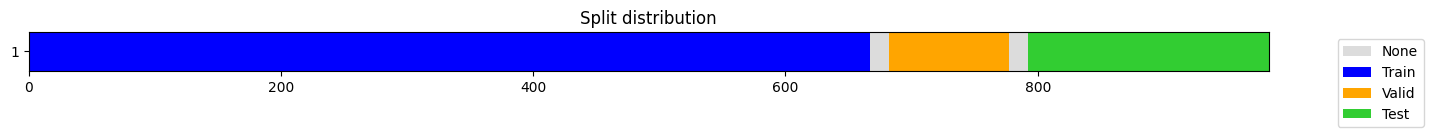

[W 2024-11-05 01:16:06,780] Trial 936 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:06,781] Trial 936 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


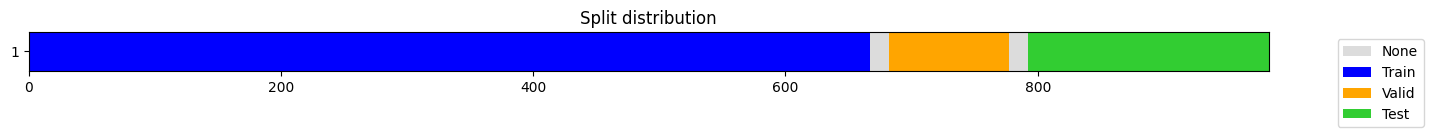

[W 2024-11-05 01:16:07,141] Trial 937 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:07,142] Trial 937 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


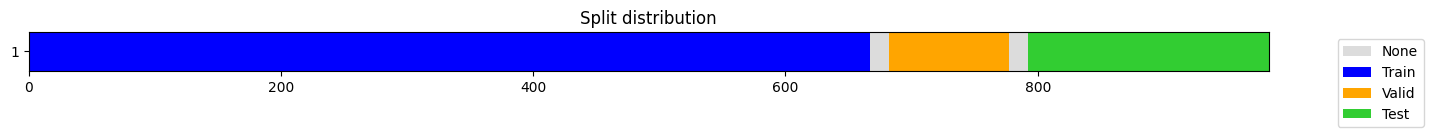

[W 2024-11-05 01:16:07,548] Trial 938 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:07,548] Trial 938 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


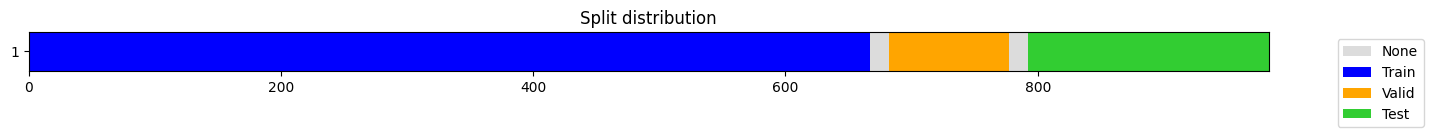

[W 2024-11-05 01:16:07,949] Trial 939 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:07,950] Trial 939 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


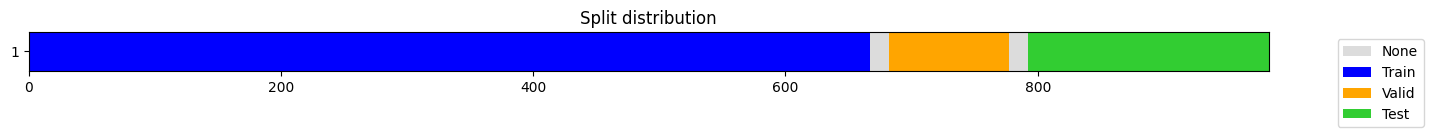

[W 2024-11-05 01:16:08,317] Trial 940 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 168, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:08,318] Trial 940 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


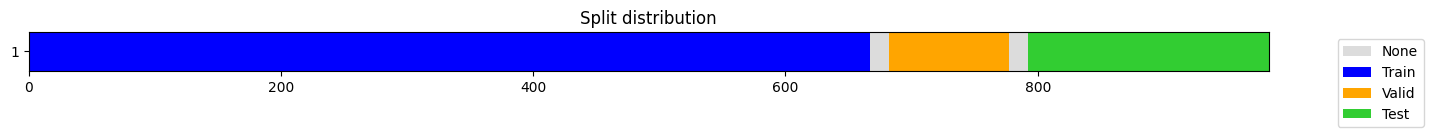

[W 2024-11-05 01:16:08,688] Trial 941 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:08,689] Trial 941 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


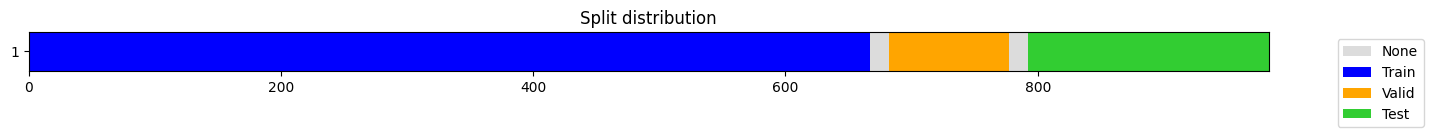

[W 2024-11-05 01:16:09,060] Trial 942 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:09,060] Trial 942 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


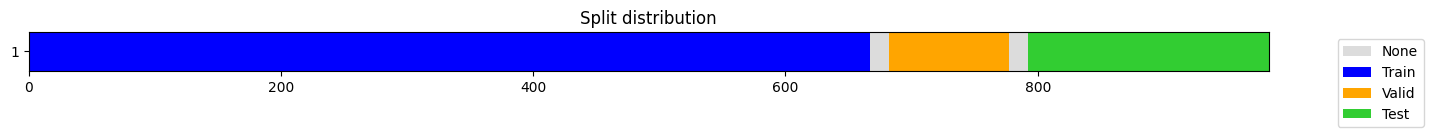

[W 2024-11-05 01:16:09,443] Trial 943 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:09,444] Trial 943 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


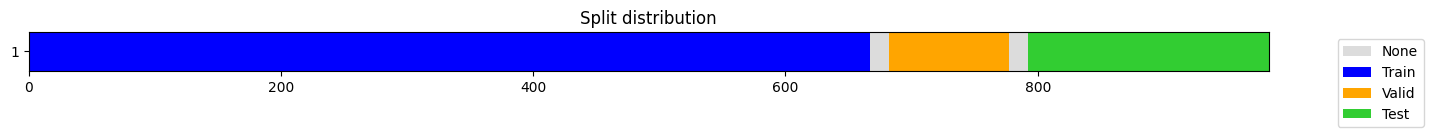

[W 2024-11-05 01:16:09,906] Trial 944 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:09,907] Trial 944 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


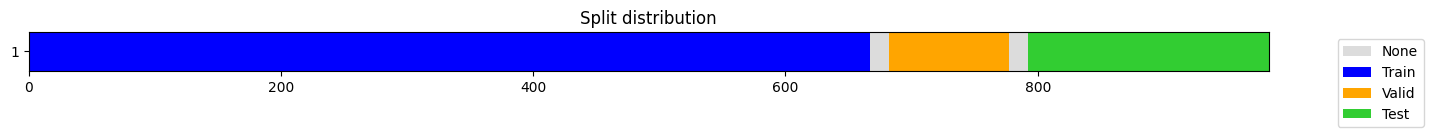

[W 2024-11-05 01:16:10,267] Trial 945 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:10,268] Trial 945 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


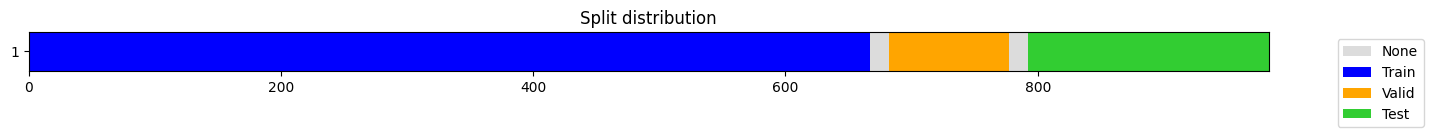

[W 2024-11-05 01:16:10,640] Trial 946 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:10,641] Trial 946 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


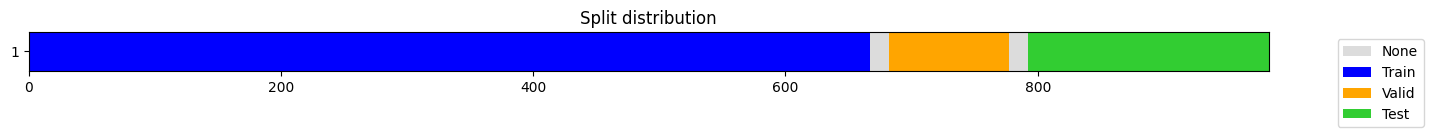

[W 2024-11-05 01:16:10,998] Trial 947 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:10,998] Trial 947 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


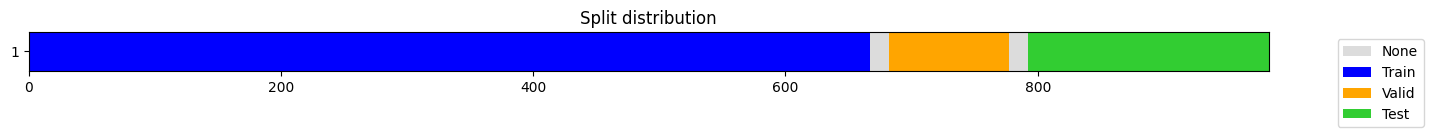

[W 2024-11-05 01:16:11,358] Trial 948 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:11,359] Trial 948 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


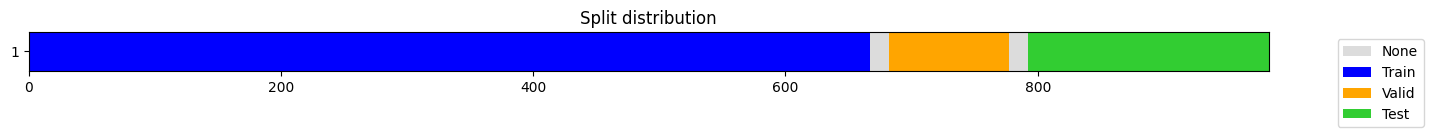

[W 2024-11-05 01:16:11,710] Trial 949 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:11,710] Trial 949 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


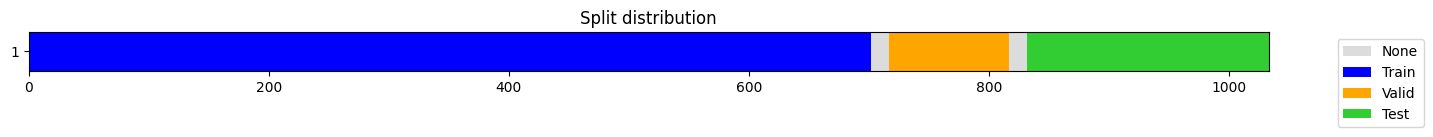

[W 2024-11-05 01:16:12,094] Trial 950 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:12,095] Trial 950 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


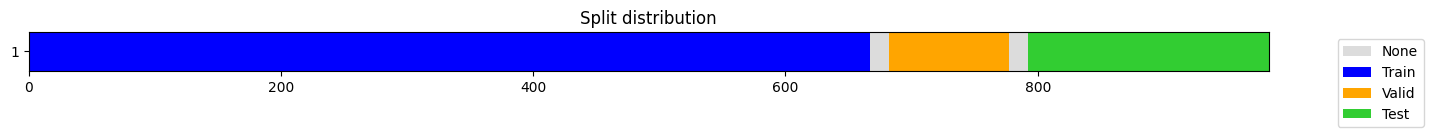

[W 2024-11-05 01:16:12,460] Trial 951 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:12,461] Trial 951 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


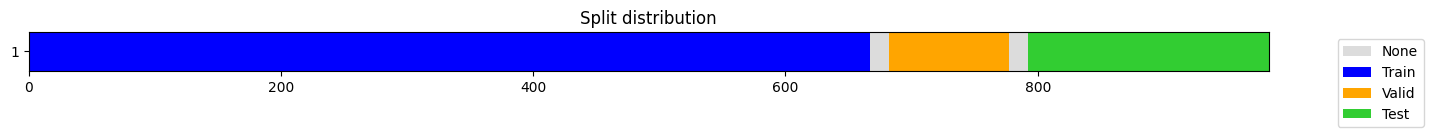

[W 2024-11-05 01:16:12,847] Trial 952 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:12,848] Trial 952 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


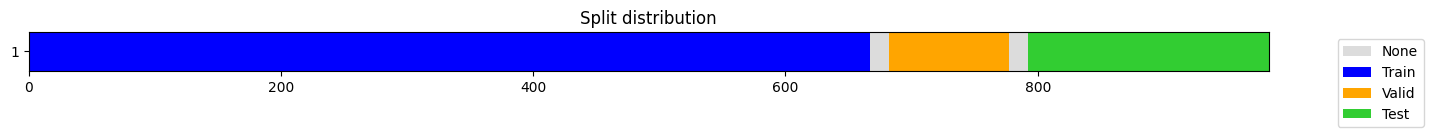

[W 2024-11-05 01:16:13,196] Trial 953 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 128, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:13,197] Trial 953 failed with value None.


Study failed because d_model (128) must be divisible by n_heads (6).


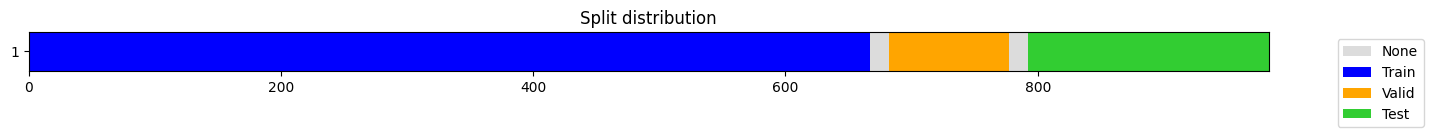

[W 2024-11-05 01:16:13,559] Trial 954 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:13,559] Trial 954 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


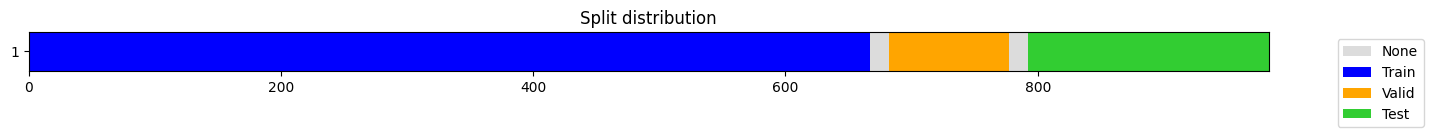

[W 2024-11-05 01:16:13,922] Trial 955 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:13,922] Trial 955 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


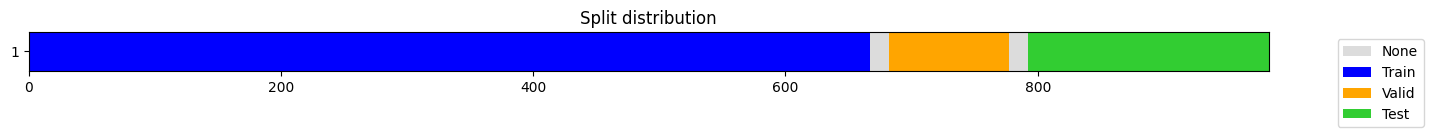

[W 2024-11-05 01:16:14,281] Trial 956 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:14,282] Trial 956 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


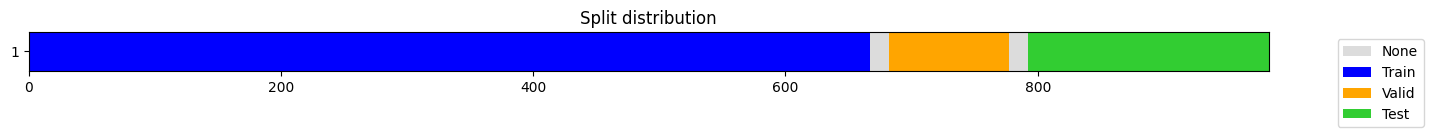

[W 2024-11-05 01:16:14,699] Trial 957 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:14,700] Trial 957 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


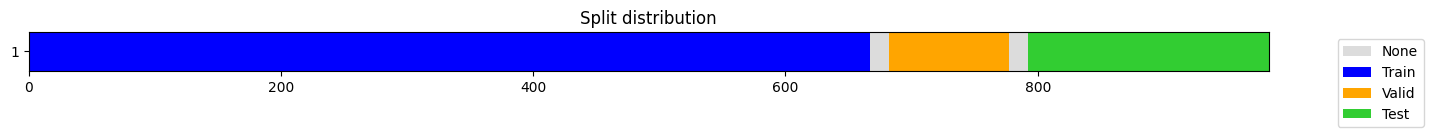

[W 2024-11-05 01:16:15,054] Trial 958 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:15,054] Trial 958 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


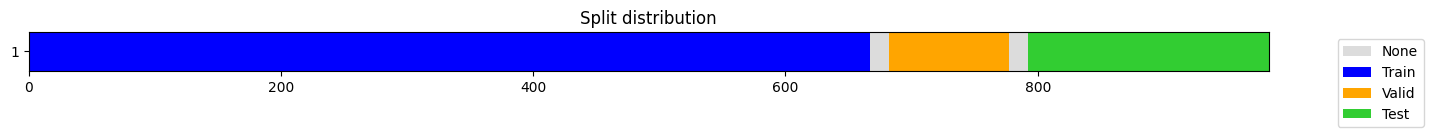

[W 2024-11-05 01:16:15,399] Trial 959 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:15,399] Trial 959 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


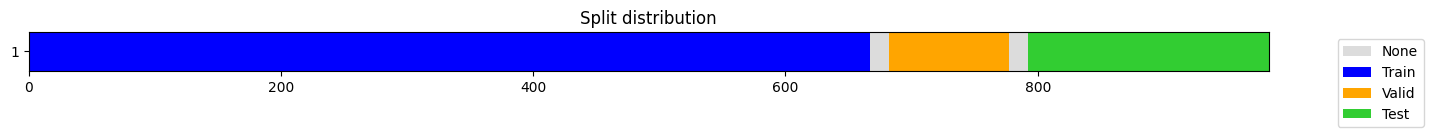

[W 2024-11-05 01:16:15,766] Trial 960 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:15,766] Trial 960 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


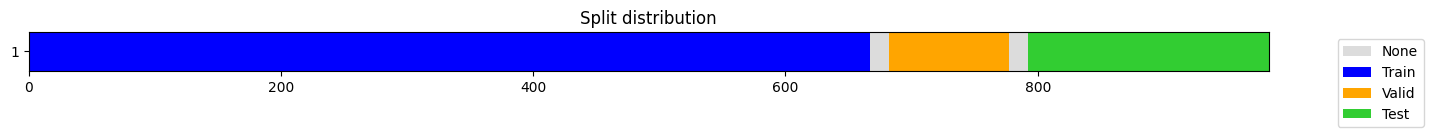

[W 2024-11-05 01:16:16,121] Trial 961 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:16,122] Trial 961 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


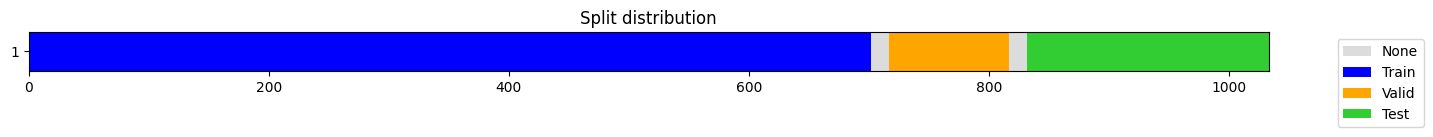

[W 2024-11-05 01:16:16,485] Trial 962 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:16,486] Trial 962 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


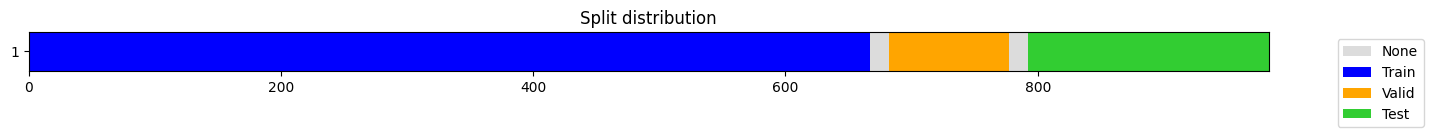

[W 2024-11-05 01:16:16,839] Trial 963 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:16,840] Trial 963 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


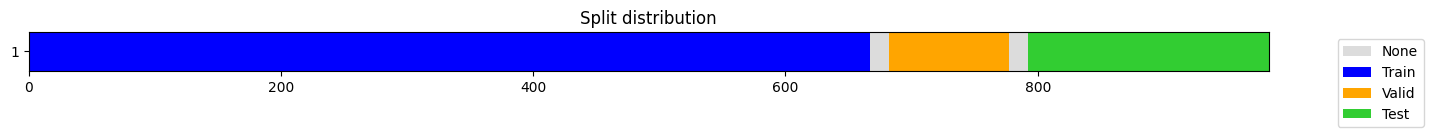

[W 2024-11-05 01:16:17,207] Trial 964 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:17,208] Trial 964 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


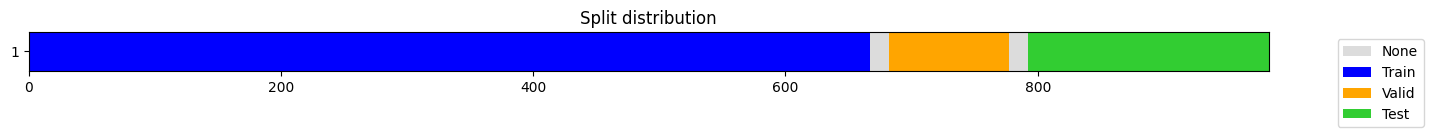

[W 2024-11-05 01:16:17,567] Trial 965 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:17,568] Trial 965 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


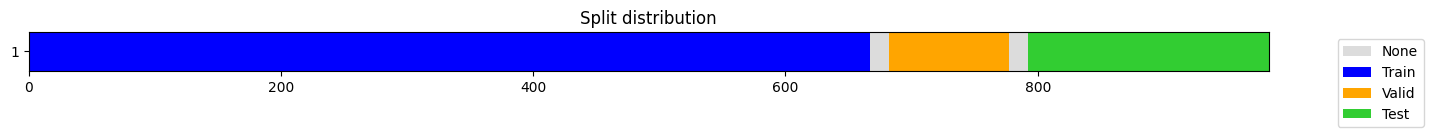

[W 2024-11-05 01:16:17,935] Trial 966 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:17,936] Trial 966 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


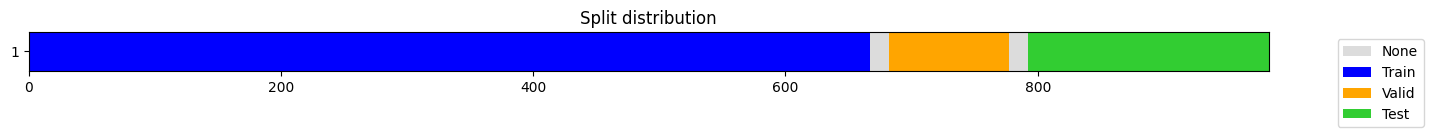

[W 2024-11-05 01:16:18,293] Trial 967 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:18,293] Trial 967 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


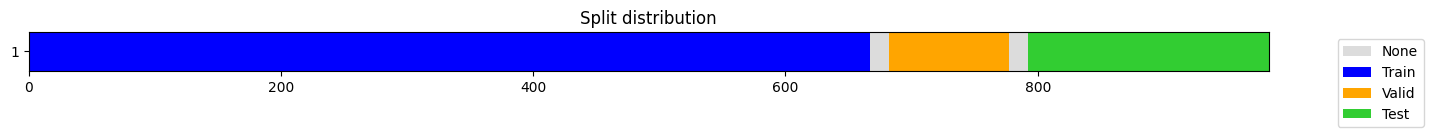

[W 2024-11-05 01:16:18,659] Trial 968 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:18,660] Trial 968 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


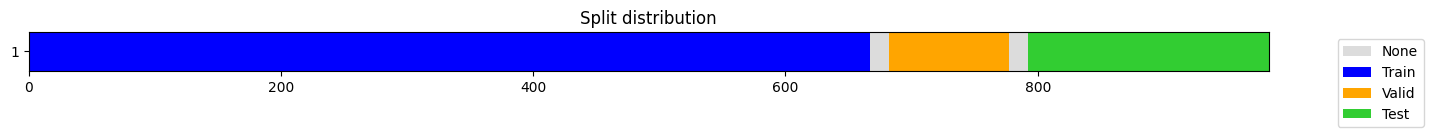

[W 2024-11-05 01:16:19,027] Trial 969 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 200, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:19,027] Trial 969 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


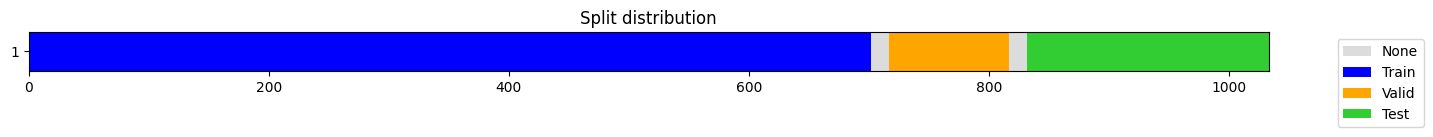

[W 2024-11-05 01:16:19,401] Trial 970 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:19,402] Trial 970 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


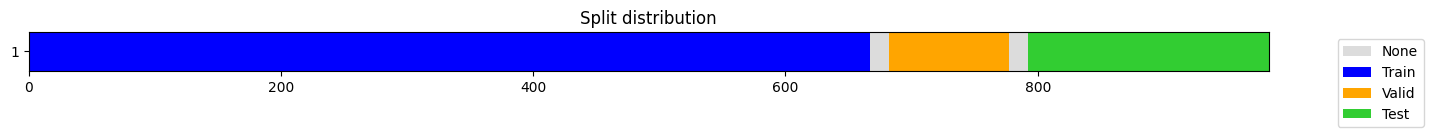

[W 2024-11-05 01:16:19,782] Trial 971 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:19,782] Trial 971 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


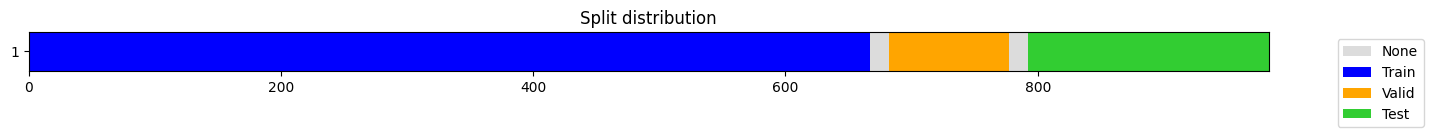

[W 2024-11-05 01:16:20,173] Trial 972 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:20,173] Trial 972 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


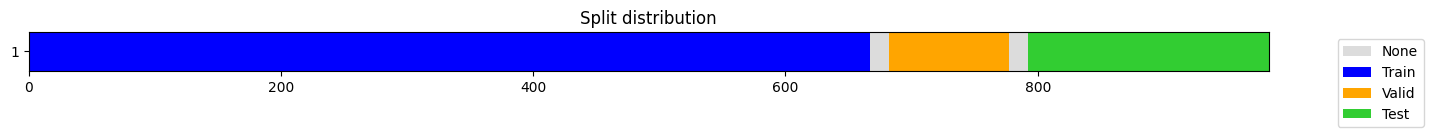

[W 2024-11-05 01:16:20,539] Trial 973 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 48, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:20,539] Trial 973 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


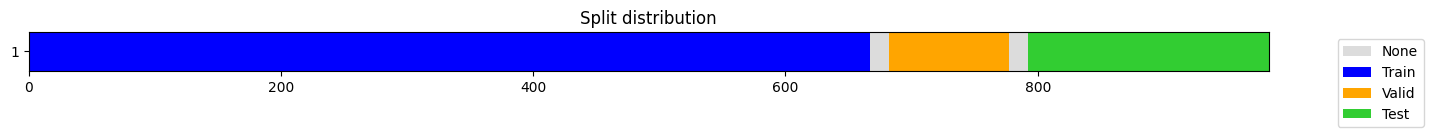

[W 2024-11-05 01:16:20,902] Trial 974 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:20,903] Trial 974 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


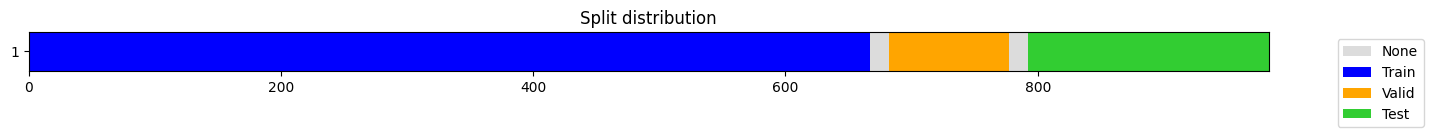

[W 2024-11-05 01:16:21,265] Trial 975 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:21,266] Trial 975 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


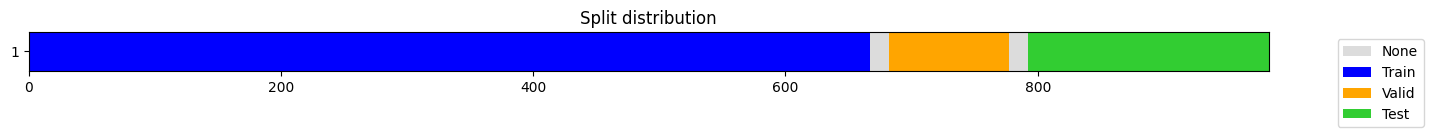

[W 2024-11-05 01:16:21,625] Trial 976 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:21,626] Trial 976 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


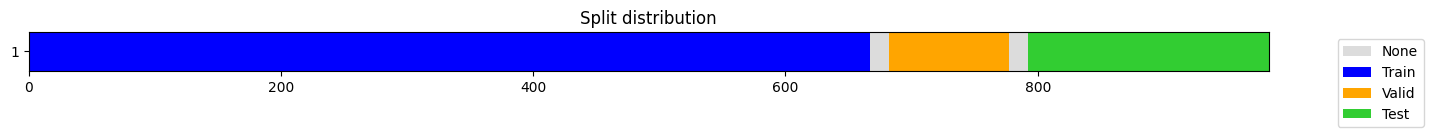

[W 2024-11-05 01:16:21,991] Trial 977 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:21,992] Trial 977 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


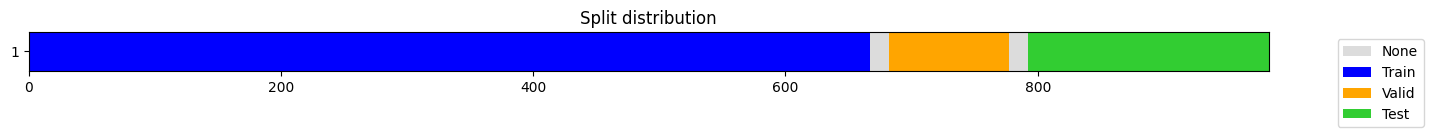

[W 2024-11-05 01:16:22,355] Trial 978 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:22,356] Trial 978 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


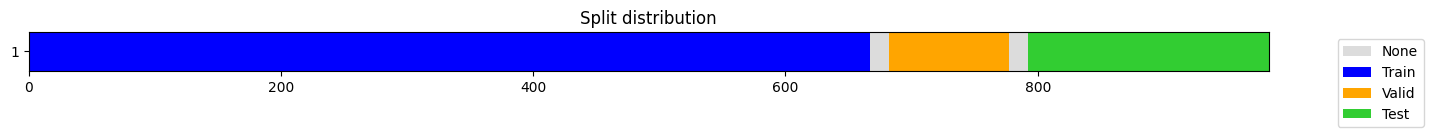

[W 2024-11-05 01:16:22,722] Trial 979 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:22,722] Trial 979 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


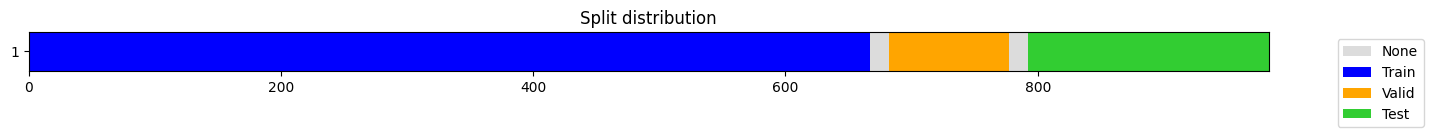

[W 2024-11-05 01:16:23,076] Trial 980 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:23,076] Trial 980 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


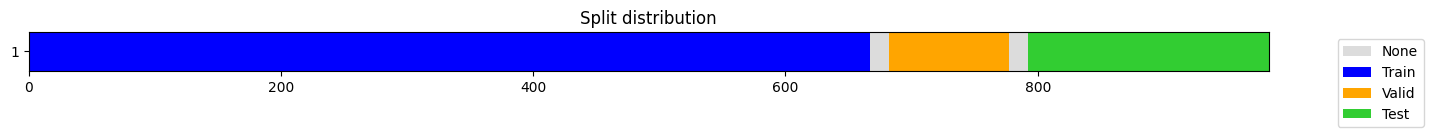

[W 2024-11-05 01:16:23,434] Trial 981 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:23,435] Trial 981 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


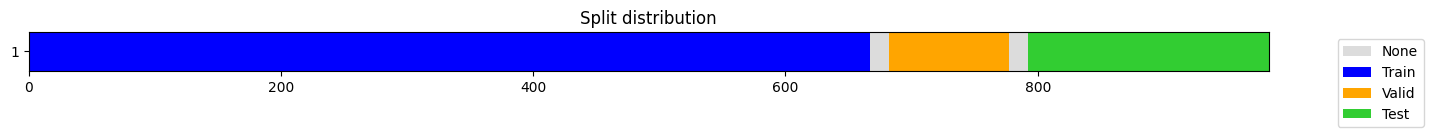

[W 2024-11-05 01:16:23,801] Trial 982 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 3} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:23,802] Trial 982 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


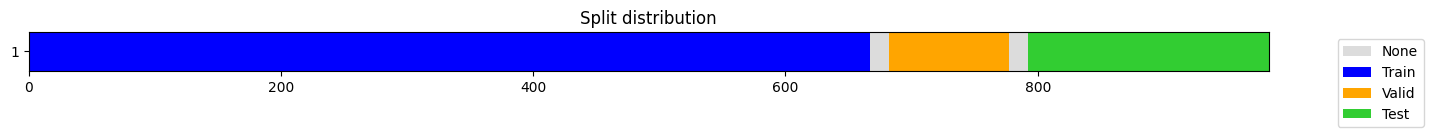

[W 2024-11-05 01:16:24,157] Trial 983 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 3} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:24,157] Trial 983 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


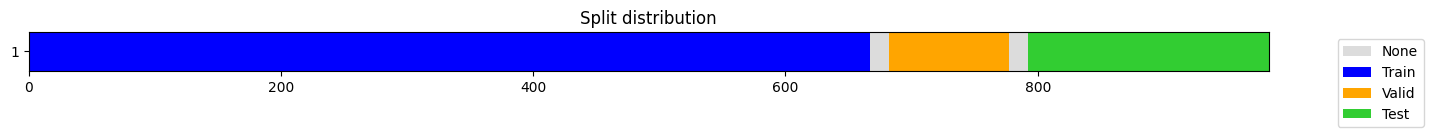

[W 2024-11-05 01:16:24,540] Trial 984 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:24,540] Trial 984 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


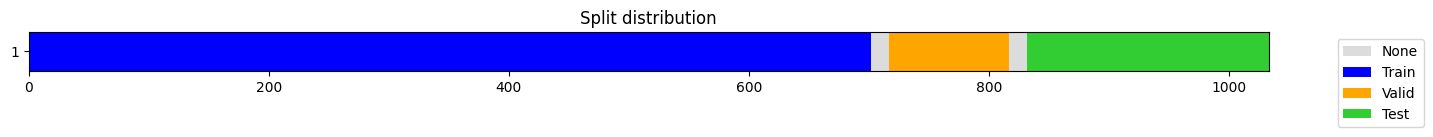

[W 2024-11-05 01:16:24,910] Trial 985 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:24,910] Trial 985 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


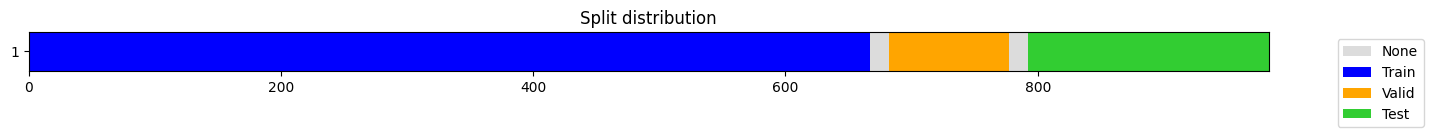

[W 2024-11-05 01:16:25,274] Trial 986 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:25,274] Trial 986 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


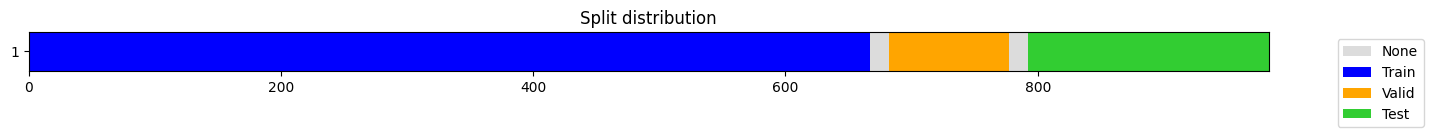

[W 2024-11-05 01:16:25,663] Trial 987 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:25,664] Trial 987 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


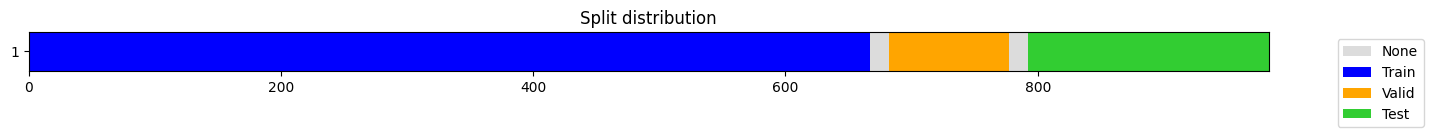

[W 2024-11-05 01:16:26,033] Trial 988 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:26,033] Trial 988 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


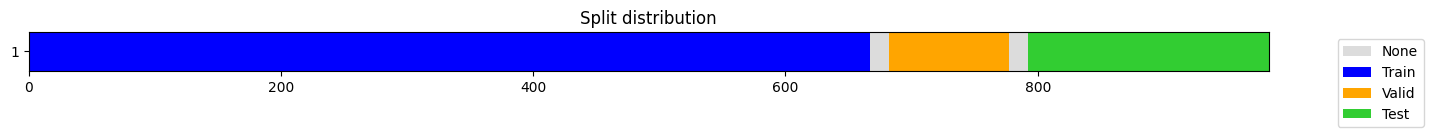

[W 2024-11-05 01:16:26,426] Trial 989 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:26,427] Trial 989 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


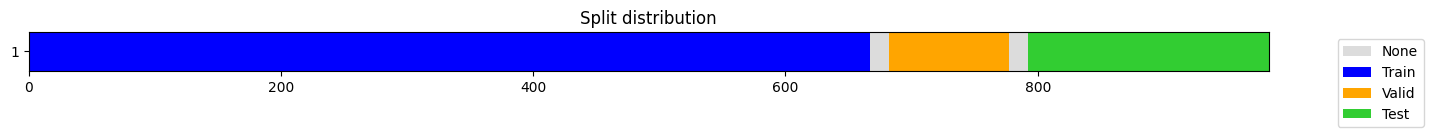

[W 2024-11-05 01:16:26,794] Trial 990 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:26,795] Trial 990 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


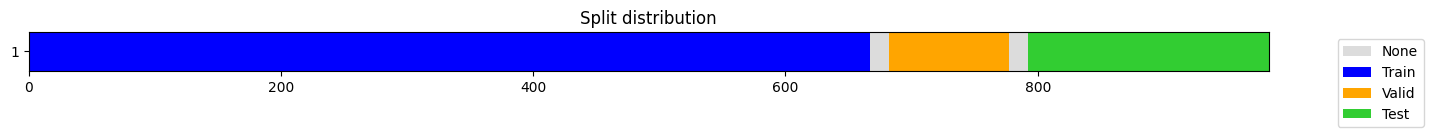

[W 2024-11-05 01:16:27,163] Trial 991 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:27,163] Trial 991 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


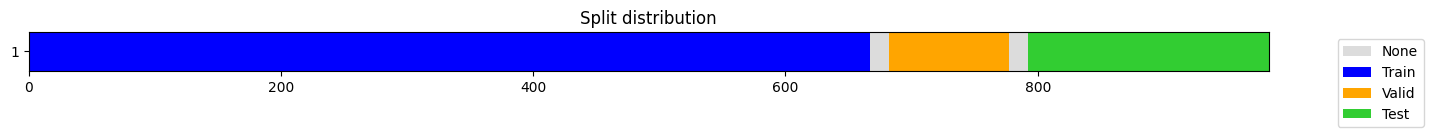

[W 2024-11-05 01:16:27,522] Trial 992 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:27,522] Trial 992 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


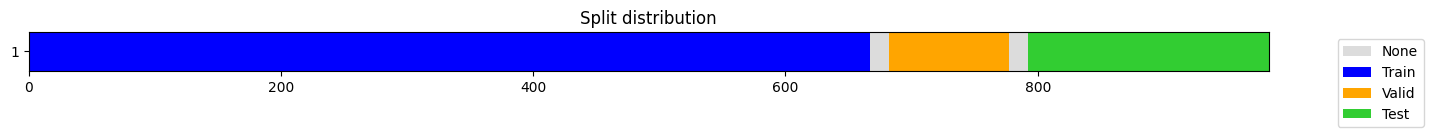

[W 2024-11-05 01:16:27,875] Trial 993 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:27,876] Trial 993 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


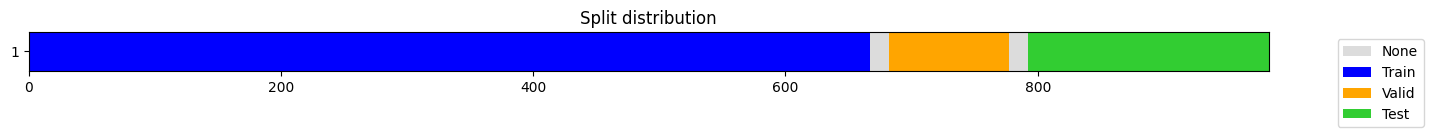

[W 2024-11-05 01:16:28,243] Trial 994 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 200, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:28,244] Trial 994 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


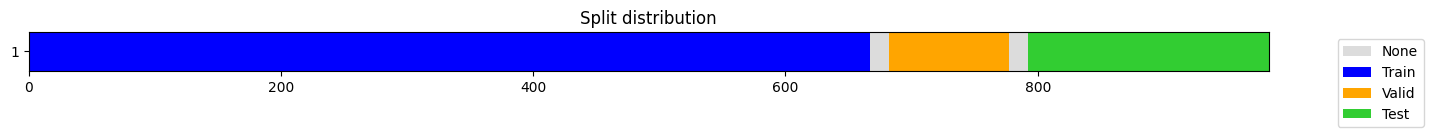

[W 2024-11-05 01:16:28,603] Trial 995 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:28,604] Trial 995 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


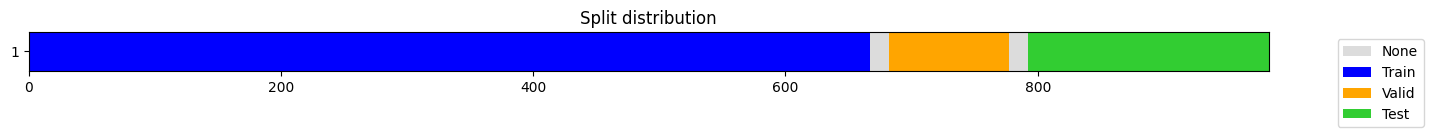

[W 2024-11-05 01:16:28,955] Trial 996 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:28,956] Trial 996 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


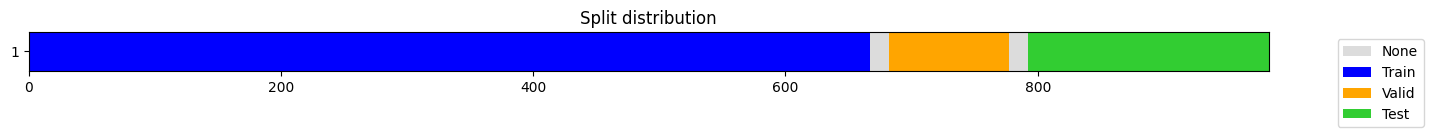

[W 2024-11-05 01:16:29,718] Trial 997 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:29,719] Trial 997 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


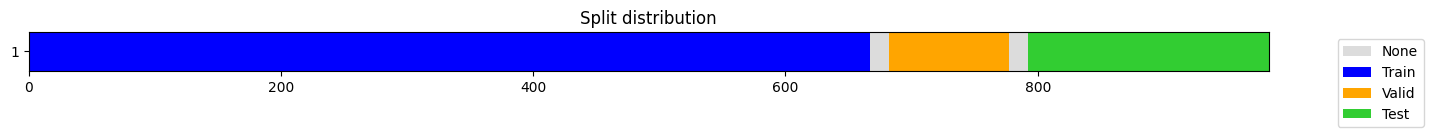

[W 2024-11-05 01:16:30,087] Trial 998 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 3} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:30,087] Trial 998 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


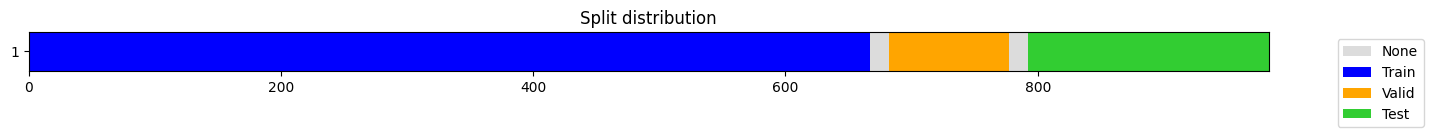

[W 2024-11-05 01:16:30,437] Trial 999 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.30000000000000004, 'dropout': 0.2, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:30,438] Trial 999 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


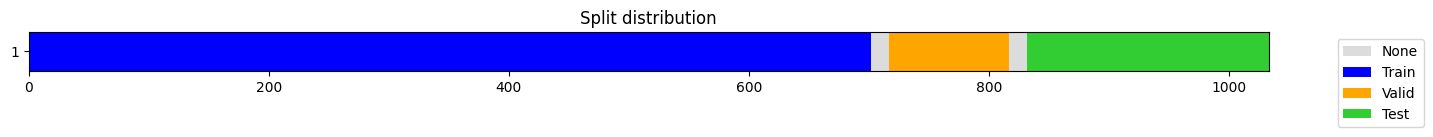

[W 2024-11-05 01:16:30,791] Trial 1000 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:30,791] Trial 1000 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


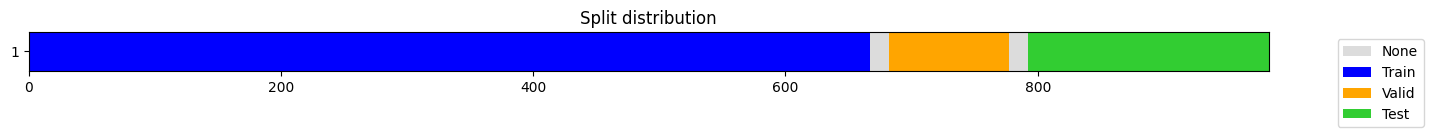

[W 2024-11-05 01:16:31,162] Trial 1001 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:31,162] Trial 1001 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


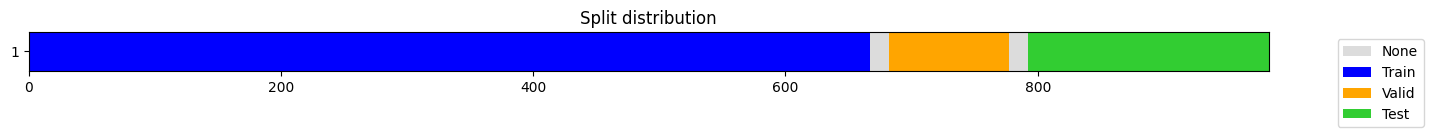

[W 2024-11-05 01:16:31,521] Trial 1002 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:31,521] Trial 1002 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


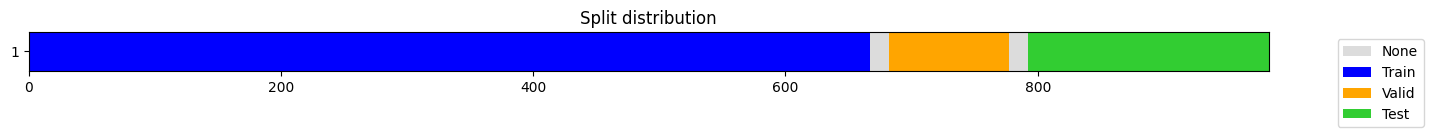

[W 2024-11-05 01:16:31,881] Trial 1003 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:31,882] Trial 1003 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


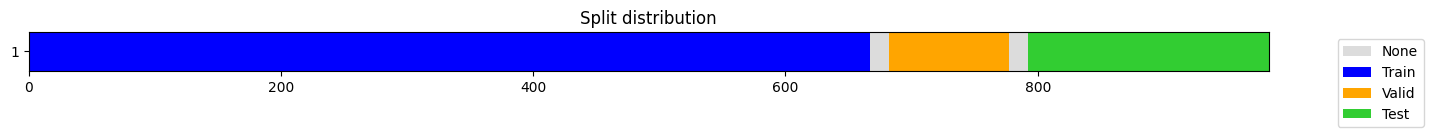

[W 2024-11-05 01:16:32,256] Trial 1004 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:32,256] Trial 1004 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


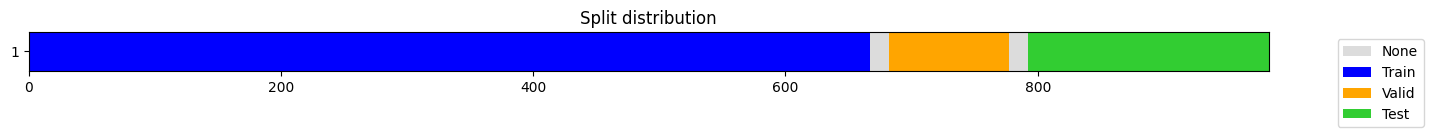

[W 2024-11-05 01:16:32,606] Trial 1005 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:32,606] Trial 1005 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


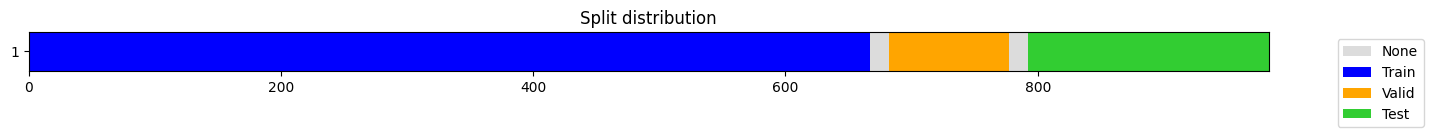

[W 2024-11-05 01:16:32,956] Trial 1006 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:32,956] Trial 1006 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


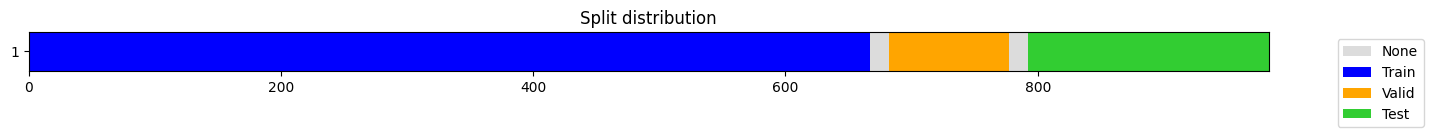

[W 2024-11-05 01:16:33,326] Trial 1007 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:33,327] Trial 1007 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


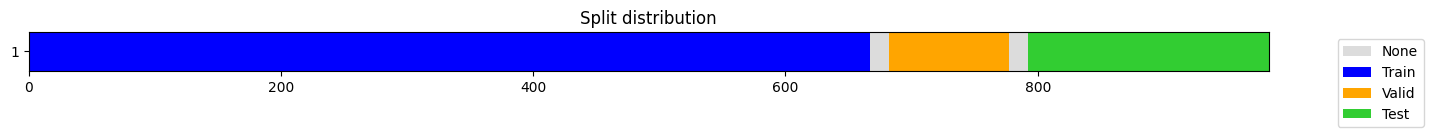

[W 2024-11-05 01:16:33,686] Trial 1008 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:33,687] Trial 1008 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


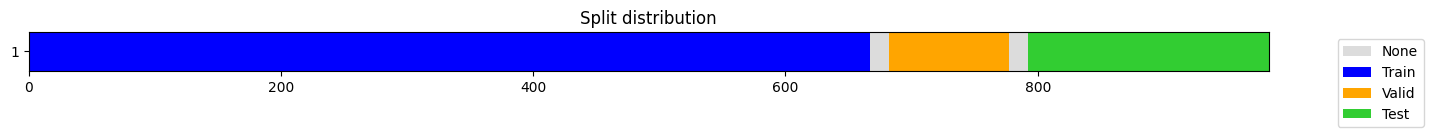

[W 2024-11-05 01:16:34,049] Trial 1009 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:34,049] Trial 1009 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


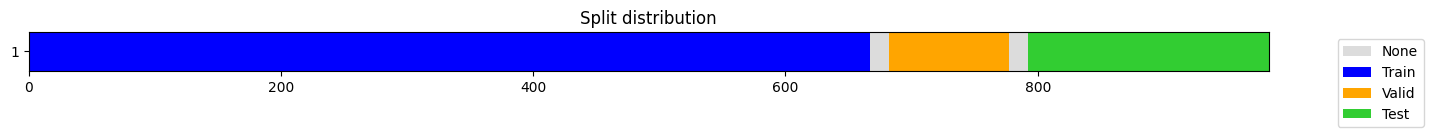

[W 2024-11-05 01:16:34,414] Trial 1010 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 168, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:34,415] Trial 1010 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


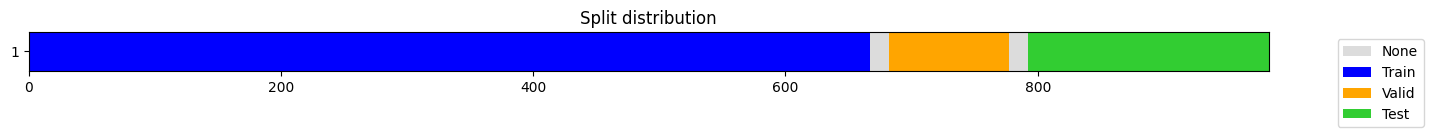

[W 2024-11-05 01:16:34,759] Trial 1011 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:34,759] Trial 1011 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


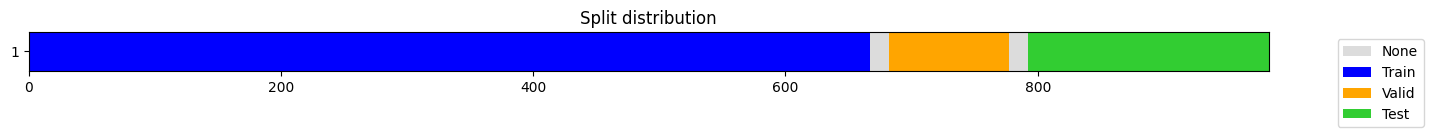

[W 2024-11-05 01:16:35,108] Trial 1012 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 11, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:35,109] Trial 1012 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


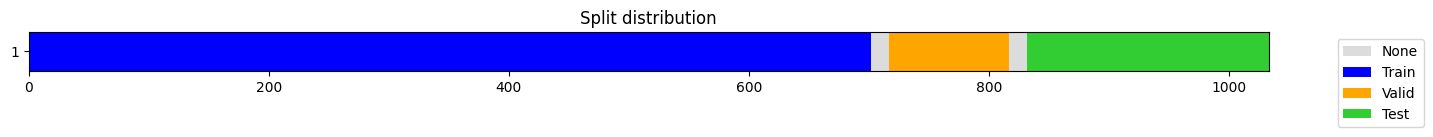

[W 2024-11-05 01:16:35,462] Trial 1013 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:35,463] Trial 1013 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


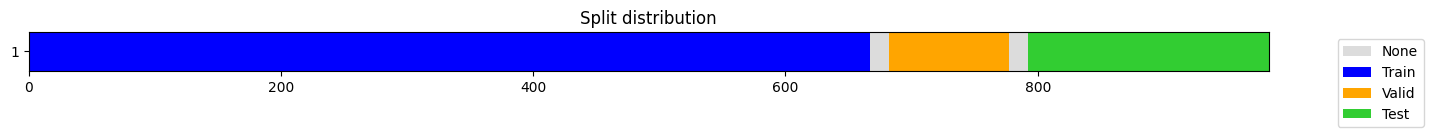

[W 2024-11-05 01:16:35,824] Trial 1014 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:35,824] Trial 1014 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


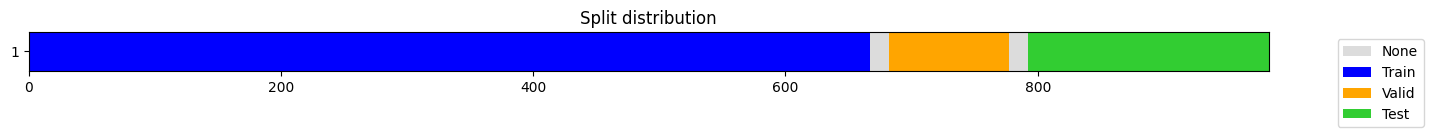

[W 2024-11-05 01:16:36,145] Trial 1015 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:36,145] Trial 1015 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


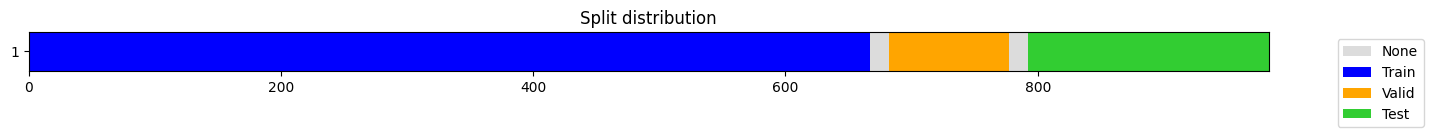

[W 2024-11-05 01:16:36,510] Trial 1016 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:36,511] Trial 1016 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


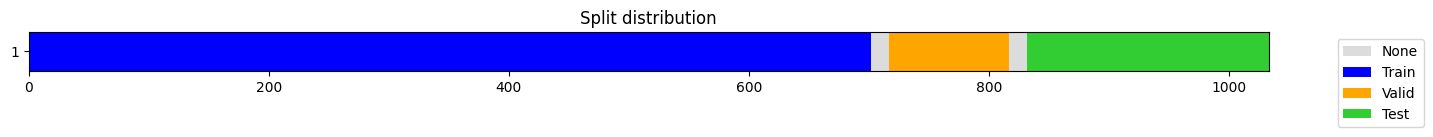

[W 2024-11-05 01:16:36,871] Trial 1017 failed with parameters: {'fcst_history': 350, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:36,872] Trial 1017 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


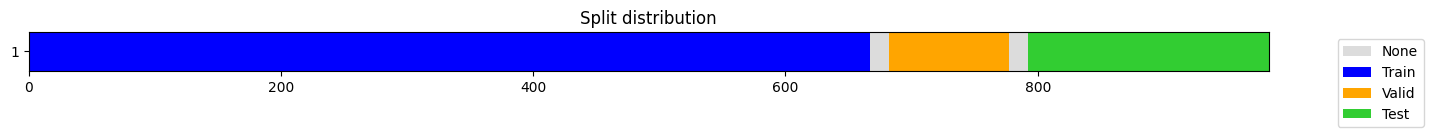

[W 2024-11-05 01:16:37,241] Trial 1018 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:37,241] Trial 1018 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


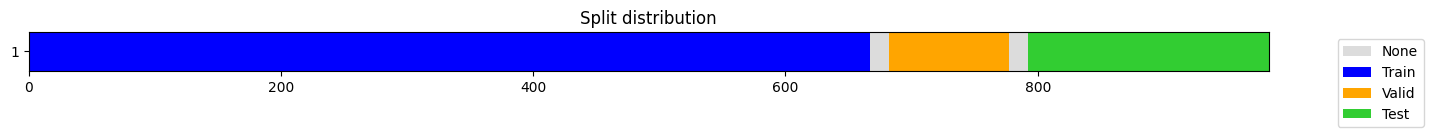

[W 2024-11-05 01:16:37,600] Trial 1019 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:37,600] Trial 1019 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


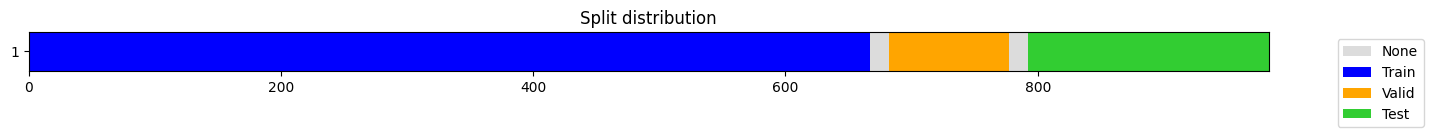

[W 2024-11-05 01:16:37,953] Trial 1020 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:37,954] Trial 1020 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


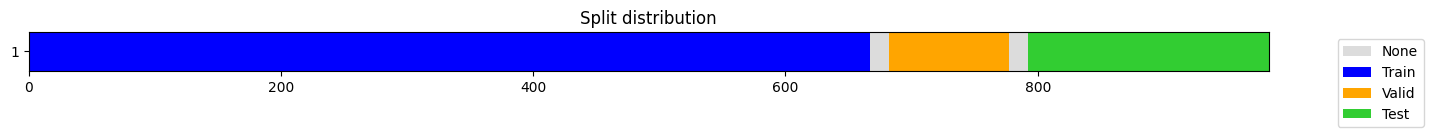

[W 2024-11-05 01:16:38,315] Trial 1021 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:38,315] Trial 1021 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


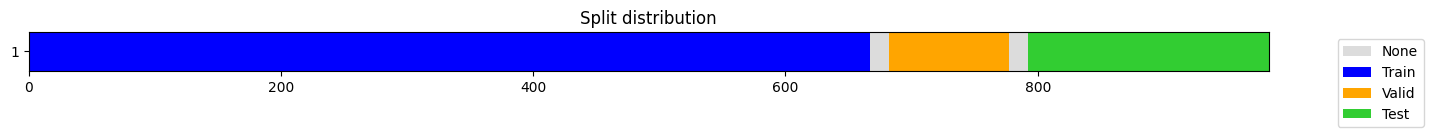

[W 2024-11-05 01:16:38,678] Trial 1022 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 32, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:38,679] Trial 1022 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


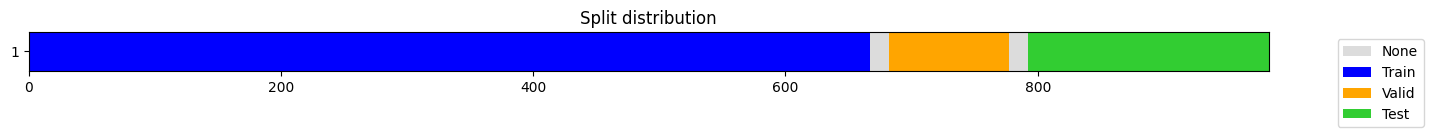

[W 2024-11-05 01:16:39,031] Trial 1023 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:39,032] Trial 1023 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


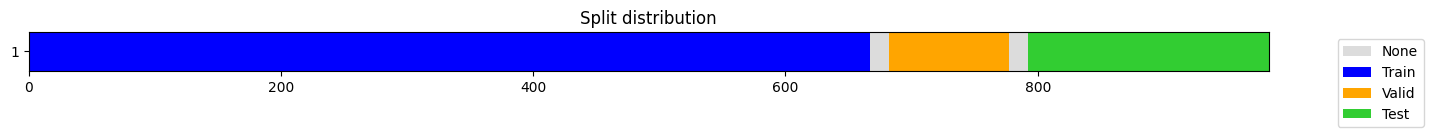

[W 2024-11-05 01:16:39,389] Trial 1024 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 112, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:39,390] Trial 1024 failed with value None.


Study failed because d_model (112) must be divisible by n_heads (6).


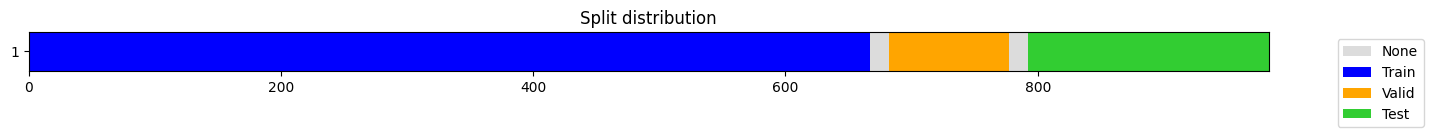

[W 2024-11-05 01:16:39,750] Trial 1025 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:39,750] Trial 1025 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


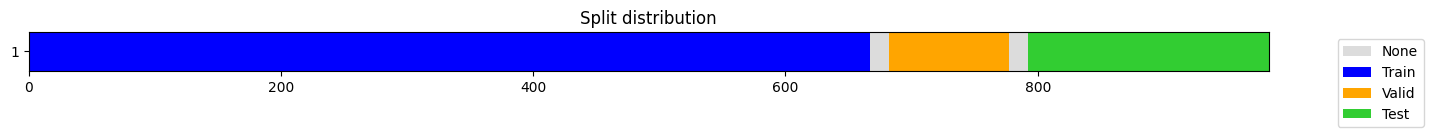

[W 2024-11-05 01:16:40,113] Trial 1026 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 192, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:40,114] Trial 1026 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


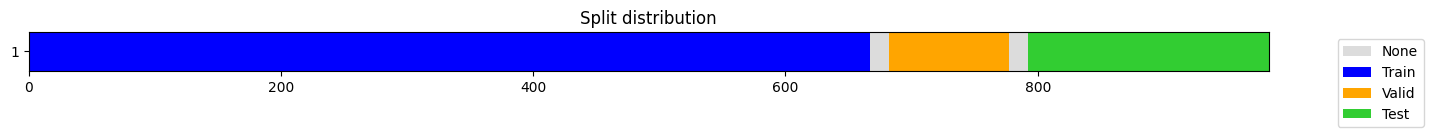

[W 2024-11-05 01:16:40,469] Trial 1027 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 184, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:40,469] Trial 1027 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


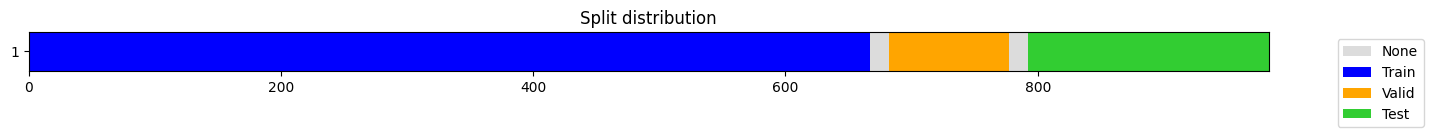

[W 2024-11-05 01:16:40,821] Trial 1028 failed with parameters: {'fcst_history': 400, 'fcst_horizon': 16, 'batch_size': 40, 'epochs': 10, 'n_layers': 6, 'n_heads': 6, 'd_model': 104, 'd_ff': 176, 'attn_dropout': 0.4, 'dropout': 0.30000000000000004, 'patch_len': 11, 'stride': 5} because of the following error: The value None could not be cast to float..
[W 2024-11-05 01:16:40,821] Trial 1028 failed with value None.


Study failed because d_model (104) must be divisible by n_heads (6).


['oil_price_patch.pkl']

In [57]:
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(),
                            study_name='oil_price_patch',
                            storage='sqlite:///oil_price_patch.db', 
                            load_if_exists=True)

study.optimize(objective, n_trials=200)
joblib.dump(study, "oil_price_patch.pkl")

In [54]:
joblib.dump(study, "oil_price_patch.pkl")

['oil_price_patch.pkl']

In [58]:
print("Number of trials:", len(study.trials))
 

Number of trials: 1029


In [59]:
study

In [19]:
study = joblib.load("oil_price_patch.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.07396565575092504
 Params: 
    fcst_history: 50
    fcst_horizon: 16
    batch_size: 20
    epochs: 14
    n_layers: 4
    n_heads: 2
    d_model: 112
    d_ff: 224
    attn_dropout: 0.2
    dropout: 0.30000000000000004
    patch_len: 11
    stride: 2


# Final Model

In [20]:
HPs = study.best_trial.params

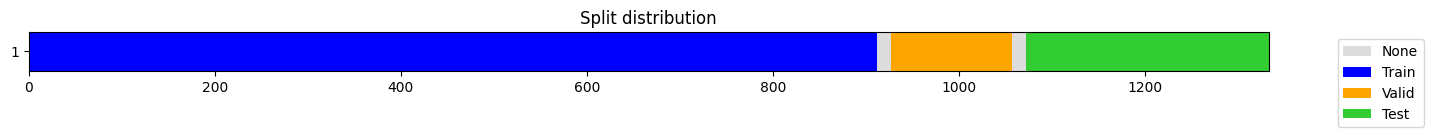

In [44]:
  datetime_col = 'date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = HPs['fcst_horizon']
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)




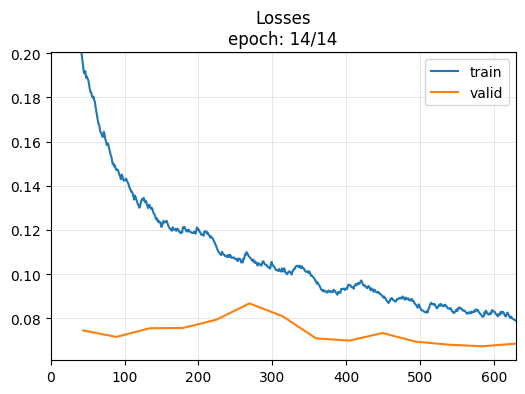

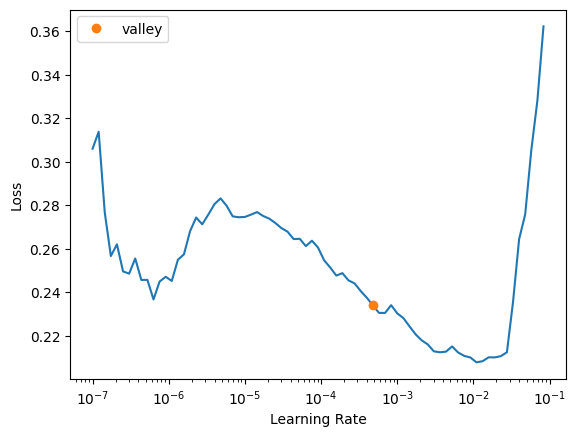

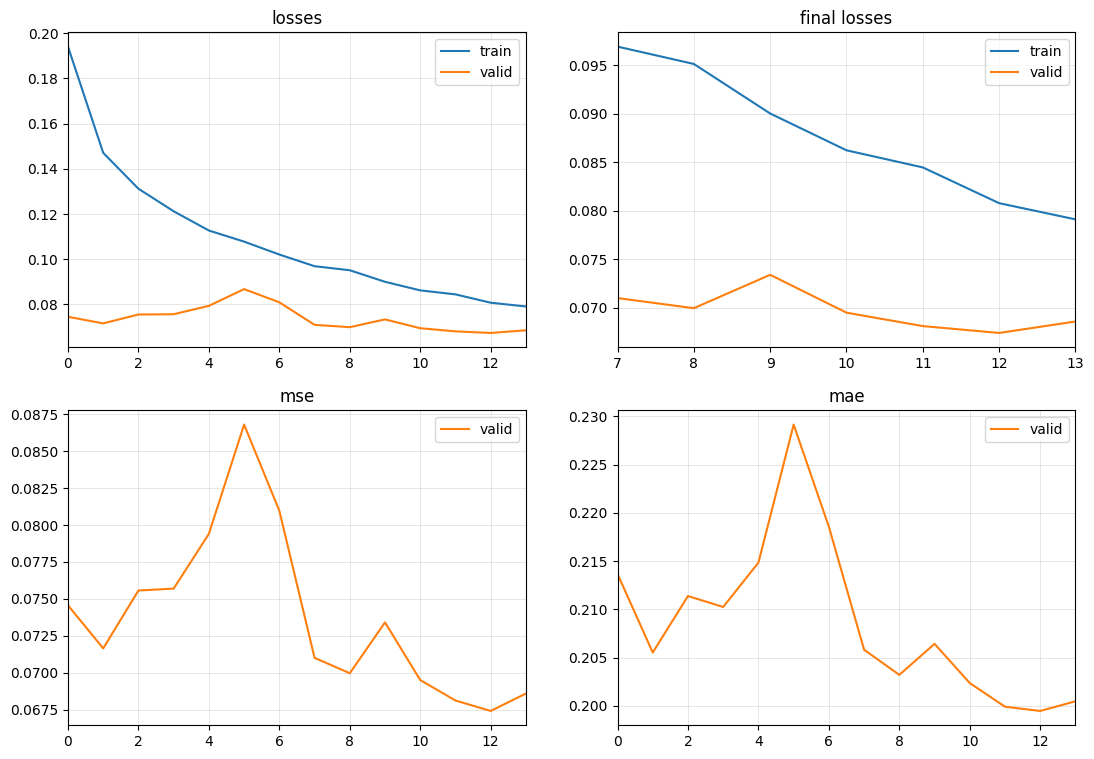

In [45]:
   

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'], lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
  



In [46]:
learn = load_learner('patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(x[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
loss = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())

results_df

scaled_preds.shape: (130, 1, 16)


mse       mae
valid  0.068585  0.200477

In [47]:
learn = load_learner('patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(x[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df






y_test_preds.shape: (261, 1, 16)


mse       mae
test  0.044023  0.170001

In [48]:

x_test = x[splits[2]]
y_test = y[splits[2]]


inverse_scale_y_preds = scaler.inverse_transform(y_test_preds.reshape(-1, 1)).flatten().reshape(261, 1, 16)
inverse_scale_y_true = (scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()).reshape(261, 1, 16)
inverse_scale_x_test = scaler.inverse_transform(x_test.reshape(-1, 1)).flatten().reshape(261, 1, 50)

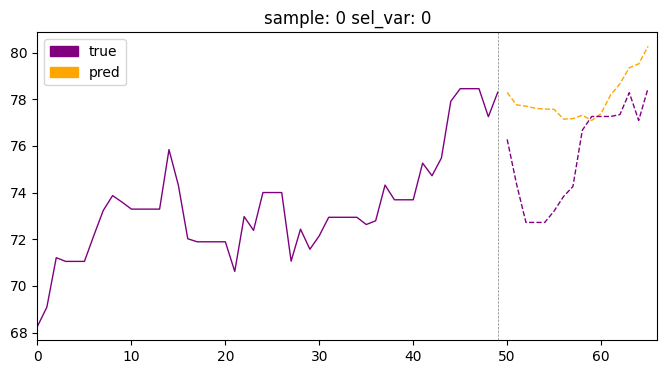

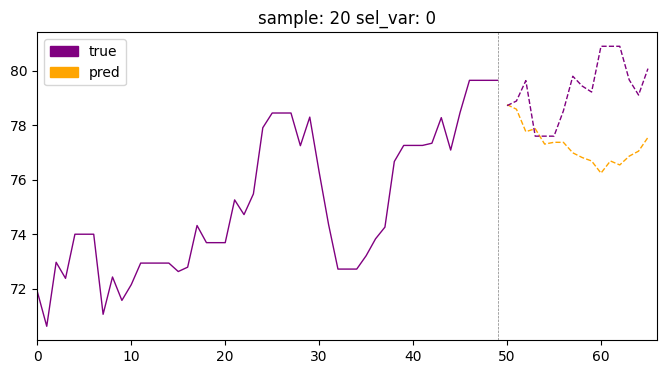

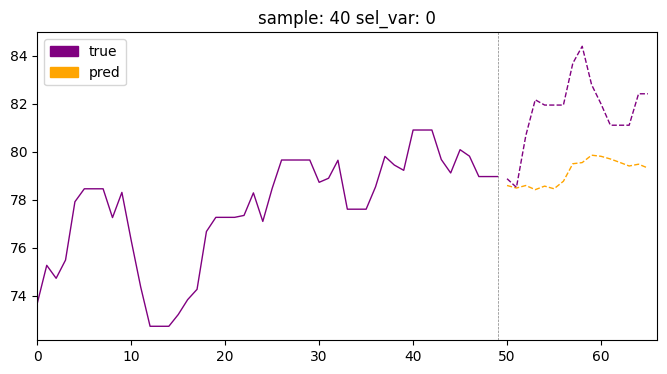

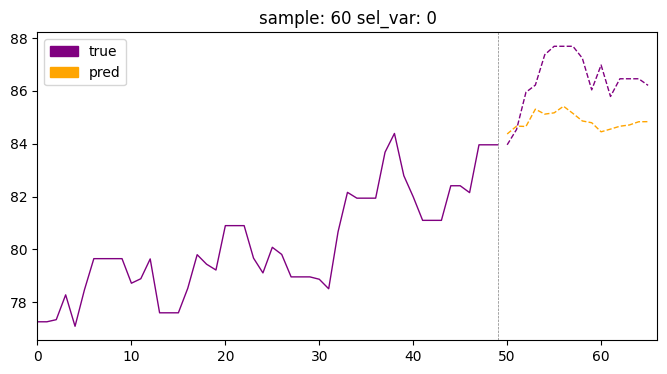

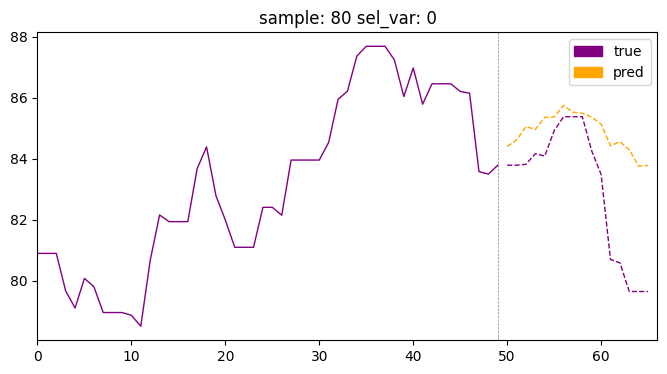

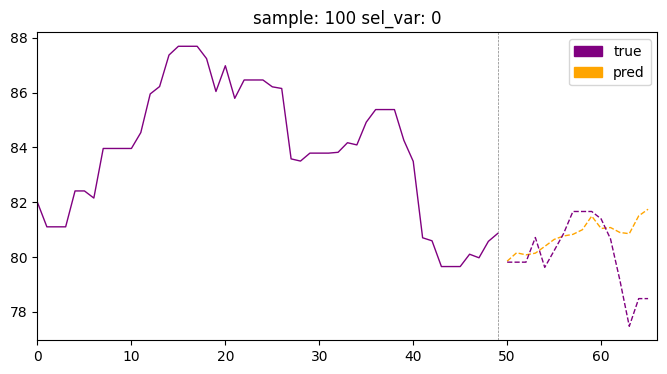

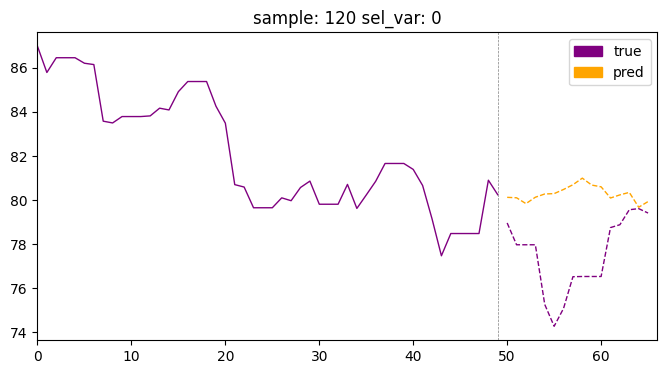

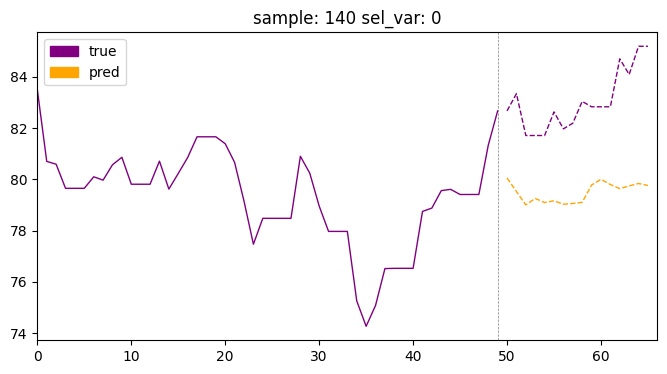

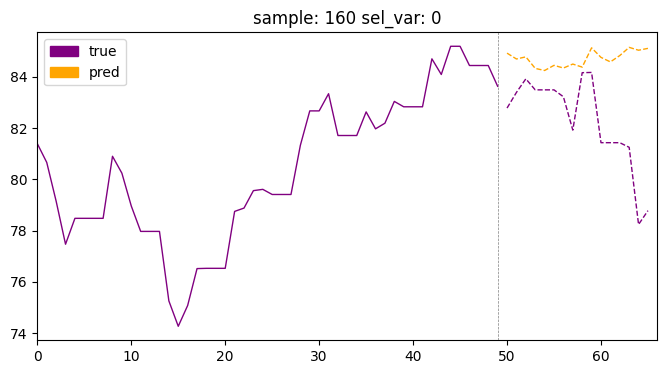

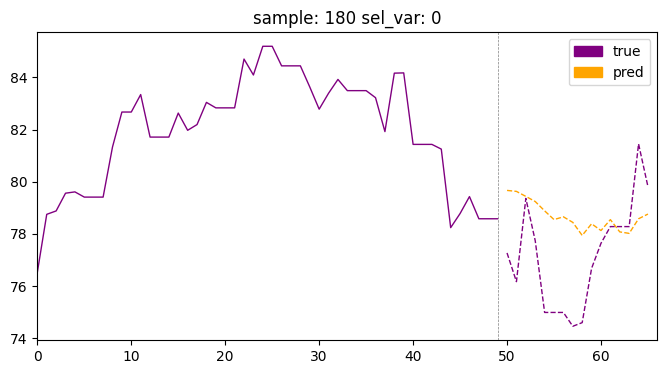

In [49]:
for id in range (0,200, 20):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [50]:
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
y_test_preds = torch.tensor(y_test_preds)



y_preds_one = y_test_preds[:, 0, 0]
y_true_one = y_test[:, 0, 0]

y_preds_last = y_test_preds[-1, 0, 1:]
y_true_last = y_test[-1, 0, 1:]

y_preds_appended = torch.cat((y_preds_one, y_preds_last))
y_true_appended = torch.cat((y_true_one, y_true_last))

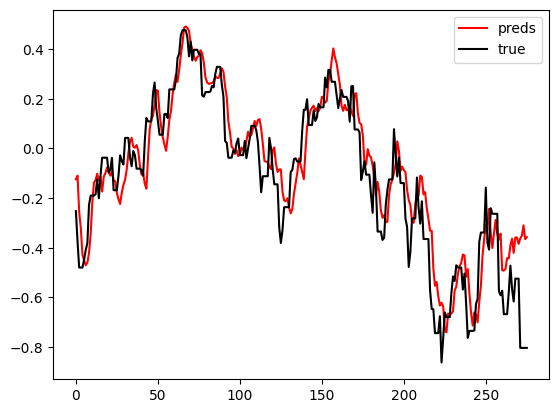

In [51]:
plt.plot(y_preds_appended, c = 'r', label = 'preds')
plt.plot(y_true_appended, c = 'k', label = 'true')
plt.legend()

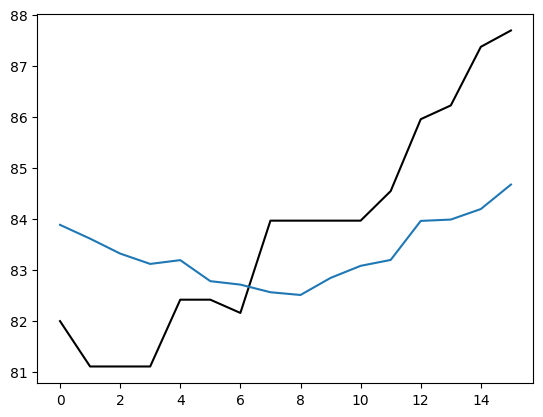

In [57]:
plt.plot(inverse_scale_y_true[50, 0, :], c = 'k')
plt.plot(inverse_scale_y_preds[50, 0, :])

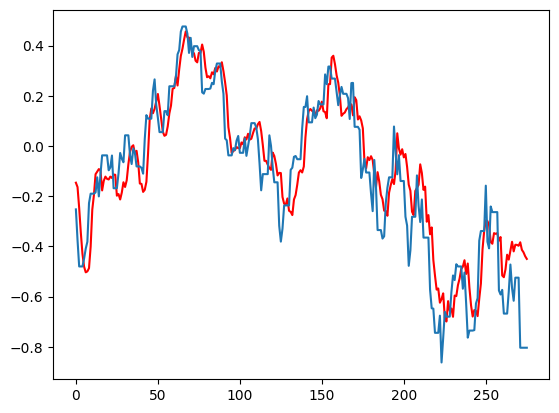

In [43]:
y_preds_tensor = torch.tensor(y_test_preds)


y_test = y[splits[2]]
y_test_tensor = torch.tensor(y_test)

append_preds = y_preds_tensor[-1, 0, 1:]
append_preds

append_true = y_test_tensor[-1, 0, 1:]


first_preds = y_preds_tensor[:, 0, 0]

first_true = y_test_tensor[:, 0, 0]

first_preds_with_final = torch.cat((first_preds, append_preds))

first_true_with_final = torch.cat((first_true, append_true))

plt.plot(first_preds_with_final, c = 'r')
plt.plot(first_true_with_final)

# Optuna Large

## Tuning

In [12]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    fcst_history = trial.suggest_int("fcst_history", 16, 128, step=16)
    n_heads = trial.suggest_int("n_heads", 1, 4, step=1)
    d_model = trial.suggest_int("d_model", 16, 128, step=8)
    patch_len = trial.suggest_int("patch_len", 0, fcst_history, step=16)
    
    # Prune trial if d_model is not divisible by n_heads
    if d_model % n_heads != 0:
        print(f"Pruning trial: d_model ({d_model}) is not divisible by n_heads ({n_heads})")
        raise optuna.exceptions.TrialPruned()
    
    # Prune trial if patch_len is greater than fcst_history
    if patch_len > fcst_history:
        print(f"Pruning trial: patch_len ({patch_len}) is greater than fcst_history ({fcst_history})")
        raise optuna.exceptions.TrialPruned()

    if patch_len == 0:
        print(f"Pruning trial: patch_len ({patch_len}) is greater than fcst_history ({fcst_history})")
        raise optuna.exceptions.TrialPruned()

    # Define other hyperparameters
    HPs = {
        'fcst_history': fcst_history,
        'batch_size': trial.suggest_int("batch_size", 8, 128, step=8),
        'epochs': trial.suggest_int("epochs", 5, 20, step=5),
        'n_layers': trial.suggest_int("n_layers", 1, 4, step=1),
        'n_heads': n_heads,
        'd_model': d_model,
        'd_ff': trial.suggest_int("d_ff", 16, 256, step=8),
        'attn_dropout': trial.suggest_float("attn_dropout", 0, 0.5, step=0.1),
        'dropout': trial.suggest_float("dropout", 0, 0.5, step=0.1),
        'stride': trial.suggest_int("stride", 1, 5, step=1),
        'patch_len': patch_len
    }

    # Your evaluation logic here
    try:
        loss = train_model(HPs)  # Replace with your training logic
        return loss
    except Exception as e:
        print(f"Trial failed: {e}")
        return None


In [13]:
def data_preparation(HPs):



  #setting basic params
  datetime_col = 'Date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = 96
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)

  return splits, x_tensor, y_tensor, x, y









In [14]:
def train_model(HPs):

    splits, x_tensor, y_tensor, x, y = data_preparation(HPs)

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae])

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'], lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
    learn = load_learner('patchTST.pt')
    scaled_preds, *_ = learn.get_X_preds(x[splits[1]])
    scaled_preds = to_np(scaled_preds)
    print(f"scaled_preds.shape: {scaled_preds.shape}")

    scaled_y_true = y[splits[1]]
    loss = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df = pd.DataFrame(columns=["mse", "mae"])
    results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())




  





    return loss











In [12]:
# study = optuna.create_study(direction="minimize",
#                             sampler=optuna.samplers.TPESampler(),
#                             study_name='patchtst_large_tune',
#                             storage='sqlite:///patchtst_large_tune.db', 
#                             load_if_exists=True)

# for i in range(50):
#     study.optimize(objective, n_trials=10)
#     joblib.dump(study, "patchtst_large_tune.pkl")

## Best Large Model

In [59]:
study = joblib.load("patchtst_large_tune.pkl")
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))


In [60]:
value = sorted_trials[0].value
print(value)
HPs = sorted_trials[0].params
HPs

0.19132562498486202


{'fcst_history': 48,
 'n_heads': 4,
 'd_model': 16,
 'patch_len': 32,
 'batch_size': 104,
 'epochs': 20,
 'n_layers': 1,
 'd_ff': 168,
 'attn_dropout': 0.4,
 'dropout': 0.30000000000000004,
 'stride': 1}

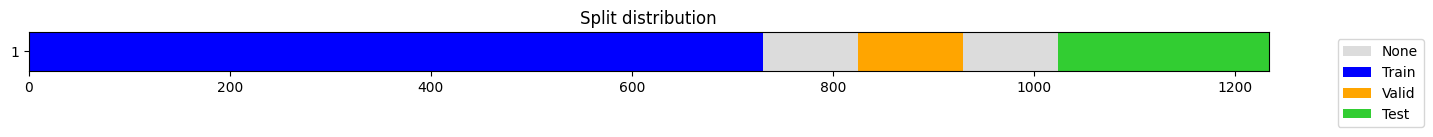

In [61]:
  datetime_col = 'Date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = 96
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)




In [62]:
(splits[2][0])

1024

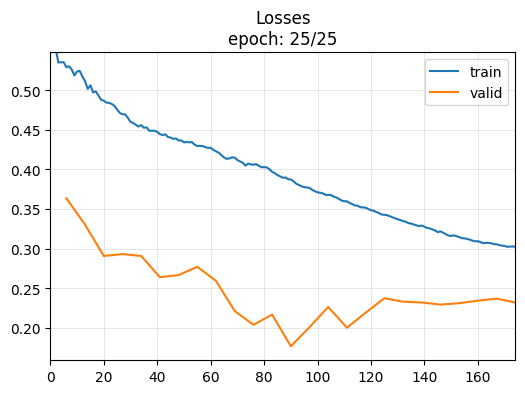

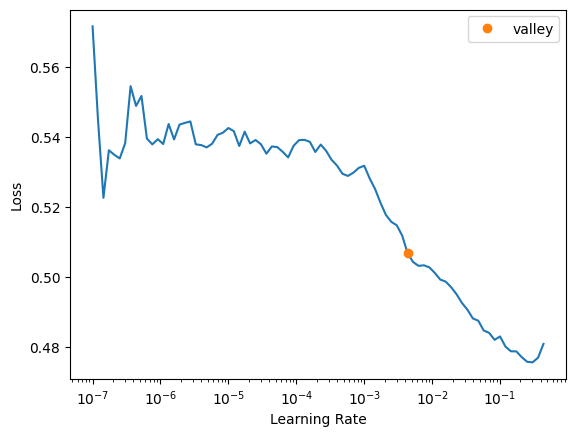

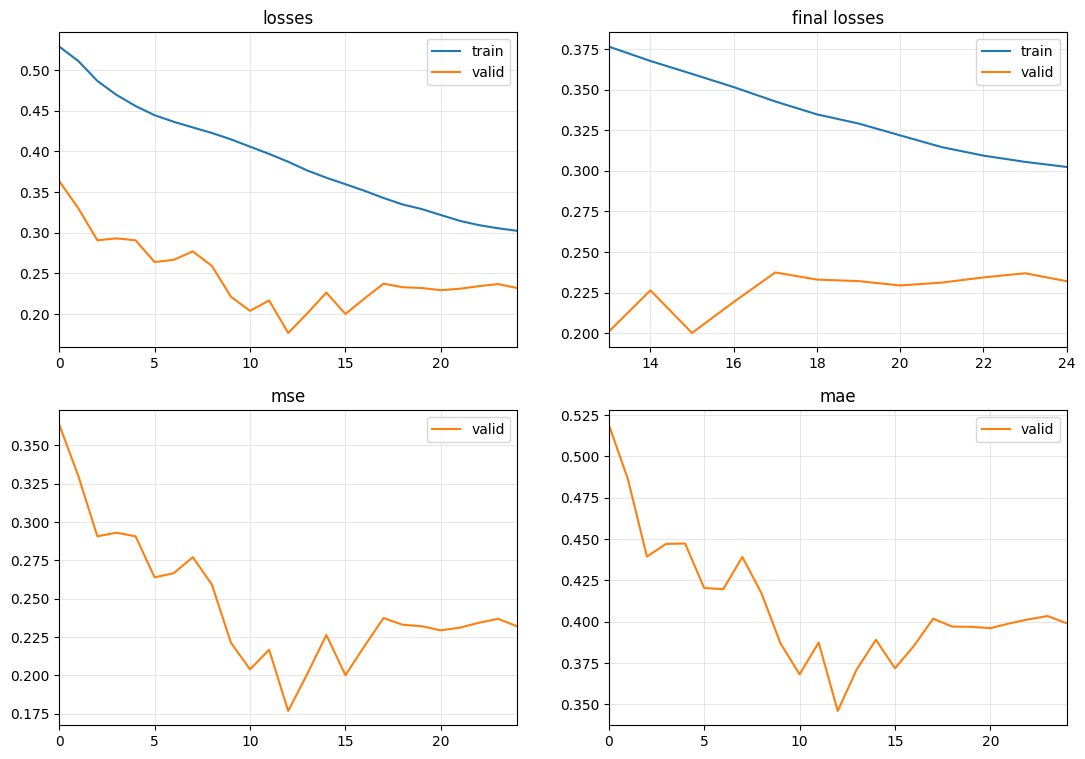

In [64]:
   

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'] +5, lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
  



In [65]:
learn = load_learner('patchTST.pt')
scaled_preds_train, *_ = learn.get_X_preds(x[splits[0]])
scaled_preds_train = to_np(scaled_preds_train)
print(f"scaled_preds.shape: {scaled_preds_train.shape}")

scaled_y_train = y[splits[0]]
loss = mean_squared_error(scaled_y_train.flatten(), scaled_preds_train.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_train.flatten(), scaled_preds_train.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_train.flatten(), scaled_preds_train.flatten())

results_df

scaled_preds.shape: (730, 1, 96)


mse       mae
valid  0.247133  0.368338

In [67]:

x_train = x[splits[0]]
y_train = y[splits[0]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_train.reshape(-1, 1)).flatten().reshape(730, 1, 96)
inverse_scale_y_true = (scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()).reshape(730, 1, 96)
inverse_scale_x_test = scaler.inverse_transform(x_train.reshape(-1, 1)).flatten().reshape(730, 1, 48)

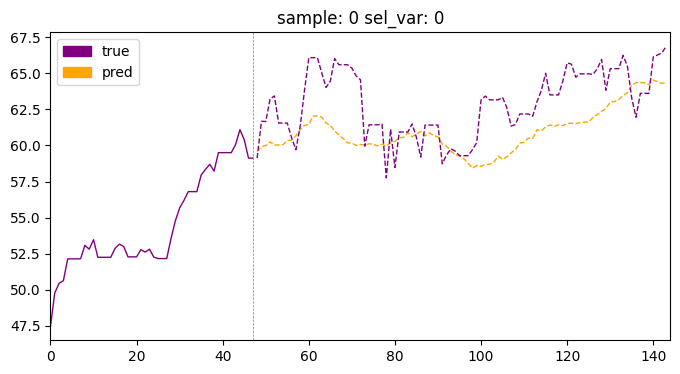

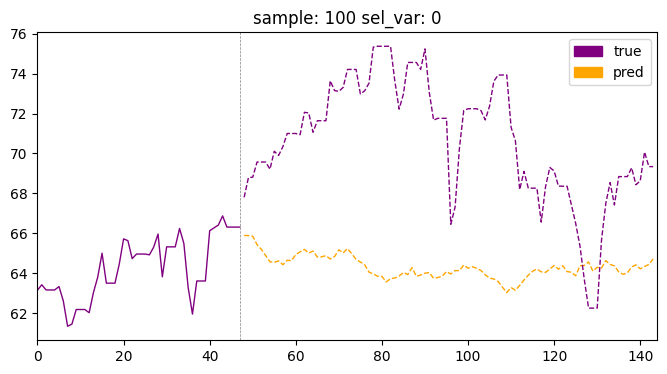

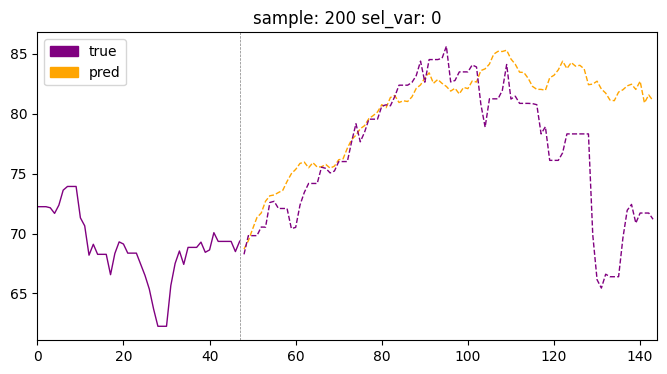

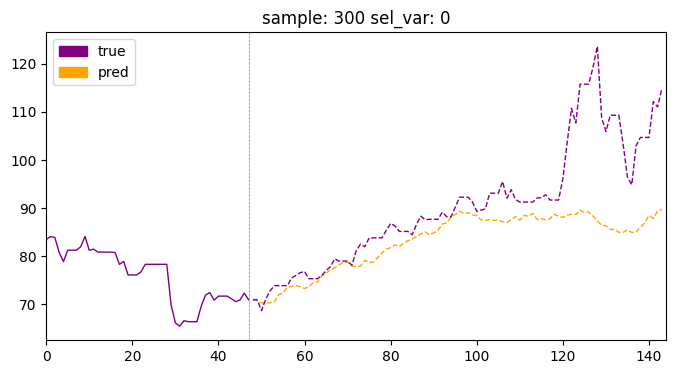

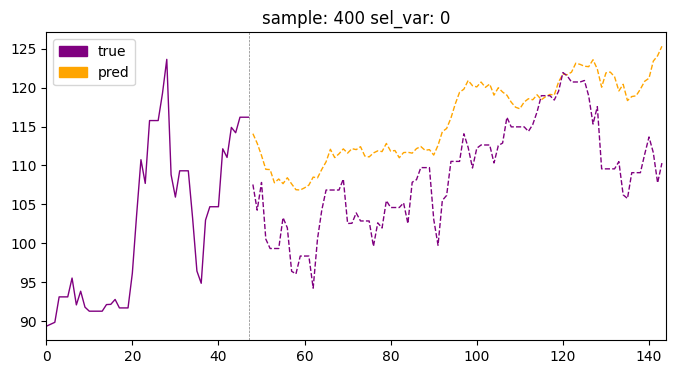

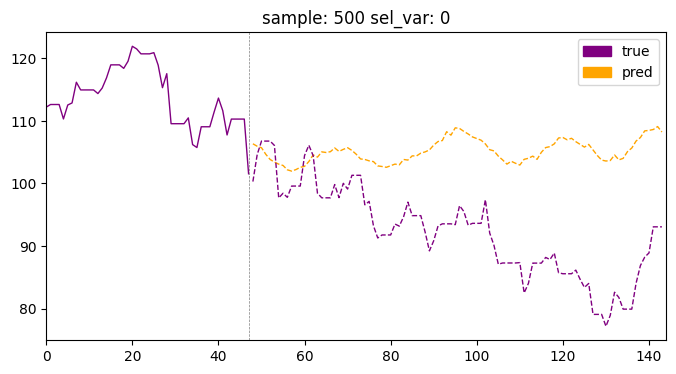

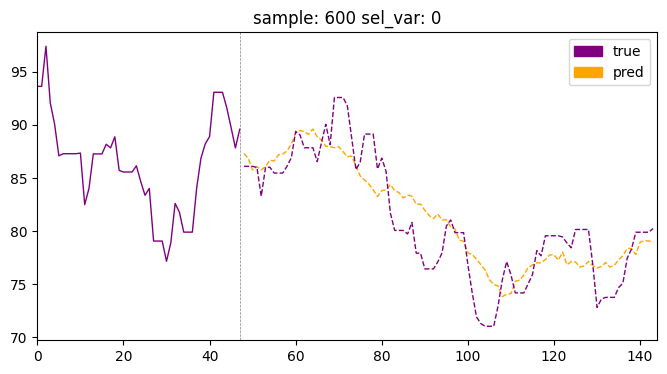

In [68]:
for id in range (0,700, 100):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [69]:

x_train = x[splits[0]]
y_train = y[splits[0]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_val.reshape(-1, 1)).flatten().reshape(104, 1, 96)
inverse_scale_y_true = (scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()).reshape(104, 1, 96)
inverse_scale_x_test = scaler.inverse_transform(x_val.reshape(-1, 1)).flatten().reshape(104, 1, 48)

In [70]:
learn = load_learner('patchTST.pt')
scaled_preds_val, *_ = learn.get_X_preds(x[splits[1]])
scaled_preds_val = to_np(scaled_preds_val)
print(f"scaled_preds.shape: {scaled_preds_val.shape}")

scaled_y_true_val = y[splits[1]]
loss = mean_squared_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())

results_df

scaled_preds.shape: (104, 1, 96)


mse       mae
valid  0.232006  0.399076

In [71]:

x_val = x[splits[1]]
y_val = y[splits[1]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_val.reshape(-1, 1)).flatten().reshape(104, 1, 96)
inverse_scale_y_true = (scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()).reshape(104, 1, 96)
inverse_scale_x_test = scaler.inverse_transform(x_val.reshape(-1, 1)).flatten().reshape(104, 1, 48)

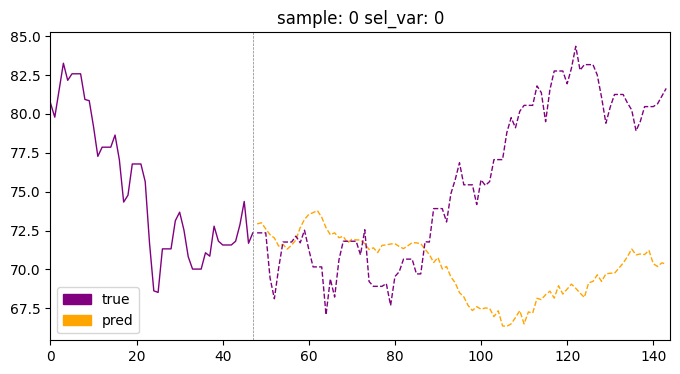

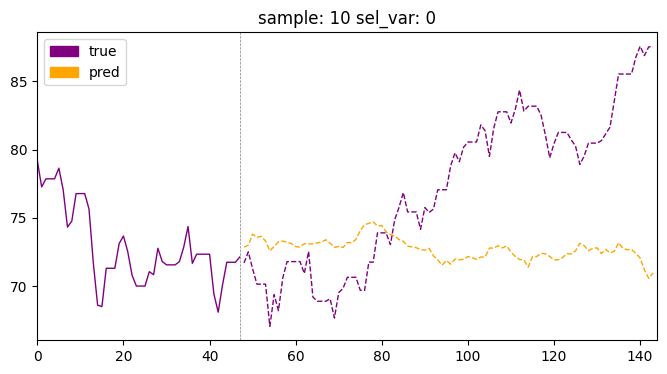

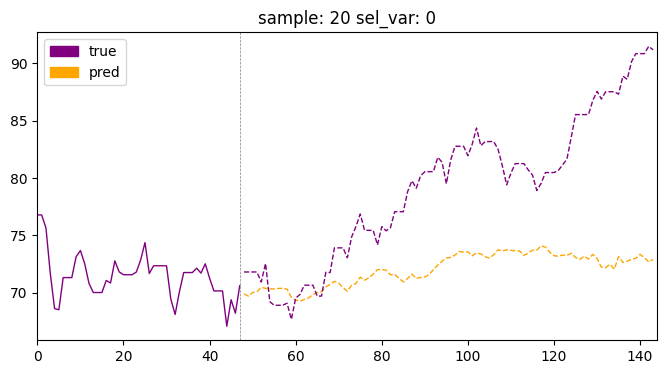

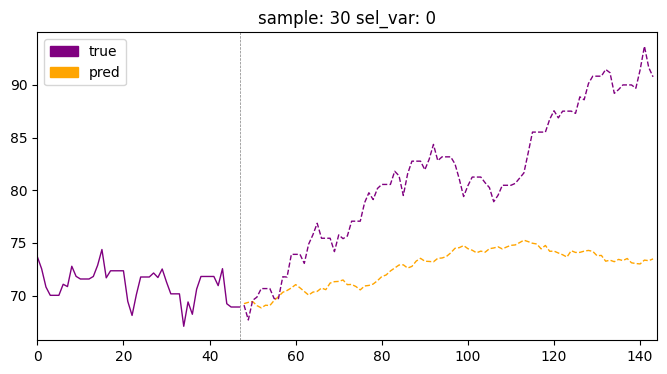

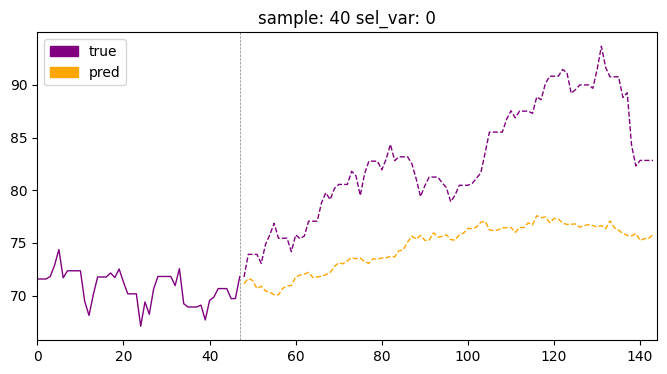

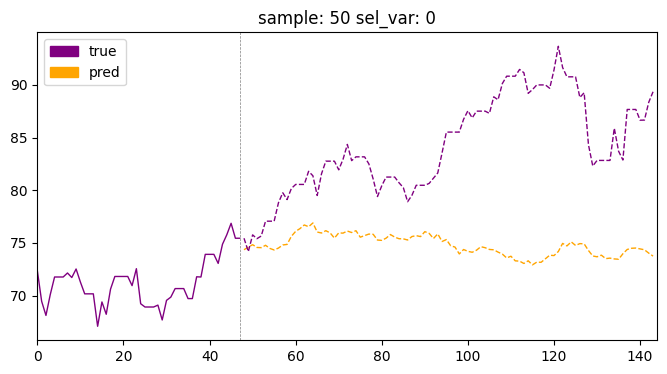

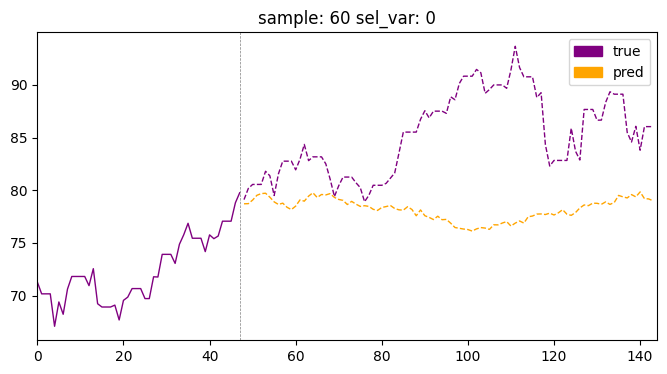

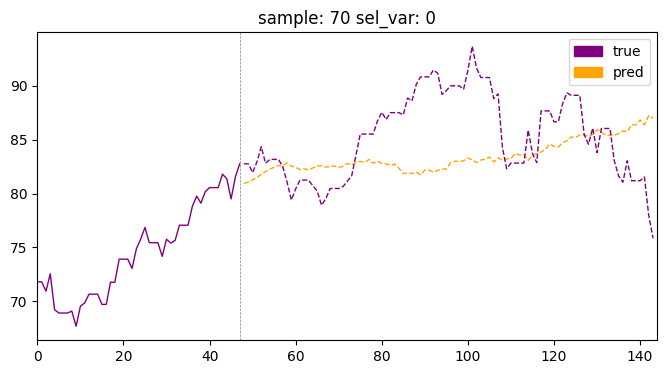

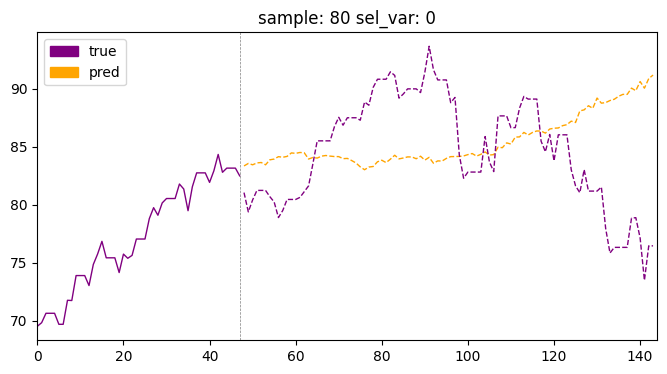

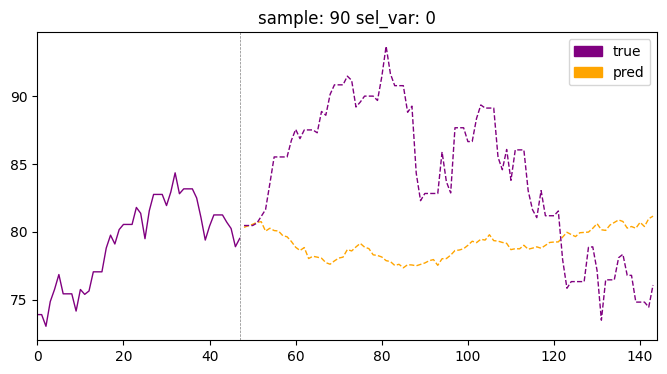

In [72]:
for id in range (0,100, 10):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [73]:
learn = load_learner('patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(x[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df






y_test_preds.shape: (209, 1, 96)


mse       mae
test  0.150994  0.311481

In [74]:

x_test = x[splits[2]]
y_test = y[splits[2]]


inverse_scale_y_preds = scaler.inverse_transform(y_test_preds.reshape(-1, 1)).flatten().reshape(209, 1, 96)
inverse_scale_y_true = (scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()).reshape(209, 1, 96)
inverse_scale_x_test = scaler.inverse_transform(x_test.reshape(-1, 1)).flatten().reshape(209, 1, 48)

In [75]:
y_test.shape

(209, 1, 96)

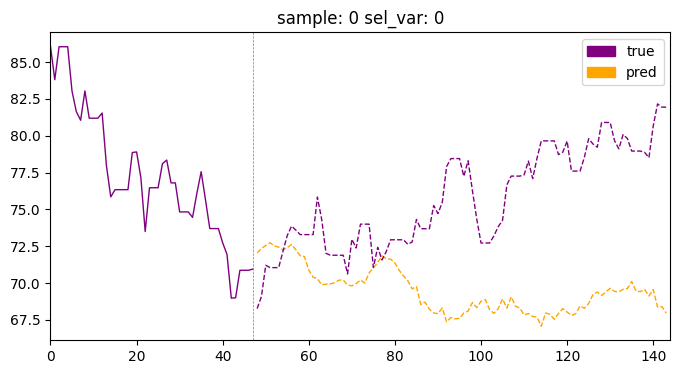

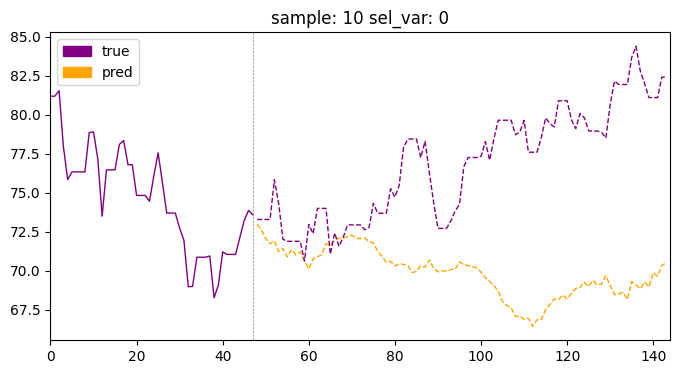

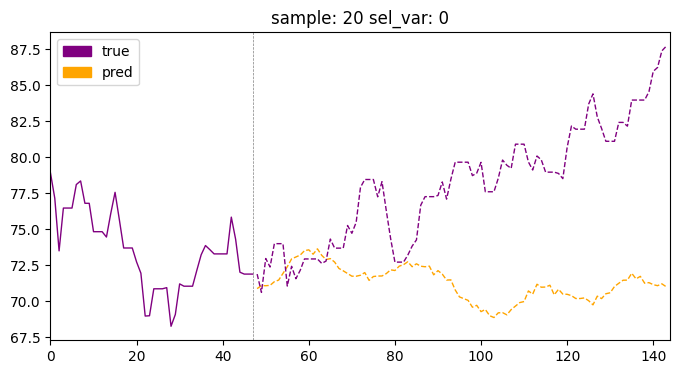

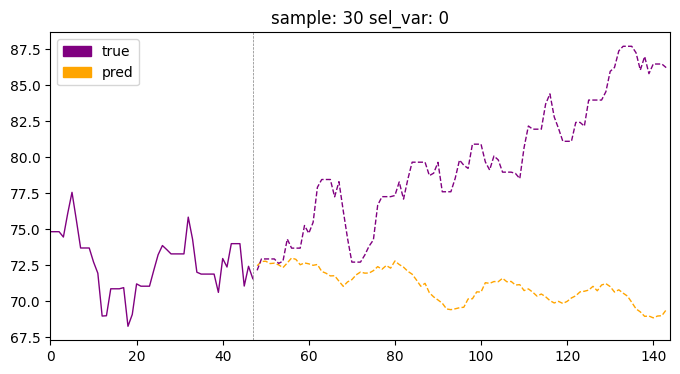

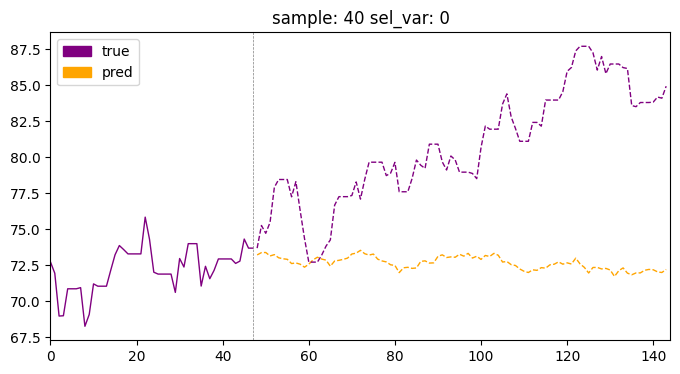

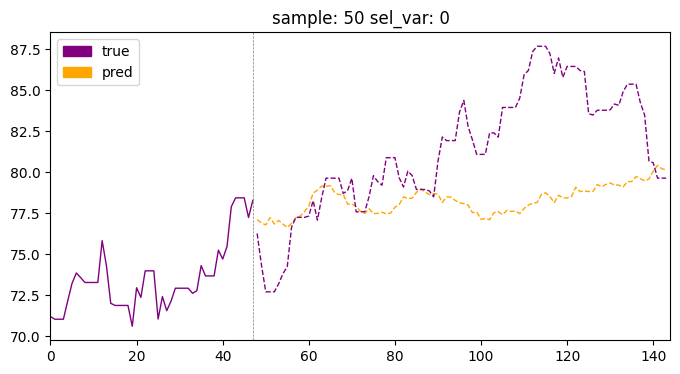

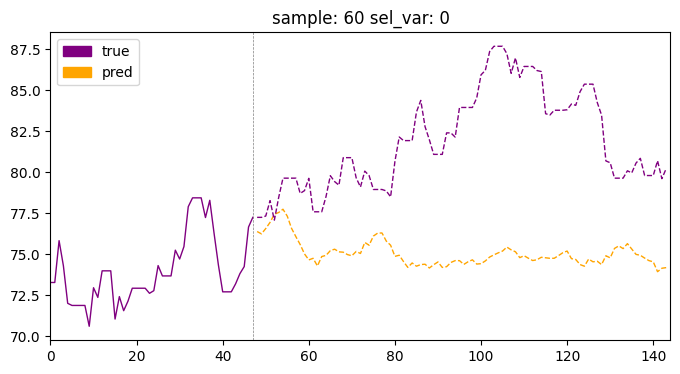

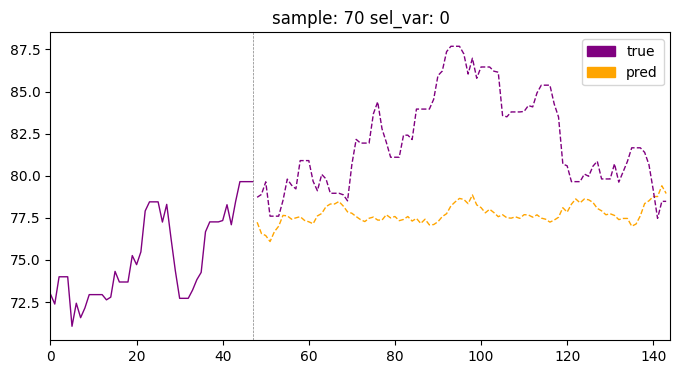

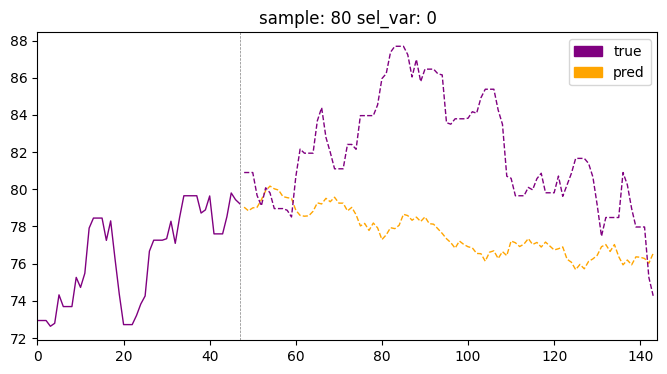

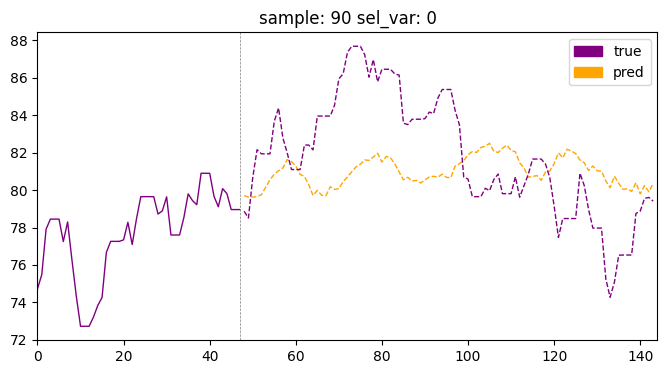

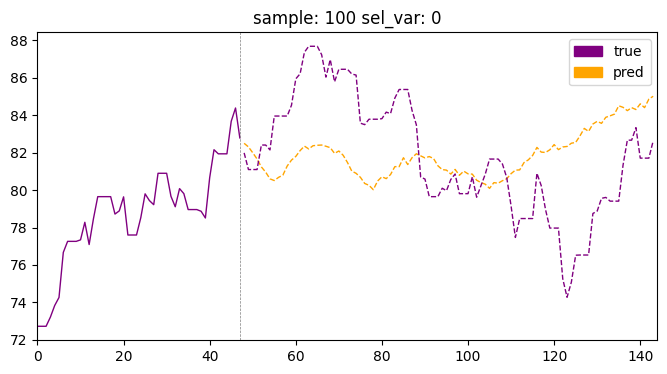

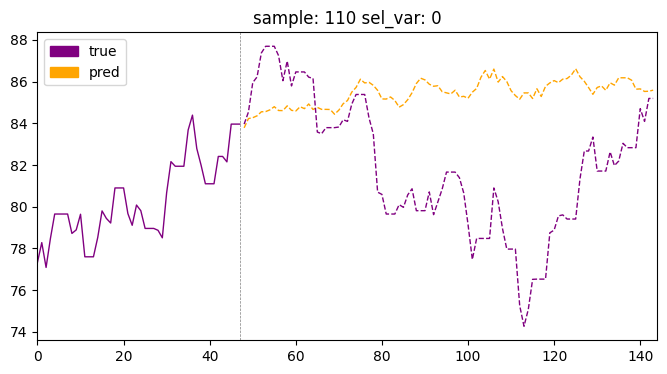

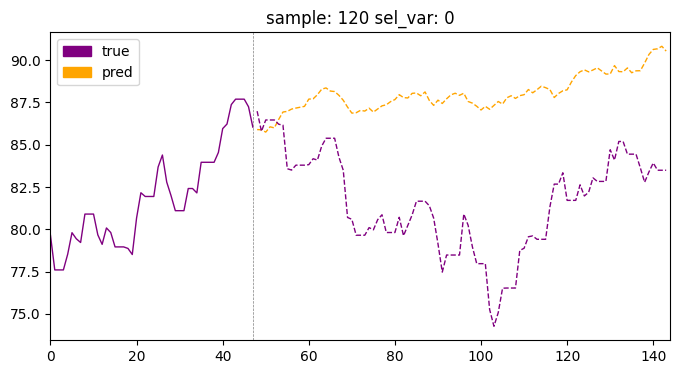

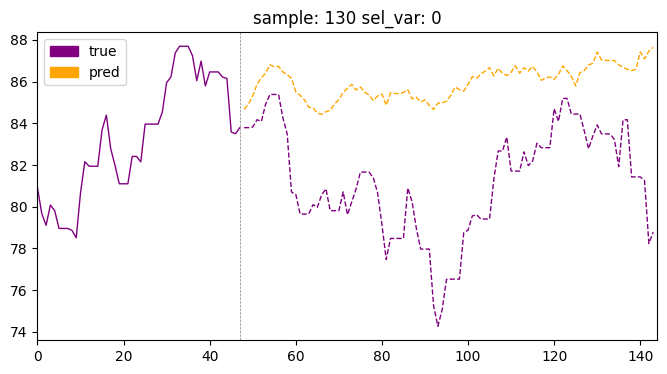

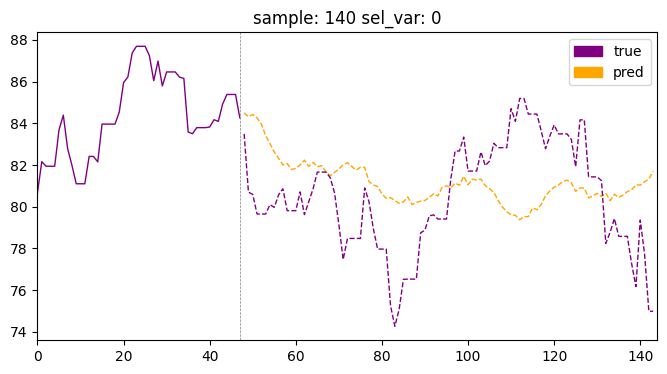

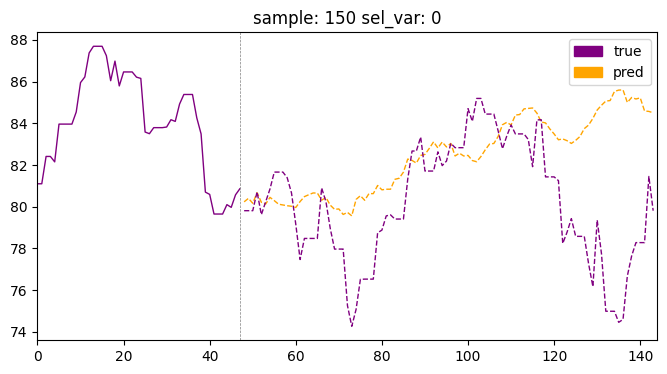

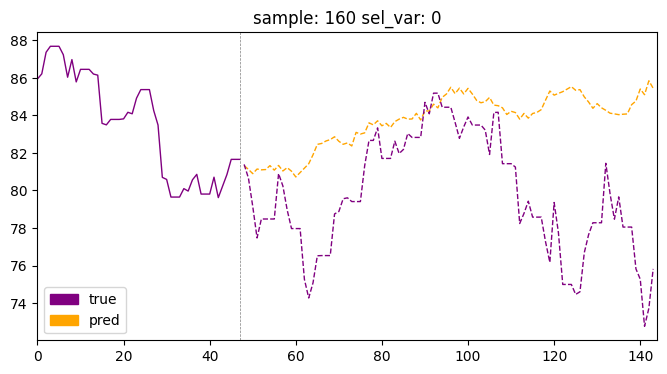

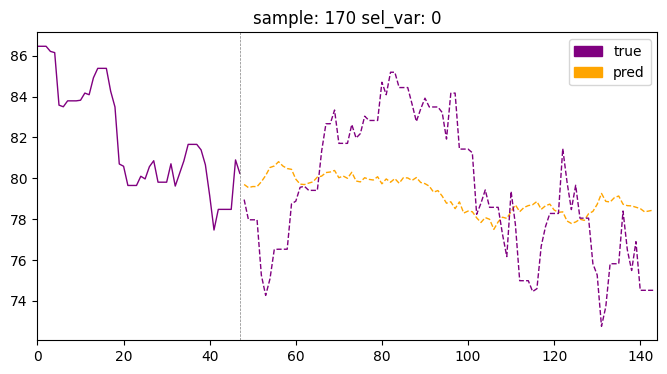

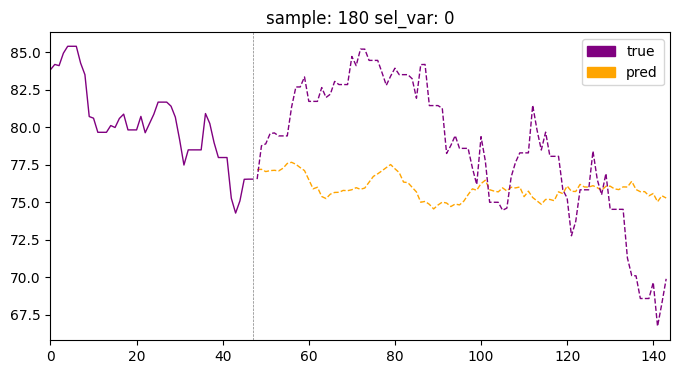

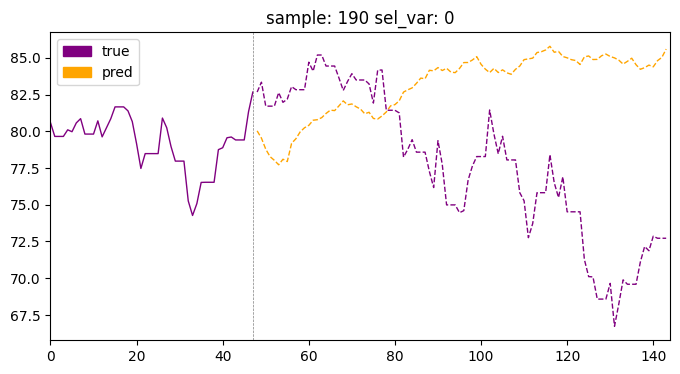

In [76]:
for id in range (0,200, 10):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


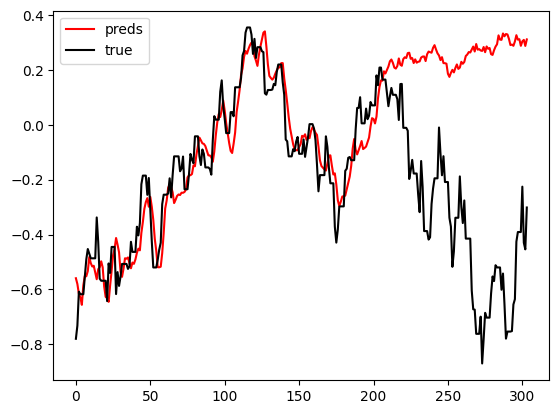

In [77]:
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
y_test_preds = torch.tensor(y_test_preds)



y_preds_one = y_test_preds[:, 0, 0]
y_true_one = y_test[:, 0, 0]

y_preds_last = y_test_preds[-1, 0, 1:]
y_true_last = y_test[-1, 0, 1:]

y_preds_appended = torch.cat((y_preds_one, y_preds_last))
y_true_appended = torch.cat((y_true_one, y_true_last))



plt.plot(y_preds_appended, c = 'r', label = 'preds')
plt.plot(y_true_appended, c = 'k', label = 'true')
plt.legend()


# Optuna Small

## Tune

In [54]:
# def objective(trial):
#     # Suggest `fcst_history` first


#     HPs = {
#         'fcst_history': trial.suggest_int("fcst_history", 16, 128, step=16),
#         'batch_size': trial.suggest_int("batch_size", 8, 128, step=8),
#         'epochs': trial.suggest_int("epochs", 5, 20, step=5),
#         'n_layers': trial.suggest_int("n_layers", 1, 4, step=1),  # encoder_layers
#         'n_heads': trial.suggest_int("n_heads", 1, 4, step=2),
#         'd_model': trial.suggest_int("d_model", 16, 128, step=8),
#         'd_ff': trial.suggest_int("d_ff", 16, 256, step=8),
#         'attn_dropout': trial.suggest_float("attn_dropout", 0, 0.5, step=0.1),
#         'dropout': trial.suggest_float("dropout", 0, 0.5, step=0.1),
#         'patch_len': trial.suggest_int("patch_len", 0, 128, step=16),
#         'stride': trial.suggest_int("stride", 1, 5, step=1)
#     }

#     try:
#         loss = train_model(HPs)
#         return loss
#     except Exception as e:
#         print(f'Study failed because {e}.')
#         return None


In [7]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    fcst_history = trial.suggest_int("fcst_history", 16, 128, step=16)
    n_heads = trial.suggest_int("n_heads", 1, 4, step=1)
    d_model = trial.suggest_int("d_model", 16, 128, step=8)
    patch_len = trial.suggest_int("patch_len", 0, fcst_history, step=16)
    
    # Prune trial if d_model is not divisible by n_heads
    if d_model % n_heads != 0:
        print(f"Pruning trial: d_model ({d_model}) is not divisible by n_heads ({n_heads})")
        raise optuna.exceptions.TrialPruned()
    
    # Prune trial if patch_len is greater than fcst_history
    if patch_len > fcst_history:
        print(f"Pruning trial: patch_len ({patch_len}) is greater than fcst_history ({fcst_history})")
        raise optuna.exceptions.TrialPruned()

    if patch_len == 0:
        print(f"Pruning trial: patch_len ({patch_len}) is greater than fcst_history ({fcst_history})")
        raise optuna.exceptions.TrialPruned()

    # Define other hyperparameters
    HPs = {
        'fcst_history': fcst_history,
        'batch_size': trial.suggest_int("batch_size", 8, 128, step=8),
        'epochs': trial.suggest_int("epochs", 5, 20, step=5),
        'n_layers': trial.suggest_int("n_layers", 1, 4, step=1),
        'n_heads': n_heads,
        'd_model': d_model,
        'd_ff': trial.suggest_int("d_ff", 16, 256, step=8),
        'attn_dropout': trial.suggest_float("attn_dropout", 0, 0.5, step=0.1),
        'dropout': trial.suggest_float("dropout", 0, 0.5, step=0.1),
        'stride': trial.suggest_int("stride", 1, 5, step=1),
        'patch_len': patch_len
    }

    # Your evaluation logic here
    try:
        loss = train_model(HPs)  # Replace with your training logic
        return loss
    except Exception as e:
        print(f"Trial failed: {e}")
        return None


In [5]:
def data_preparation(HPs):



  #setting basic params
  datetime_col = 'Date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = 16
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)

  return splits, x_tensor, y_tensor, x, y









In [9]:
def train_model(HPs):

    splits, x_tensor, y_tensor, x, y = data_preparation(HPs)

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae])

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'], lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
    learn = load_learner('patchTST.pt')
    scaled_preds, *_ = learn.get_X_preds(x[splits[1]])
    scaled_preds = to_np(scaled_preds)
    print(f"scaled_preds.shape: {scaled_preds.shape}")

    scaled_y_true = y[splits[1]]
    loss = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df = pd.DataFrame(columns=["mse", "mae"])
    results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())




  





    return loss











[I 2024-12-14 04:40:43,268] Using an existing study with name 'patchtst_small_refined_tune' instead of creating a new one.


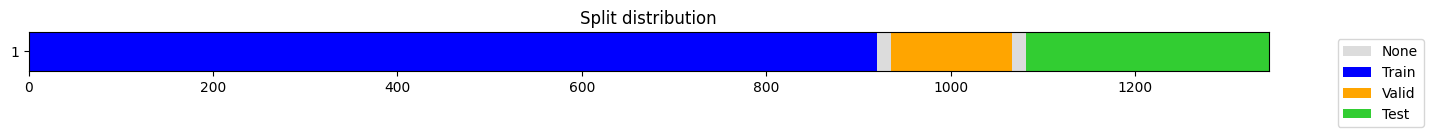

[I 2024-12-14 04:40:54,844] Trial 510 finished with value: 0.06300533718515916 and parameters: {'fcst_history': 16, 'n_heads': 2, 'd_model': 120, 'patch_len': 16, 'batch_size': 120, 'epochs': 20, 'n_layers': 3, 'd_ff': 40, 'attn_dropout': 0.0, 'dropout': 0.1, 'stride': 4}. Best is trial 374 with value: 0.06034616421404482.


scaled_preds.shape: (132, 1, 16)


['patchtst_small_redined_tune.pkl']

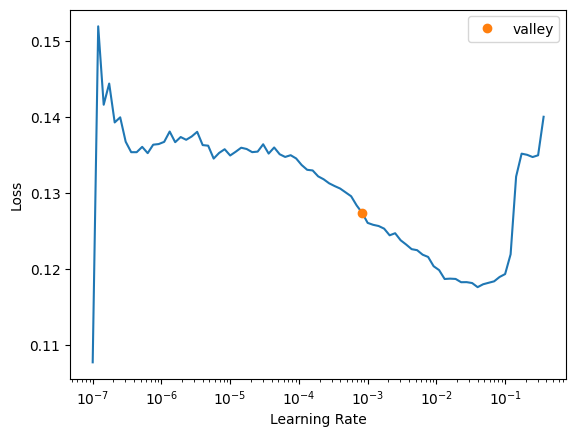

In [10]:
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(),
                            study_name='patchtst_small_refined_tune',
                            storage='sqlite:///patchtst_small_redined_tune.db', 
                            load_if_exists=True)

study.optimize(objective, n_trials=1)
joblib.dump(study, "patchtst_small_redined_tune.pkl")

## Best Small Model

In [78]:
study = joblib.load("patchtst_small_tune.pkl")
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))


In [79]:
value = sorted_trials[0].value
print(value)
HPs = sorted_trials[0].params
HPs

0.057311441188558035


{'fcst_history': 96,
 'batch_size': 24,
 'epochs': 20,
 'n_layers': 3,
 'n_heads': 1,
 'd_model': 120,
 'd_ff': 152,
 'attn_dropout': 0.1,
 'dropout': 0.30000000000000004,
 'patch_len': 96,
 'stride': 2}

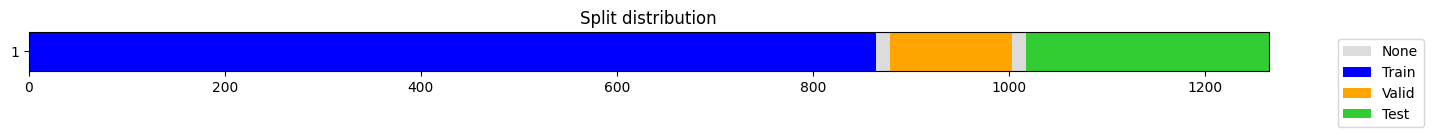

In [80]:
  datetime_col = 'Date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = 16
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)




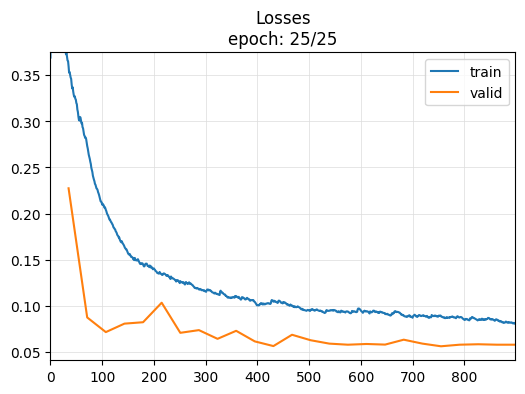

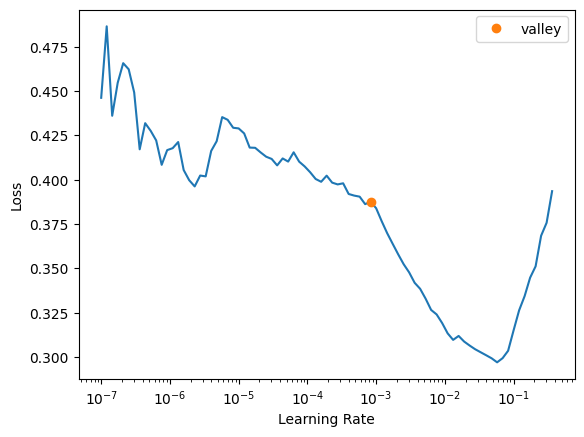

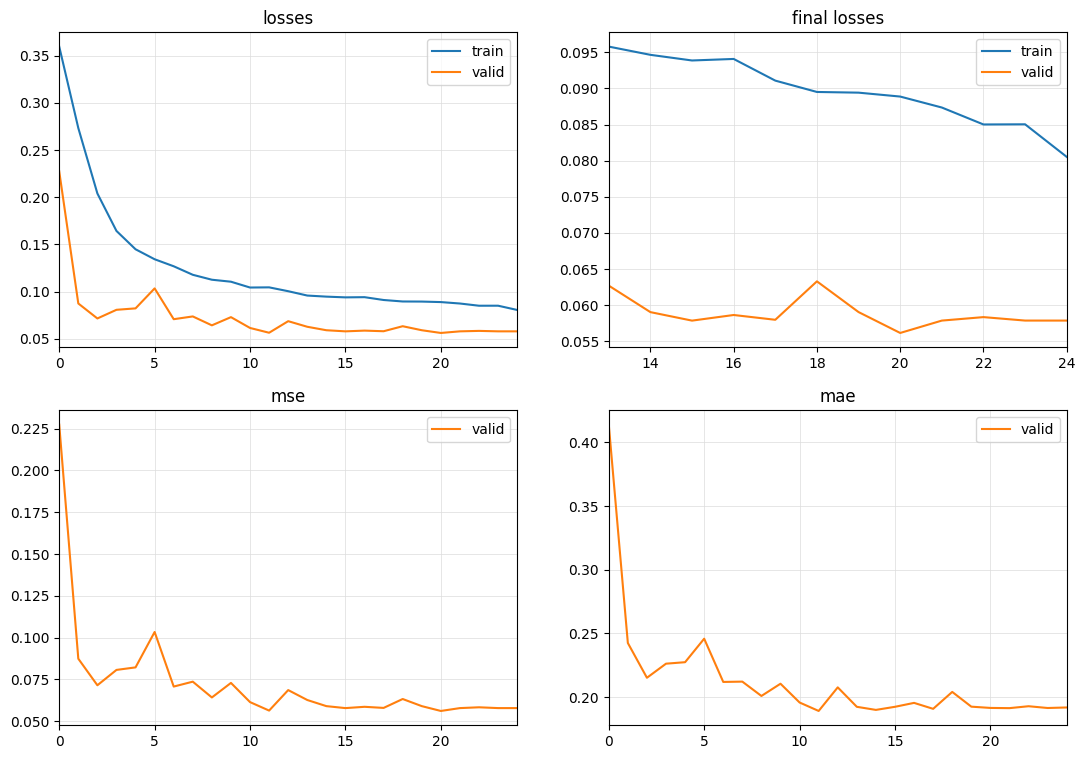

In [81]:
   

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'] +5, lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
  



In [92]:
learn = load_learner('patchTST.pt')
scaled_preds_train, *_ = learn.get_X_preds(x[splits[0]])
scaled_preds_train = to_np(scaled_preds_train)
print(f"scaled_preds.shape: {scaled_preds_train.shape}")

scaled_y_train = y[splits[0]]
loss = mean_squared_error(scaled_y_train.flatten(), scaled_preds_train.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_train.flatten(), scaled_preds_train.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_train.flatten(), scaled_preds_train.flatten())

results_df

scaled_preds.shape: (864, 1, 16)


mse       mae
valid  0.057171  0.177961

In [94]:

x_train = x[splits[0]]
y_train = y[splits[0]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_train.reshape(-1, 1)).flatten().reshape(864, 1, 16)
inverse_scale_y_true = (scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()).reshape(864, 1, 16)
inverse_scale_x_test = scaler.inverse_transform(x_train.reshape(-1, 1)).flatten().reshape(864, 1, 96)

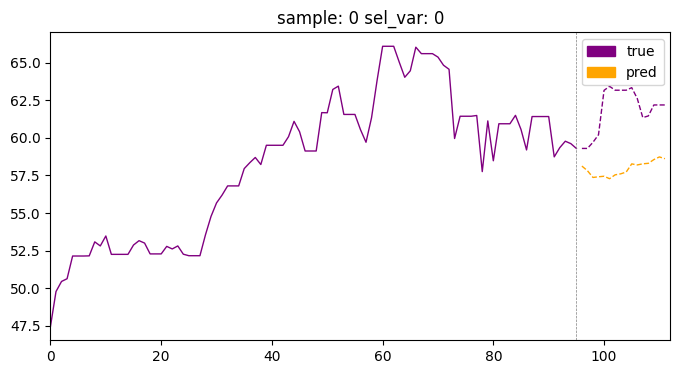

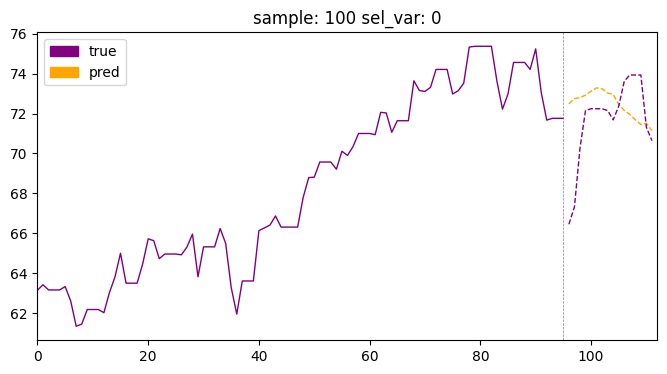

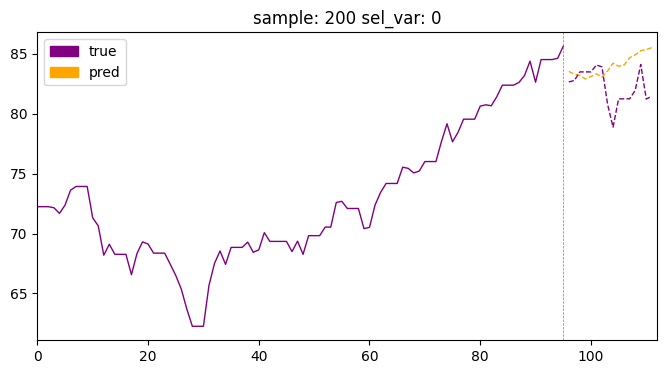

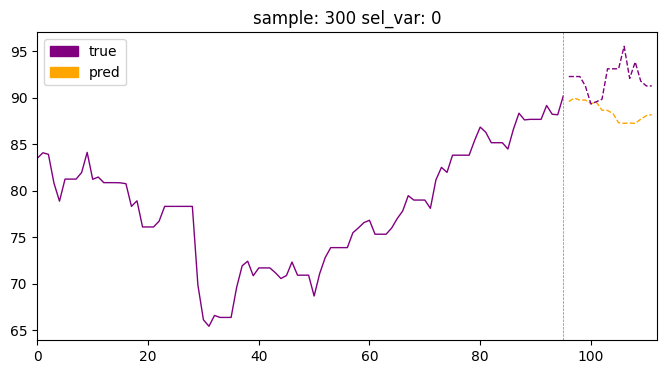

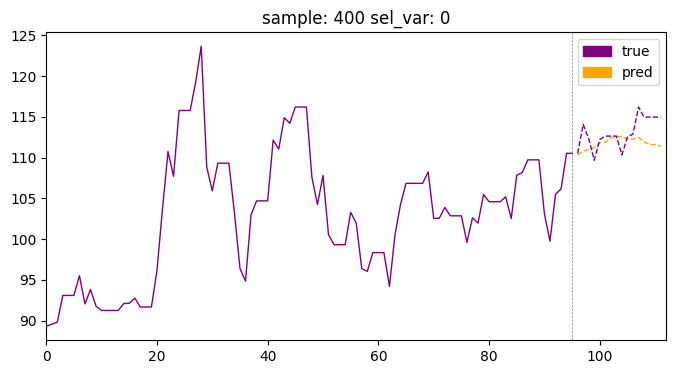

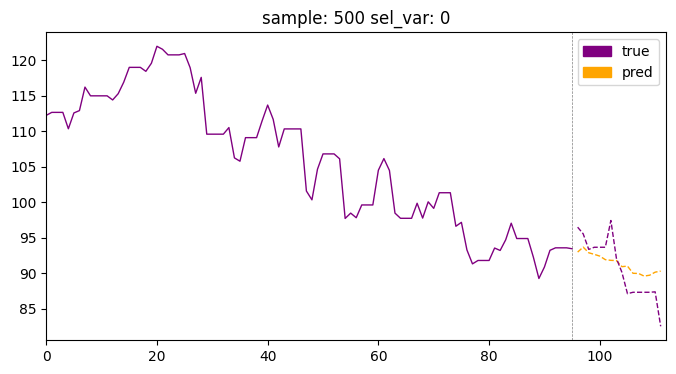

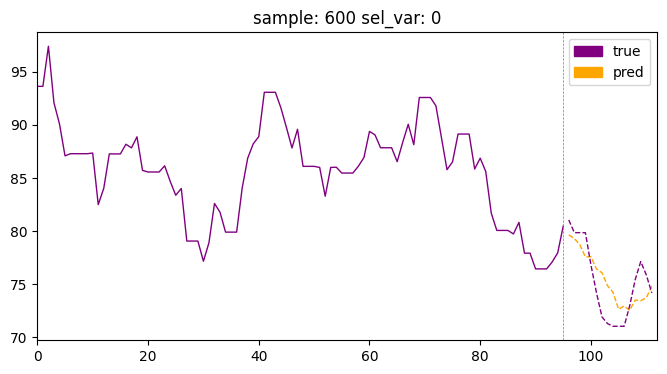

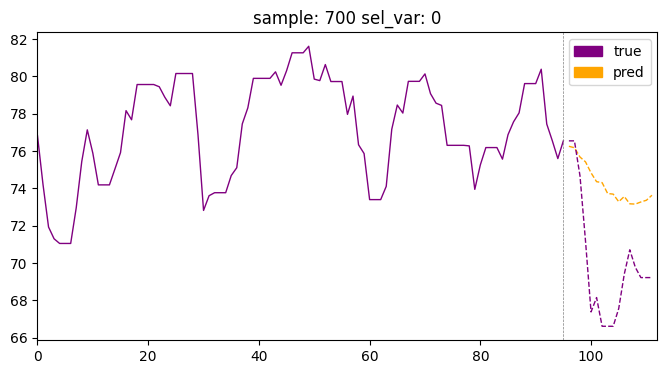

In [96]:
for id in range (0,800, 100):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [97]:
learn = load_learner('patchTST.pt')
scaled_preds_val, *_ = learn.get_X_preds(x[splits[1]])
scaled_preds_val = to_np(scaled_preds_val)
print(f"scaled_preds.shape: {scaled_preds_val.shape}")

scaled_y_true_val = y[splits[1]]
loss = mean_squared_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())

results_df

scaled_preds.shape: (124, 1, 16)


mse       mae
valid  0.05786  0.191806

In [99]:

x_val = x[splits[1]]
y_val = y[splits[1]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_val.reshape(-1, 1)).flatten().reshape(124, 1, 16)
inverse_scale_y_true = (scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()).reshape(124, 1, 16)
inverse_scale_x_test = scaler.inverse_transform(x_val.reshape(-1, 1)).flatten().reshape(124, 1, 96)

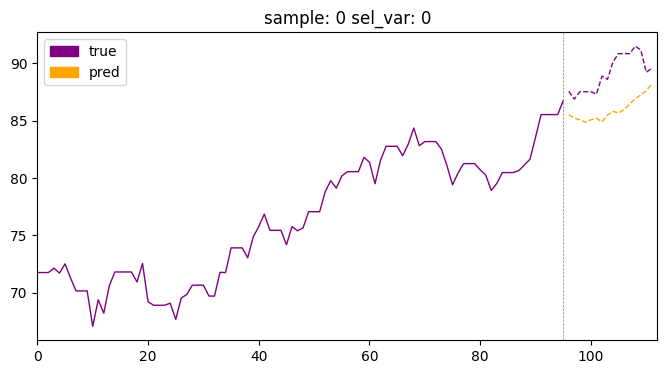

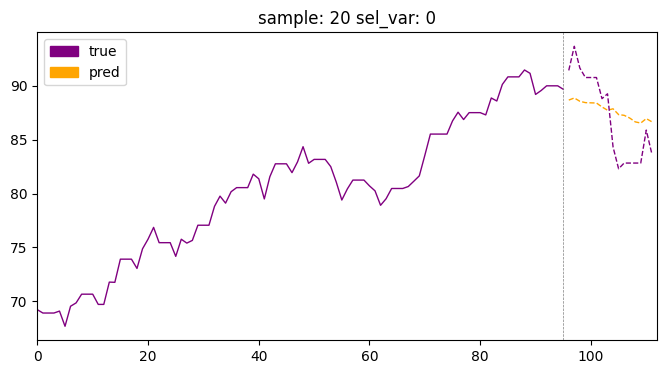

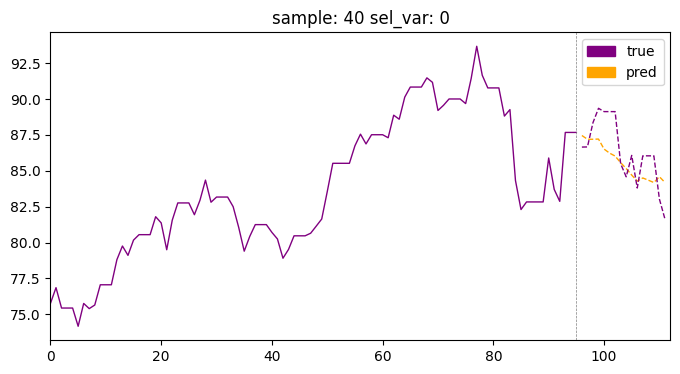

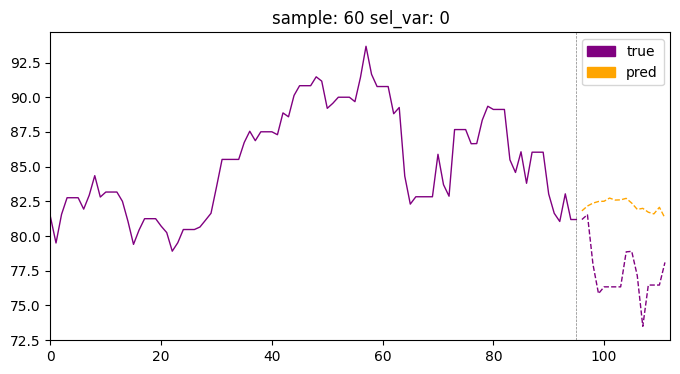

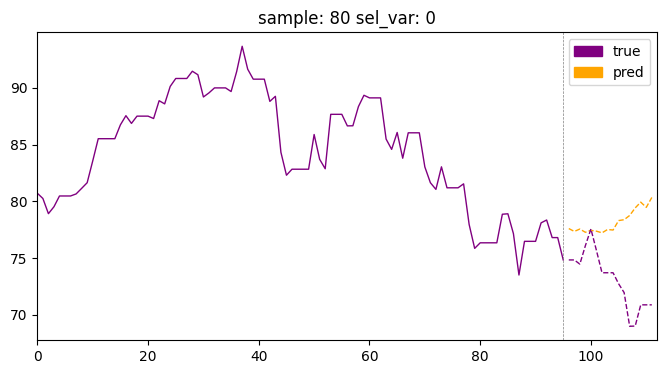

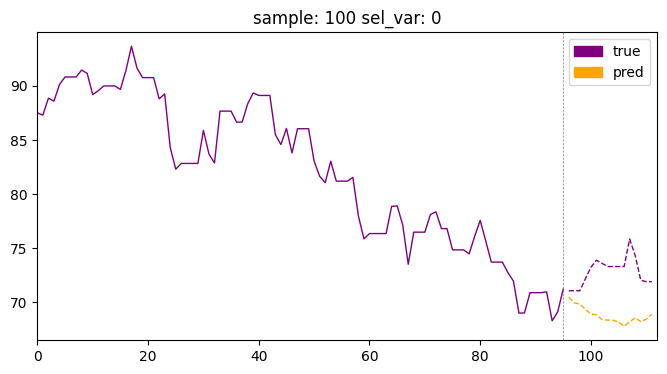

In [101]:
for id in range (0,120, 20):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [102]:
learn = load_learner('patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(x[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df






y_test_preds.shape: (247, 1, 16)


mse       mae
test  0.040174  0.159726

In [105]:

x_test = x[splits[2]]
y_test = y[splits[2]]


inverse_scale_y_preds = scaler.inverse_transform(y_test_preds.reshape(-1, 1)).flatten().reshape(247, 1, 16)
inverse_scale_y_true = (scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()).reshape(247, 1, 16)
inverse_scale_x_test = scaler.inverse_transform(x_test.reshape(-1, 1)).flatten().reshape(247, 1, 96)

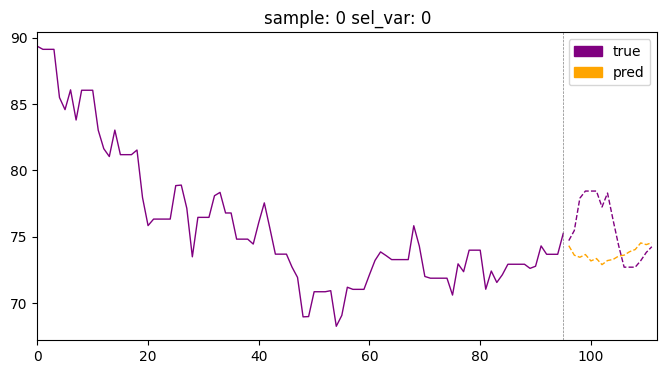

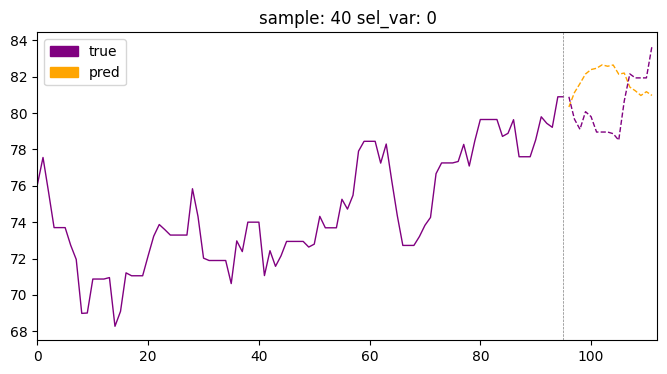

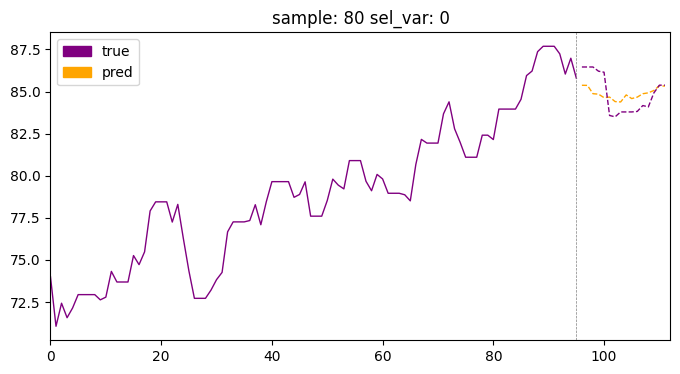

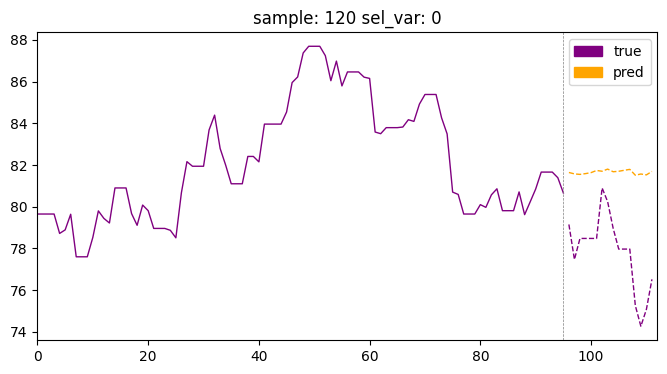

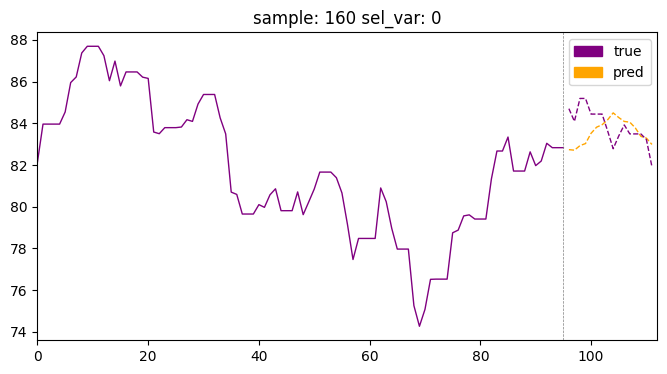

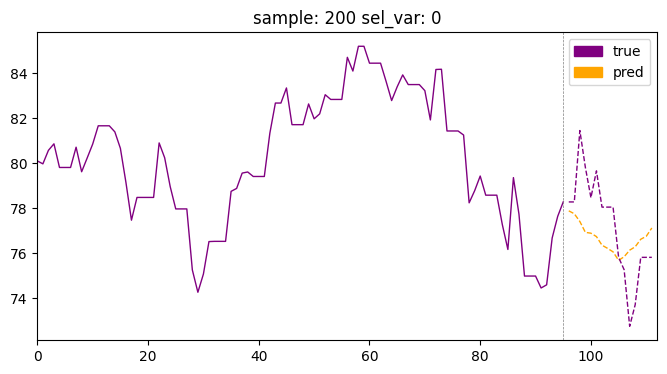

In [106]:
for id in range (0,240, 40):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


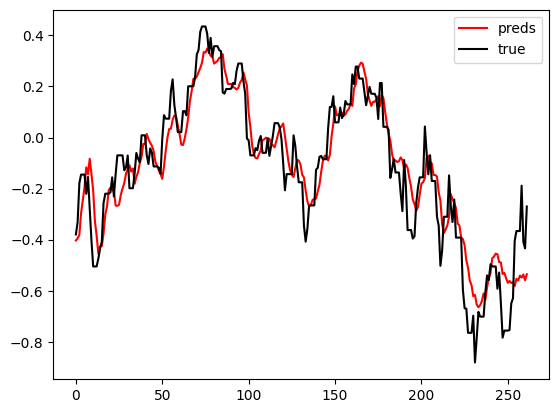

In [107]:
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
y_test_preds = torch.tensor(y_test_preds)



y_preds_one = y_test_preds[:, 0, 0]
y_true_one = y_test[:, 0, 0]

y_preds_last = y_test_preds[-1, 0, 1:]
y_true_last = y_test[-1, 0, 1:]

y_preds_appended = torch.cat((y_preds_one, y_preds_last))
y_true_appended = torch.cat((y_true_one, y_true_last))



plt.plot(y_preds_appended, c = 'r', label = 'preds')
plt.plot(y_true_appended, c = 'k', label = 'true')
plt.legend()


# Optuna Medium

## Tune

In [133]:

def objective(trial):
    # Suggest hyperparameters
    fcst_history = trial.suggest_int("fcst_history", 16, 128, step=16)
    n_heads = trial.suggest_int("n_heads", 1, 4, step=1)
    d_model = trial.suggest_int("d_model", 16, 128, step=8)
    patch_len = trial.suggest_int("patch_len", 0, fcst_history, step=16)
    
    # Prune trial if d_model is not divisible by n_heads
    if d_model % n_heads != 0:
        print(f"Pruning trial: d_model ({d_model}) is not divisible by n_heads ({n_heads})")
        raise optuna.exceptions.TrialPruned()
    
    # Prune trial if patch_len is greater than fcst_history
    if patch_len > fcst_history:
        print(f"Pruning trial: patch_len ({patch_len}) is greater than fcst_history ({fcst_history})")
        raise optuna.exceptions.TrialPruned()

    if patch_len == 0:
        print(f"Pruning trial: patch_len ({patch_len}) is greater than fcst_history ({fcst_history})")
        raise optuna.exceptions.TrialPruned()

    # Define other hyperparameters
    HPs = {
        'fcst_history': fcst_history,
        'batch_size': trial.suggest_int("batch_size", 8, 128, step=8),
        'epochs': trial.suggest_int("epochs", 5, 20, step=5),
        'n_layers': trial.suggest_int("n_layers", 1, 4, step=1),
        'n_heads': n_heads,
        'd_model': d_model,
        'd_ff': trial.suggest_int("d_ff", 16, 256, step=8),
        'attn_dropout': trial.suggest_float("attn_dropout", 0, 0.5, step=0.1),
        'dropout': trial.suggest_float("dropout", 0, 0.5, step=0.1),
        'stride': trial.suggest_int("stride", 1, 5, step=1),
        'patch_len': patch_len
    }

    # Your evaluation logic here
    try:
        loss = train_model(HPs)  # Replace with your training logic
        return loss
    except Exception as e:
        print(f"Trial failed: {e}")
        return None


In [134]:
def data_preparation(HPs):



  #setting basic params
  datetime_col = 'Date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = 48
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)

  return splits, x_tensor, y_tensor, x, y









In [ ]:
def train_model(HPs):

    splits, x_tensor, y_tensor, x, y = data_preparation(HPs)

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae])

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'], lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
    learn = load_learner('patchTST.pt')
    scaled_preds, *_ = learn.get_X_preds(x[splits[1]])
    scaled_preds = to_np(scaled_preds)
    print(f"scaled_preds.shape: {scaled_preds.shape}")

    scaled_y_true = y[splits[1]]
    loss = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df = pd.DataFrame(columns=["mse", "mae"])
    results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
    results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())




  





    return loss











In [ ]:
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(),
                            study_name='patchtst_medium_tune',
                            storage='sqlite:///patchtst_small_medium_tune.db', 
                            load_if_exists=True)

study.optimize(objective, n_trials=1)
joblib.dump(study, "patchtst_medium_tune.pkl")

## Best Medium Model

In [110]:
study = joblib.load("patchtst_medium_tune.pkl")
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))


In [111]:
value = sorted_trials[0].value
print(value)
HPs = sorted_trials[0].params
HPs

0.15218326610156907


{'fcst_history': 64,
 'n_heads': 1,
 'd_model': 72,
 'patch_len': 32,
 'batch_size': 56,
 'epochs': 20,
 'n_layers': 3,
 'd_ff': 184,
 'attn_dropout': 0.2,
 'dropout': 0.30000000000000004,
 'stride': 1}

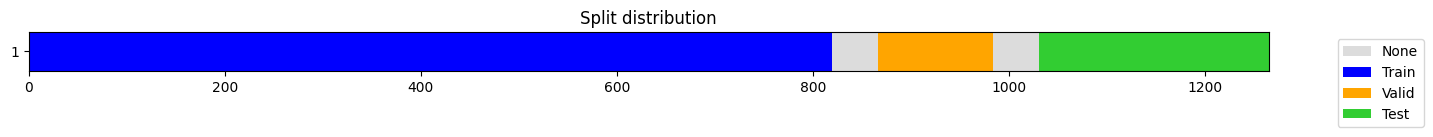

In [112]:
  datetime_col = 'Date'
  fcst_history = HPs['fcst_history']
  fcst_horizon = 48
  valid_size   = 0.1
  test_size    = 0.2

  #getting cross-val splots

  splits = get_forecasting_splits(crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                  valid_size=valid_size, test_size=test_size)

  train_data = crude_modeling_df.iloc[splits[0]]
  test_data = crude_modeling_df.iloc[splits[2]]
  val_data = crude_modeling_df.iloc[splits[1]]

  #scaling post cross-validation
  scaler = StandardScaler()
  scaled_crude_modeling_df = crude_modeling_df.copy()
  scaler.fit(train_data[['crude']])
  scaled_crude_modeling_df['crude'] = scaler.transform(crude_modeling_df[['crude']])

  #doing the sliding window step

  x_vars = 'crude'
  y_vars = 'crude'

  x, y = prepare_forecasting_data(scaled_crude_modeling_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
  x.shape, y.shape

  x_tensor = torch.tensor(x, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.float32)




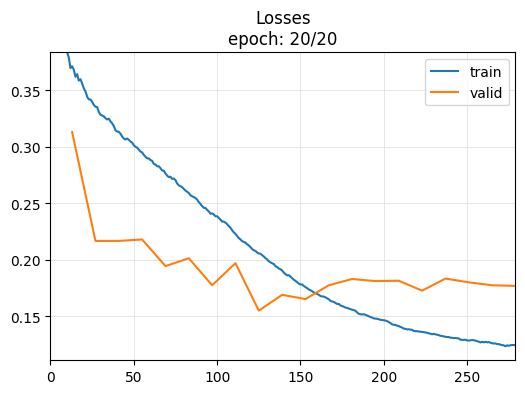

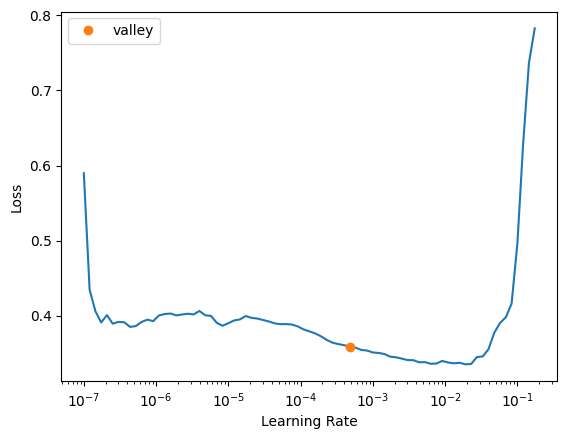

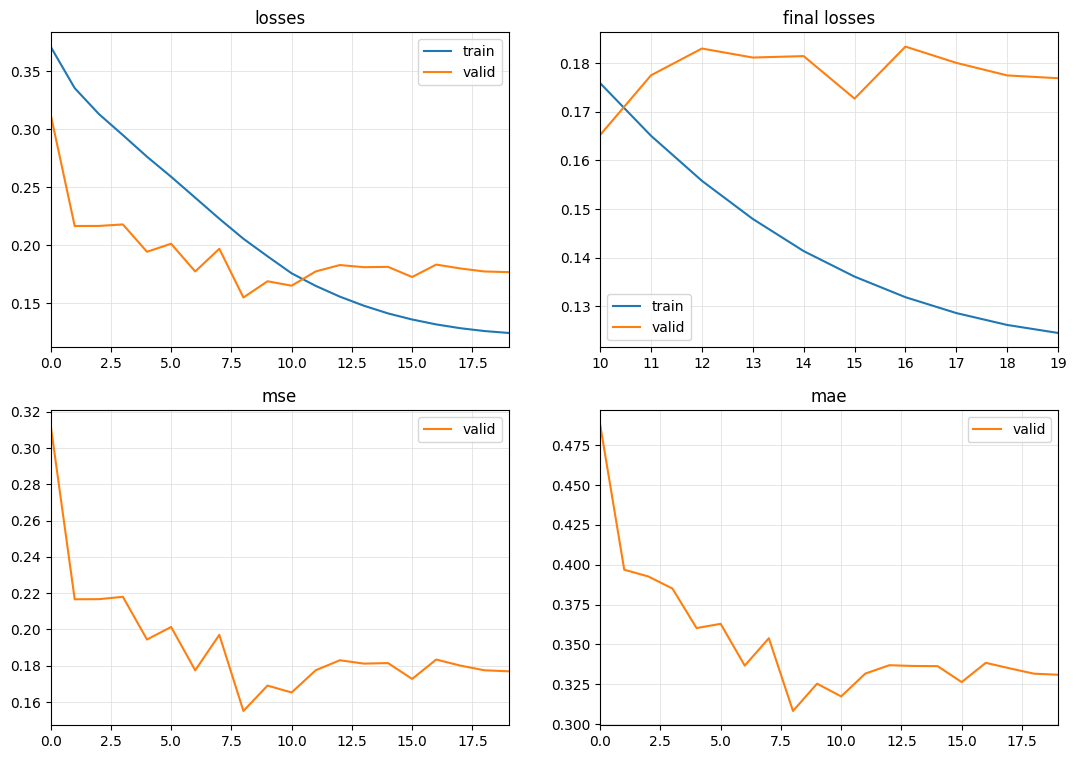

In [114]:
   

    arch_config = dict(
    n_layers= HPs['n_layers'],  # number of encoder layers
    n_heads = HPs['n_heads'],  # number of heads
    d_model= HPs['d_model'],  # dimension of model
    d_ff= HPs['d_ff'],  # dimension of fully connected network
    attn_dropout= HPs['attn_dropout'], # dropout applied to the attention weights
    dropout= HPs['dropout'], # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len= HPs['patch_len'],  # length of the patch applied to the time series to create patches
    stride= HPs['stride'],  # stride used when creating patches
    padding_patch= True,  # padding_patch
    #batch_size = HPs['batch_size']         
    )

    #modelling
    learn = TSForecaster(x_tensor, y_tensor, splits = splits, batch_size = HPs['batch_size'],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

    lr_max = learn.lr_find().valley
    learn.fit_one_cycle(HPs['epochs'], lr_max =lr_max)
    learn.export('patchTST.pt')

    #validation set inference
  



In [118]:
learn = load_learner('patchTST.pt')
scaled_preds_train, *_ = learn.get_X_preds(x[splits[0]])
scaled_preds_train = to_np(scaled_preds_train)
print(f"scaled_preds.shape: {scaled_preds_train.shape}")

scaled_y_train = y[splits[0]]
loss = mean_squared_error(scaled_y_train.flatten(), scaled_preds_train.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_train.flatten(), scaled_preds_train.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_train.flatten(), scaled_preds_train.flatten())

results_df

scaled_preds.shape: (820, 1, 48)


mse       mae
valid  0.099287  0.231629

In [121]:

x_train = x[splits[0]]
y_train = y[splits[0]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_train.reshape(-1, 1)).flatten().reshape(820, 1, fcst_horizon)
inverse_scale_y_true = (scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()).reshape(820, 1, fcst_horizon)
inverse_scale_x_test = scaler.inverse_transform(x_train.reshape(-1, 1)).flatten().reshape(820, 1, fcst_history)

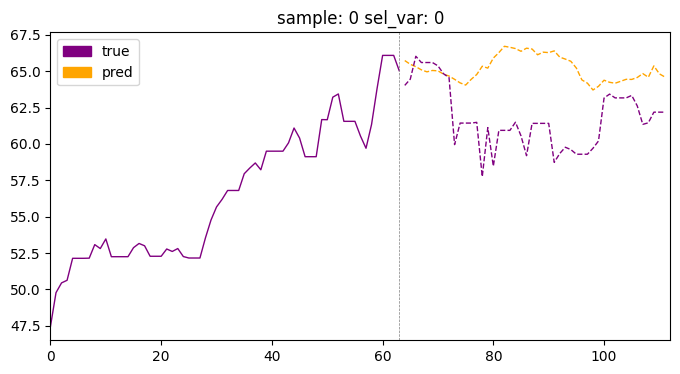

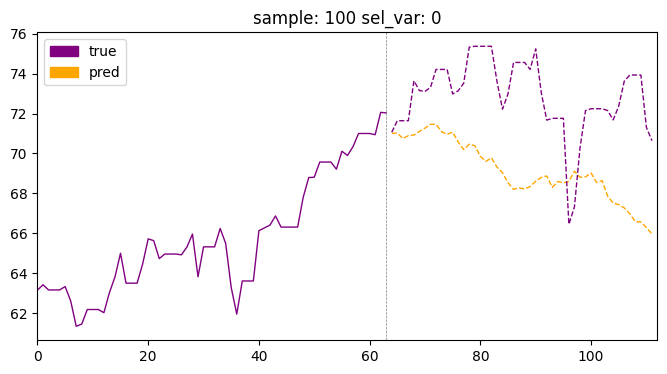

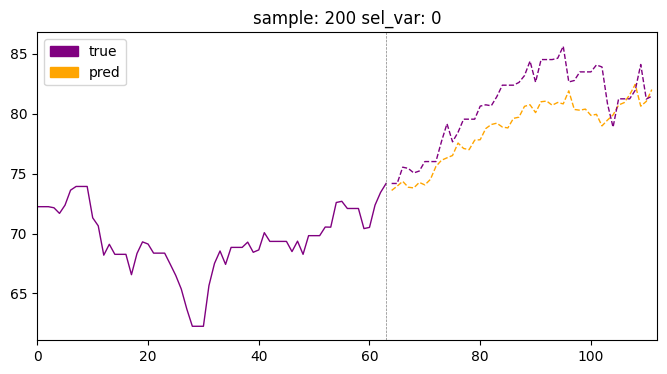

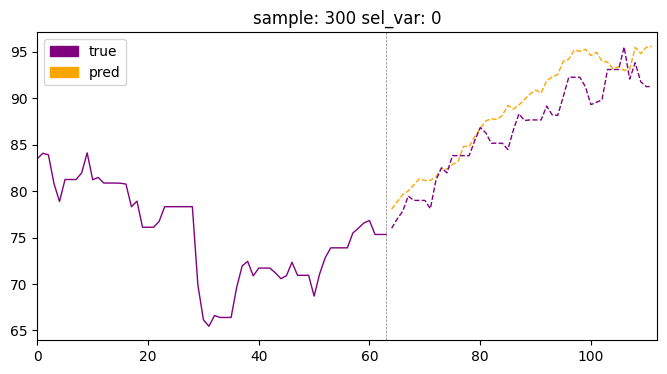

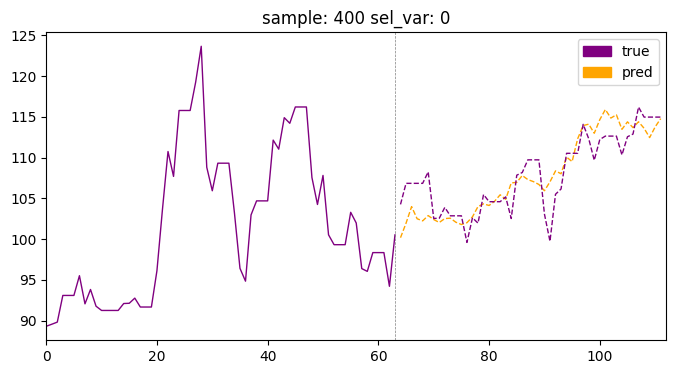

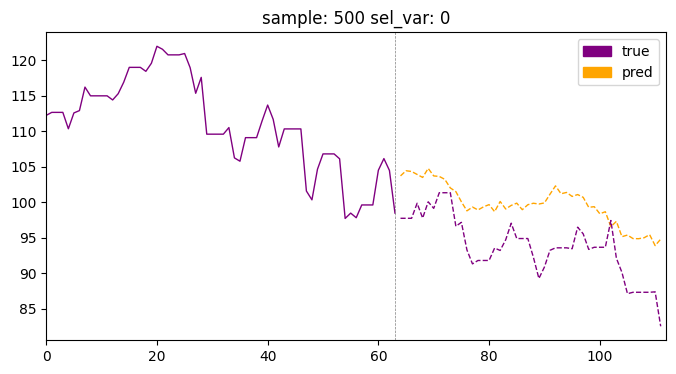

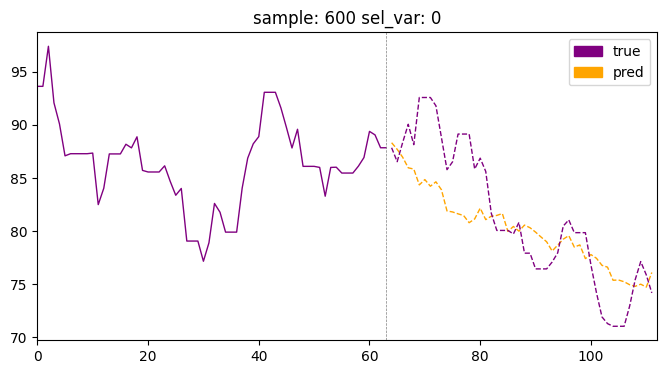

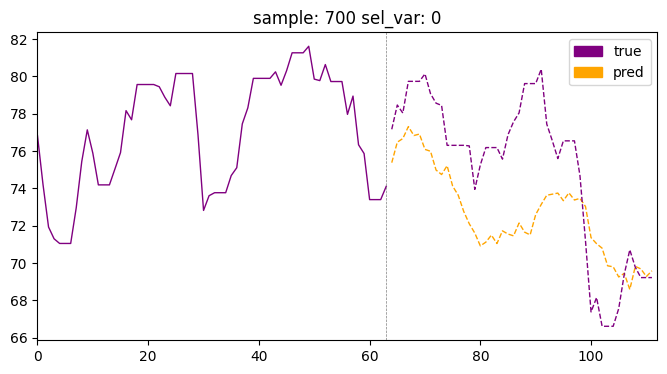

In [122]:
for id in range (0,800, 100):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [123]:
learn = load_learner('patchTST.pt')
scaled_preds_val, *_ = learn.get_X_preds(x[splits[1]])
scaled_preds_val = to_np(scaled_preds_val)
print(f"scaled_preds.shape: {scaled_preds_val.shape}")

scaled_y_true_val = y[splits[1]]
loss = mean_squared_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true_val.flatten(), scaled_preds_val.flatten())

results_df

scaled_preds.shape: (117, 1, 48)


mse       mae
valid  0.1769  0.330913

In [124]:

x_val = x[splits[1]]
y_val = y[splits[1]]


inverse_scale_y_preds = scaler.inverse_transform(scaled_preds_val.reshape(-1, 1)).flatten().reshape(117, 1, fcst_horizon)
inverse_scale_y_true = (scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()).reshape(117, 1, fcst_horizon)
inverse_scale_x_test = scaler.inverse_transform(x_val.reshape(-1, 1)).flatten().reshape(117, 1, fcst_history)

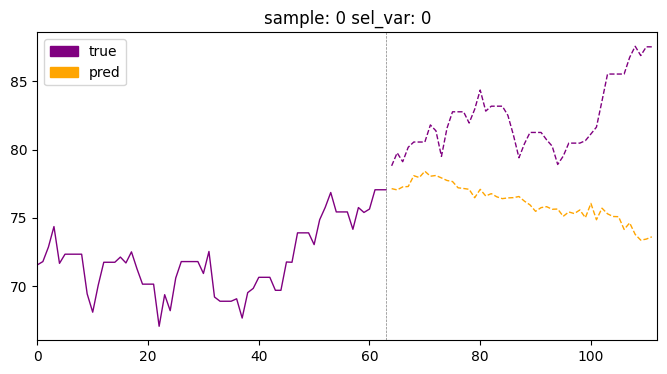

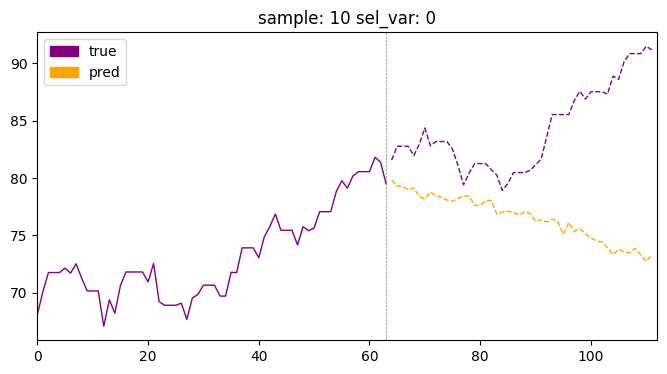

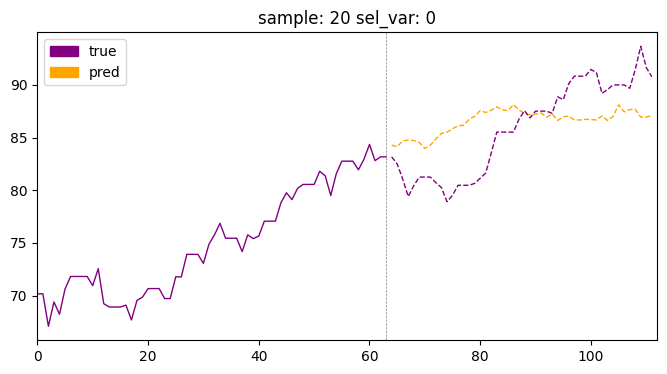

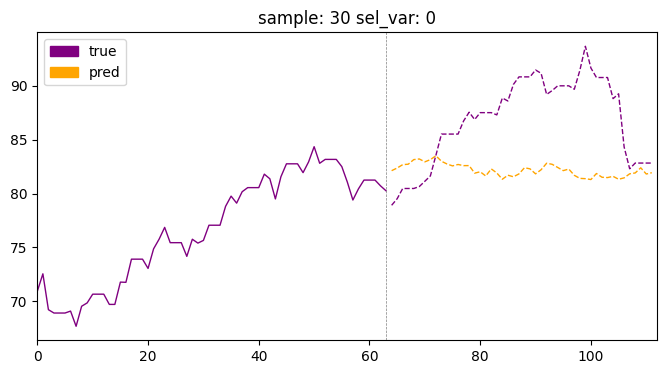

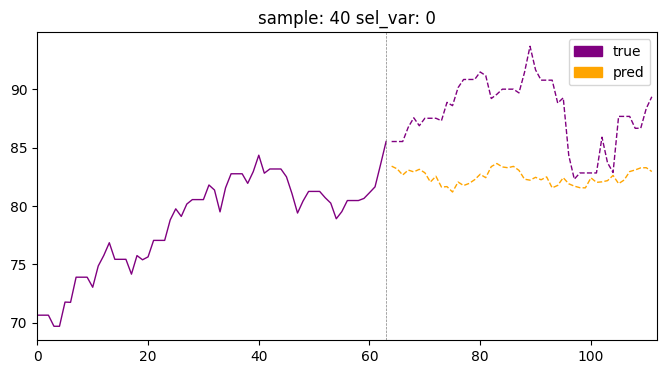

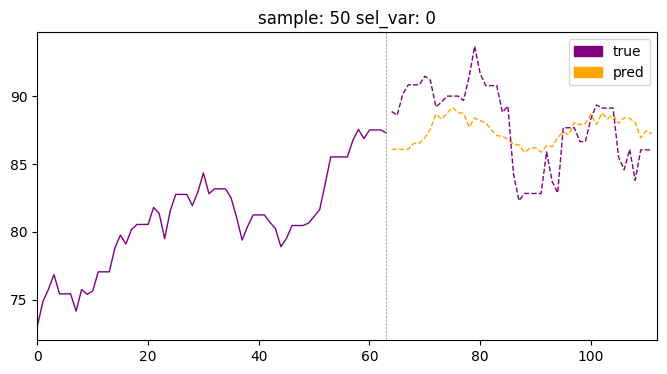

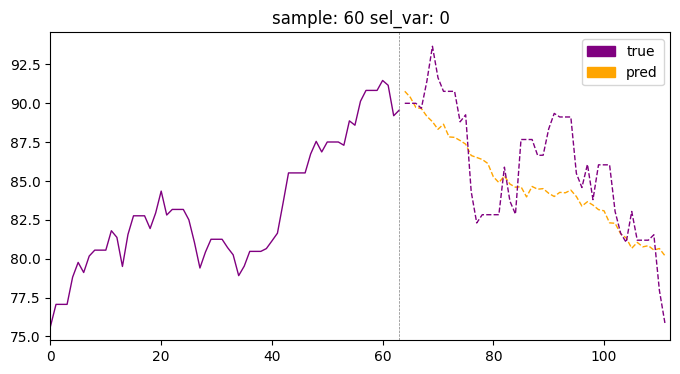

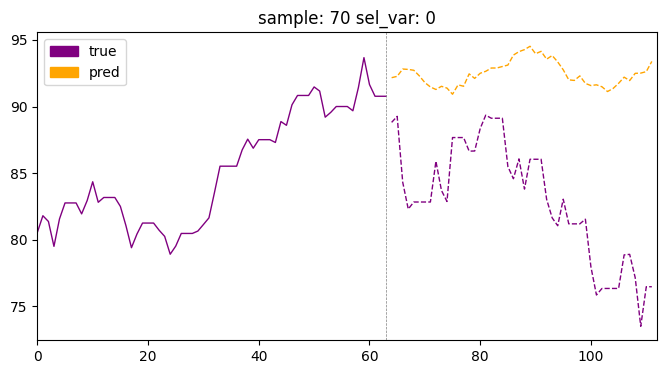

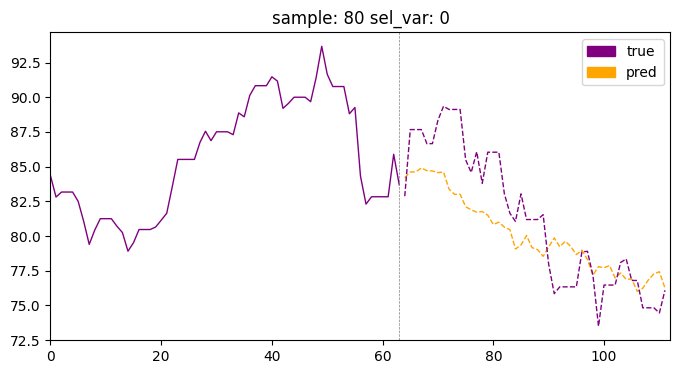

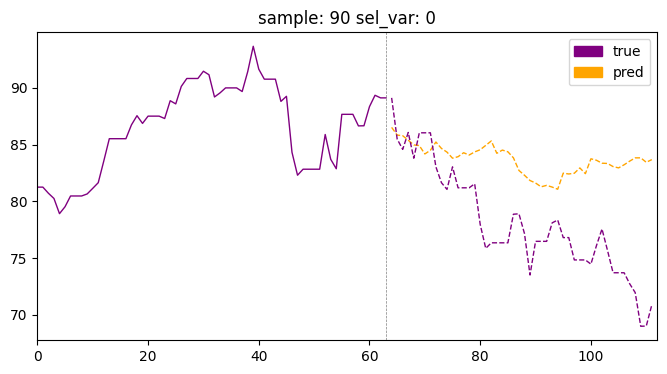

In [125]:
for id in range (0,100, 10):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


In [126]:
learn = load_learner('patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(x[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df






y_test_preds.shape: (234, 1, 48)


mse       mae
test  0.082199  0.236242

In [130]:

x_test = x[splits[2]]
y_test = y[splits[2]]


inverse_scale_y_preds = scaler.inverse_transform(y_test_preds.reshape(-1, 1)).flatten().reshape(234, 1, fcst_horizon)
inverse_scale_y_true = (scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()).reshape(234, 1, fcst_horizon)
inverse_scale_x_test = scaler.inverse_transform(x_test.reshape(-1, 1)).flatten().reshape(234, 1, fcst_history)

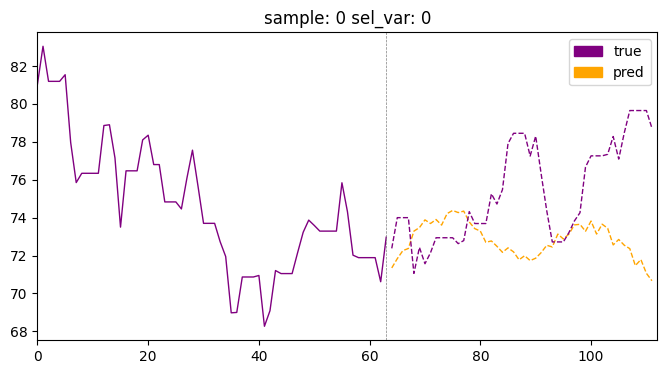

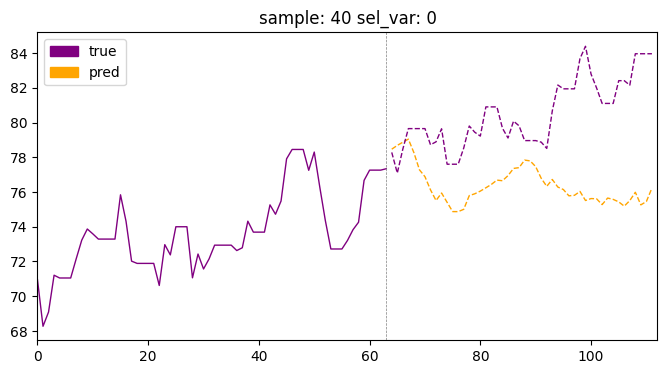

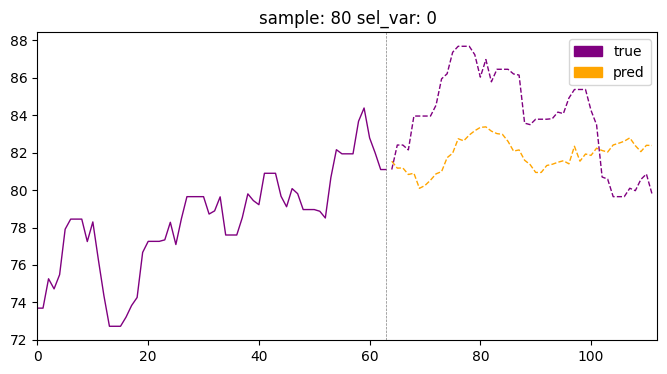

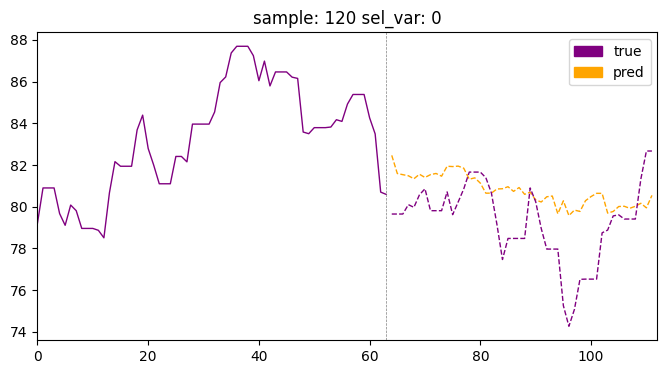

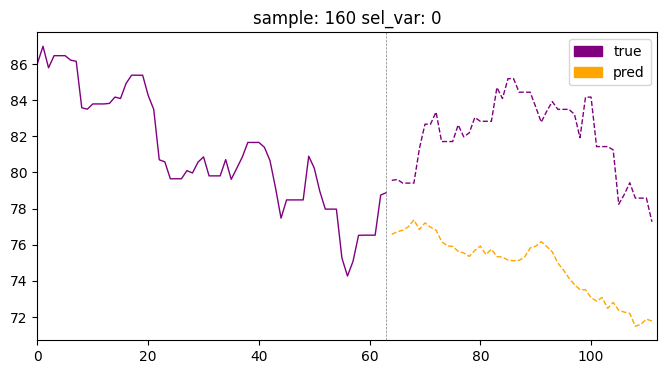

In [131]:
for id in range (0,200, 40):
  plot_forecast(inverse_scale_x_test, inverse_scale_y_true, inverse_scale_y_preds, sel_vars = True, idx = id)


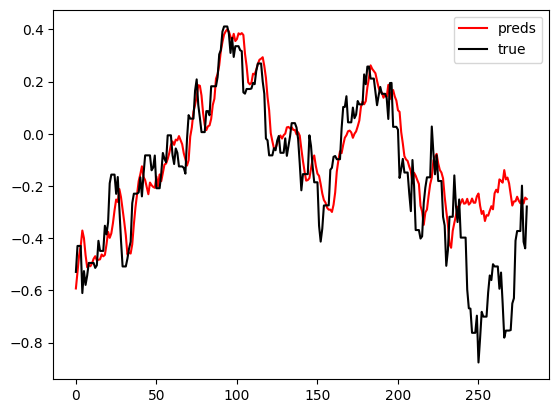

In [132]:
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
y_test_preds = torch.tensor(y_test_preds)



y_preds_one = y_test_preds[:, 0, 0]
y_true_one = y_test[:, 0, 0]

y_preds_last = y_test_preds[-1, 0, 1:]
y_true_last = y_test[-1, 0, 1:]

y_preds_appended = torch.cat((y_preds_one, y_preds_last))
y_true_appended = torch.cat((y_true_one, y_true_last))



plt.plot(y_preds_appended, c = 'r', label = 'preds')
plt.plot(y_true_appended, c = 'k', label = 'true')
plt.legend()
